#### Some models takes a long time to train. 
#### This is the Google Cloud Link with a few important models.
https://drive.google.com/drive/folders/1F9BrUxdsFynWBTSaPAJQS5lKlJ7urouE?usp=sharing
#### It takes 15˜30 seconds to predict 100 test samples with a proper Nvidia GPU
#### Around 10 Minutes with a Macbook Air M4 (100*150 Images, Still Impressive Speed)

Juntong Shen (z5578772)
2025.8.8
Final Version.

The objectives of this project is to build a model that can precisely segment tumor structures of brain MRI images.

It will prove helpful in the diagnosis and follow up examinations of patients. As manually identication is labor-intensive and error-prone.

Also, with a 3-D segmentation of the tumor structure, it can be very helpful when carrying out surgery.

##### Part I. Environment Setup and Dataset Exploration.
##### And this is just some environments.

In [1]:
import os
import numpy as np
import nibabel as nib
import glob
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import shutil
import os, sys, time
import numpy as np
import scipy.ndimage as ndi
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam
import random
import SimpleITK as sitk

scaler = MinMaxScaler()

The entire BraTS 2020 Dataset consist of over 300 images of patients, each has 150 slices of images. This will be shown later. 


To Help Understand The MRI Images. We Should Look At It First.

File 355's segmentation file has a wrong name, I changed it by hand.

Then I renamed the folders to make it easier.


This is to check out the file, we select file 083 as an example.

The file name "083" stands for the No.083 Patient.
We selected one of the patient and showed one slice of his brain MRI scan, to have a better understanding of how the data is structured.



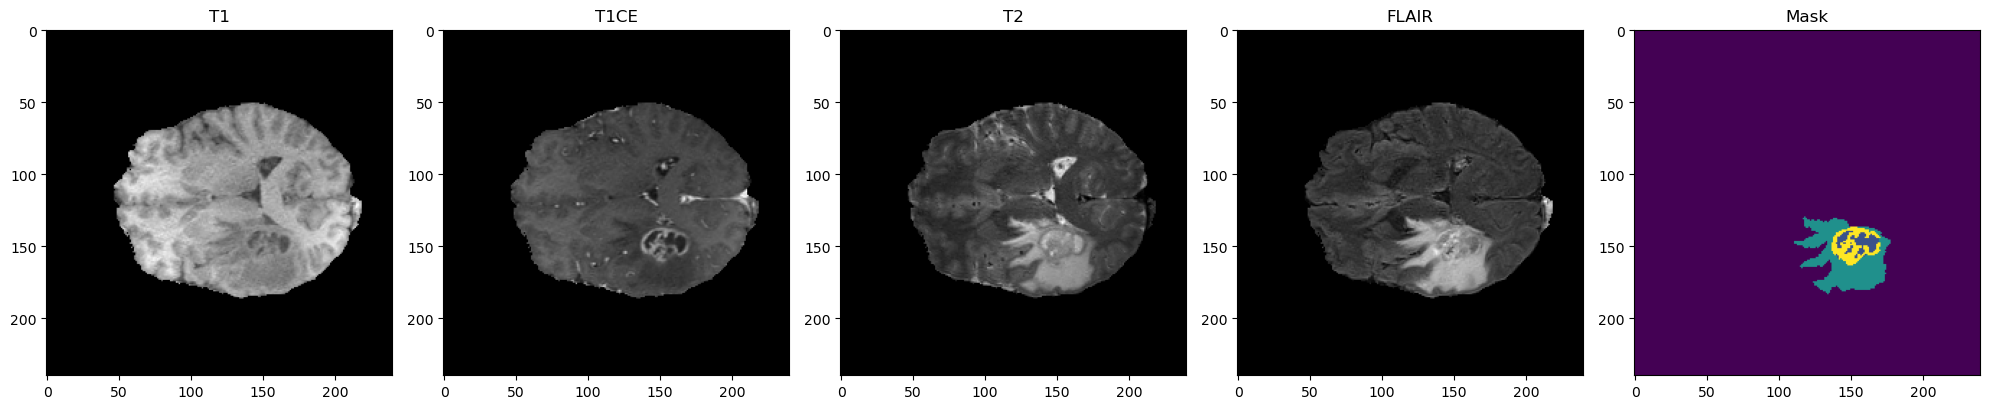

In [ ]:
INPUT_PATH='BraTS2020_Training_Data'
OUTPUT_PATH='BraTS2020_Training_Data_Processed'
SPLIT_PATH='BraTS2020_Training_Data_Split'

IMG_HEIGHT=128
IMG_WIDTH=128
IMG_DEPTH=128
N_CHANNELS=3
N_CLASSES=4

patient_prefix = 'BraTS20_Training_083'
DATA_PATH = f'BraTS2020_Training_Data/{patient_prefix}/'

def load_and_normalize(filename):
    image = nib.load(os.path.join(DATA_PATH, filename)).get_fdata()
    image = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
    return image


# These are all the channels of the MRI and the mask.
flair = load_and_normalize(f'{patient_prefix}_flair.nii')
t1    = load_and_normalize(f'{patient_prefix}_t1.nii')
t1ce  = load_and_normalize(f'{patient_prefix}_t1ce.nii')
t2    = load_and_normalize(f'{patient_prefix}_t2.nii')
mask = nib.load(os.path.join(DATA_PATH, f'{patient_prefix}_seg.nii')).get_fdata().astype(np.uint8)

# Slice 68 is easy to see.
n_slice = 68


plt.figure(figsize=(20, 8))

plt.subplot(2, 5, 1)
plt.imshow(t1[:, :, n_slice], cmap='gray')
plt.title('T1')

plt.subplot(2, 5, 2)
plt.imshow(t1ce[:, :, n_slice], cmap='gray')
plt.title('T1CE')

plt.subplot(2, 5, 3)
plt.imshow(t2[:, :, n_slice], cmap='gray')
plt.title('T2')

plt.subplot(2, 5, 4)
plt.imshow(flair[:, :, n_slice], cmap='gray')
plt.title('FLAIR')

plt.subplot(2, 5, 5)
plt.imshow(mask[:, :, n_slice])
plt.title('Mask')

plt.tight_layout()
plt.show()


Now the first thing we notice is that different channels of the same image focus on different parts of the tumor. 

T1 is rather a default image, showing mostly the original form of the brain scan.

T1CE's CE stands for Contrast Enhancement, showing more clearly the structure of the tumor, especially the core tumor, which is blue in the mask.

T2 is more related with liquid in the brain

FLAIR (Fluid Attenuated Inversion Recovery) is based on T2 but shows more clearly the whole impact area of the tumor.

The masks represents different parts of the tumor. 

Blue: GD Enhanced Tumor Core.

Yellow: Necrosis area

Green: Surrounding Edema

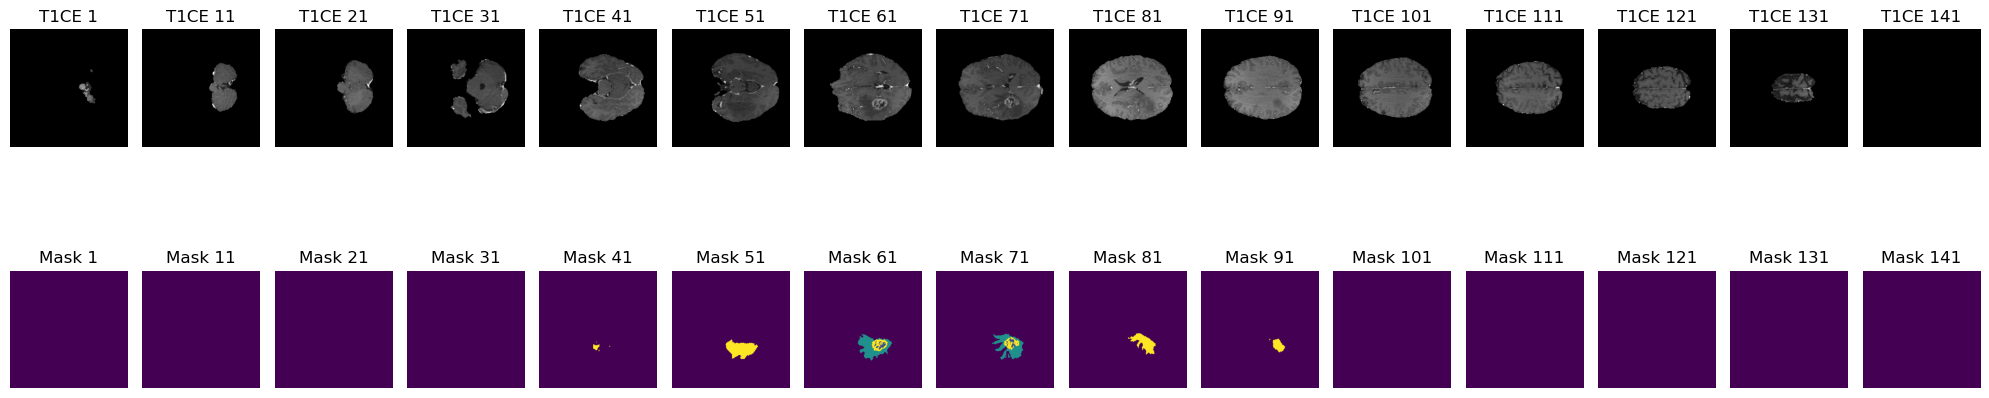

In [71]:
slices = list(range(1, 151, 10))  #Show every 10th slice for better visibility

plt.figure(figsize=(20, 6))  

for idx, slice_idx in enumerate(slices):
    plt.subplot(2, 15, idx + 1)
    plt.imshow(t1ce[:, :, slice_idx], cmap='gray')
    plt.title(f'T1CE {slice_idx}')
    plt.axis('off')

for idx, slice_idx in enumerate(slices):
    plt.subplot(2, 15, 15 + idx + 1)
    plt.imshow(mask[:, :, slice_idx])
    plt.title(f'Mask {slice_idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()


Each MRI scan contains 150 layers of the brain, with only the middle part containing entire brain and tumor tissue.
We can discard some parts for faster training.

Also to avoid too many negative inputs.

The most challenging part of this project is to clearly distinguish different parts of the tumor. 

It is obviously easier to identify the tumor with the Edema mask. But certainly implausible to cut out the entire area and keep the patient alive. So clearly identifying the Tumor Core and Necrosis Area is very improtant.

##### Part II. Data Processing.

Tasks:
1. T1 is quite useless, discard that. (T1 CE is obviously a better version of T1)
2. The top and bottom slices are useless, discard.
3. The image is too big, we can crop it a little bit.

Note: Typically we have more data augmentation methods such as rotating and blurring. But since the images in our task are very well organized, and we can expect every MRI scans in the future to look about the same. These actions seems unnecessary.

In [24]:
BASE_PATH = 'BraTS2020_Training_Data'

t2_list = sorted(glob.glob(os.path.join(BASE_PATH, '*/*t2.nii')))
t1ce_list = sorted(glob.glob(os.path.join(BASE_PATH, '*/*t1ce.nii')))
flair_list = sorted(glob.glob(os.path.join(BASE_PATH, '*/*flair.nii')))
mask_list = sorted(glob.glob(os.path.join(BASE_PATH, '*/*seg.nii')))

SAVE_IMG_PATH = 'BraTS2020_Training_Data_Processed/images/'
SAVE_MASK_PATH = 'BraTS2020_Training_Data_Processed/masks/'
os.makedirs(SAVE_IMG_PATH, exist_ok=True)
os.makedirs(SAVE_MASK_PATH, exist_ok=True)

log_queue = []

for img in range(len(t2_list)):
    log_msg = f"Now preparing image and mask number: {img}"
    log_queue.append(log_msg)

    if len(log_queue) > 5:
        log_queue.pop(0)

    sys.stdout.write("\r" + "\n".join(log_queue[-5:]) + "\n")
    sys.stdout.flush()

    def load_and_scale(path):
        data = nib.load(path).get_fdata()
        data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
        return data

    # Discard T1
    temp_image_t2 = load_and_scale(t2_list[img])
    temp_image_t1ce = load_and_scale(t1ce_list[img])
    temp_image_flair = load_and_scale(flair_list[img])

    # Relabel the value to avoid confusion
    temp_mask = nib.load(mask_list[img]).get_fdata().astype(np.uint8)
    temp_mask[temp_mask == 4] = 3

    # Crop to 128*128*128
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    temp_combined_images = temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    # Discard images with low foreground ratio
    val, counts = np.unique(temp_mask, return_counts=True)
    fg_ratio = 1 - (counts[0] / counts.sum()) if 0 in val else 1.0

    if fg_ratio > 0.01:
        temp_mask_tensor = torch.from_numpy(temp_mask).long()
        temp_mask_ohe = F.one_hot(temp_mask_tensor, num_classes=4).numpy()
        np.save(os.path.join(SAVE_IMG_PATH, f'image_{img}.npy'), temp_combined_images)
        np.save(os.path.join(SAVE_MASK_PATH, f'mask_{img}.npy'), temp_mask_ohe)
    else:
        log_queue[-1] += " — Discarded (low foreground)"


Now preparing image and mask number: 0
Now preparing image and mask number: 0
Now preparing image and mask number: 1
Now preparing image and mask number: 0
Now preparing image and mask number: 1
Now preparing image and mask number: 2
Now preparing image and mask number: 0
Now preparing image and mask number: 1
Now preparing image and mask number: 2
Now preparing image and mask number: 3
Now preparing image and mask number: 0
Now preparing image and mask number: 1
Now preparing image and mask number: 2
Now preparing image and mask number: 3
Now preparing image and mask number: 4
Now preparing image and mask number: 1
Now preparing image and mask number: 2
Now preparing image and mask number: 3
Now preparing image and mask number: 4 — Discarded (low foreground)
Now preparing image and mask number: 5
Now preparing image and mask number: 2
Now preparing image and mask number: 3
Now preparing image and mask number: 4 — Discarded (low foreground)
Now preparing image and mask number: 5
Now pr

Split Data Into Training and Validation

In [ ]:
import splitfolders

input_folder = 'BraTS2020_Training_Data_Processed'
output_folder = 'BraTS2021_TrainingData_Split'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2), group_prefix=None) 

##### Part III. Model Exploration.

In this section, we have several models for comparison (Ablation Test).
These code blocks are structured in the order of 

Model Definition--Training--Testing.

Model A: basic 3D U-Net model. With slight modifications to make it suitable for 3D image imputs.

This is ancient in today's standard, just use it as a baseline.

In [ ]:
# Model Definition
class UNet3D(nn.Module):
    def __init__(self, in_channels=3, out_classes=4, base_filters=16):
        super(UNet3D, self).__init__()
        
        self.encoder1 = self.conv_block(in_channels, base_filters)
        self.pool1 = nn.MaxPool3d(2)

        self.encoder2 = self.conv_block(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool3d(2)

        self.encoder3 = self.conv_block(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool3d(2)

        self.encoder4 = self.conv_block(base_filters*4, base_filters*8)
        self.pool4 = nn.MaxPool3d(2)

        self.bottleneck = self.conv_block(base_filters*8, base_filters*16)

        self.upconv4 = nn.ConvTranspose3d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(base_filters*16, base_filters*8)

        self.upconv3 = nn.ConvTranspose3d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(base_filters*8, base_filters*4)

        self.upconv2 = nn.ConvTranspose3d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose3d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(base_filters*2, base_filters)

        self.out_conv = nn.Conv3d(base_filters, out_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout3d(0.1 if out_channels <= 32 else 0.2 if out_channels <= 128 else 0.3),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        c1 = self.encoder1(x)
        p1 = self.pool1(c1)

        c2 = self.encoder2(p1)
        p2 = self.pool2(c2)

        c3 = self.encoder3(p2)
        p3 = self.pool3(c3)

        c4 = self.encoder4(p3)
        p4 = self.pool4(c4)

        bn = self.bottleneck(p4)

        u4 = self.upconv4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        d4 = self.decoder4(u4)

        u3 = self.upconv3(d4)
        u3 = torch.cat([u3, c3], dim=1)
        d3 = self.decoder3(u3)

        u2 = self.upconv2(d3)
        u2 = torch.cat([u2, c2], dim=1)
        d2 = self.decoder2(u2)

        u1 = self.upconv1(d2)
        u1 = torch.cat([u1, c1], dim=1)
        d1 = self.decoder1(u1)

        out = self.out_conv(d1)
        return out

Epoch 1/100: 100%|██████████| 138/138 [01:19<00:00,  1.73it/s]


Epoch 1: Train Loss = 1.3371, Val Loss = 0.9493


Epoch 2/100: 100%|██████████| 138/138 [01:18<00:00,  1.77it/s]


Epoch 2: Train Loss = 0.9144, Val Loss = 0.8603


Epoch 3/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 3: Train Loss = 0.8620, Val Loss = 0.8425


Epoch 4/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 4: Train Loss = 0.8583, Val Loss = 0.8176


Epoch 5/100: 100%|██████████| 138/138 [01:16<00:00,  1.79it/s]


Epoch 5: Train Loss = 0.8517, Val Loss = 0.8095


Epoch 6/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 6: Train Loss = 0.8301, Val Loss = 0.8028


Epoch 7/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 7: Train Loss = 0.8217, Val Loss = 0.7993


Epoch 8/100: 100%|██████████| 138/138 [01:16<00:00,  1.80it/s]


Epoch 8: Train Loss = 0.8235, Val Loss = 0.7912


Epoch 9/100: 100%|██████████| 138/138 [01:17<00:00,  1.79it/s]


Epoch 9: Train Loss = 0.7988, Val Loss = 0.7997


Epoch 10/100: 100%|██████████| 138/138 [01:15<00:00,  1.83it/s]


Epoch 10: Train Loss = 0.8036, Val Loss = 0.7588


Epoch 11/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 11: Train Loss = 0.7810, Val Loss = 0.7642


Epoch 12/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 12: Train Loss = 0.7793, Val Loss = 0.7410


Epoch 13/100: 100%|██████████| 138/138 [01:16<00:00,  1.80it/s]


Epoch 13: Train Loss = 0.7604, Val Loss = 0.7198


Epoch 14/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 14: Train Loss = 0.7603, Val Loss = 0.7287


Epoch 15/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 15: Train Loss = 0.7303, Val Loss = 0.6827


Epoch 16/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 16: Train Loss = 0.7232, Val Loss = 0.6622


Epoch 17/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 17: Train Loss = 0.7078, Val Loss = 0.6574


Epoch 18/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 18: Train Loss = 0.6733, Val Loss = 0.6408


Epoch 19/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 19: Train Loss = 0.6496, Val Loss = 0.6137


Epoch 20/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 20: Train Loss = 0.6477, Val Loss = 0.5818


Epoch 21/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 21: Train Loss = 0.6232, Val Loss = 0.5664


Epoch 22/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 22: Train Loss = 0.6079, Val Loss = 0.6009


Epoch 23/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 23: Train Loss = 0.5950, Val Loss = 0.5480


Epoch 24/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 24: Train Loss = 0.5882, Val Loss = 0.5383


Epoch 25/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 25: Train Loss = 0.5812, Val Loss = 0.5376


Epoch 26/100: 100%|██████████| 138/138 [01:16<00:00,  1.80it/s]


Epoch 26: Train Loss = 0.5666, Val Loss = 0.5273


Epoch 27/100: 100%|██████████| 138/138 [01:15<00:00,  1.83it/s]


Epoch 27: Train Loss = 0.5601, Val Loss = 0.5364


Epoch 28/100: 100%|██████████| 138/138 [01:18<00:00,  1.77it/s]


Epoch 28: Train Loss = 0.5521, Val Loss = 0.5502


Epoch 29/100: 100%|██████████| 138/138 [01:18<00:00,  1.77it/s]


Epoch 29: Train Loss = 0.5323, Val Loss = 0.5152


Epoch 30/100: 100%|██████████| 138/138 [01:19<00:00,  1.73it/s]


Epoch 30: Train Loss = 0.5500, Val Loss = 0.5140


Epoch 31/100: 100%|██████████| 138/138 [01:19<00:00,  1.73it/s]


Epoch 31: Train Loss = 0.5348, Val Loss = 0.5031


Epoch 32/100: 100%|██████████| 138/138 [01:15<00:00,  1.83it/s]


Epoch 32: Train Loss = 0.5272, Val Loss = 0.5091


Epoch 33/100: 100%|██████████| 138/138 [01:15<00:00,  1.84it/s]


Epoch 33: Train Loss = 0.5233, Val Loss = 0.4840


Epoch 34/100: 100%|██████████| 138/138 [01:15<00:00,  1.83it/s]


Epoch 34: Train Loss = 0.5278, Val Loss = 0.4876


Epoch 35/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 35: Train Loss = 0.5200, Val Loss = 0.4906


Epoch 36/100: 100%|██████████| 138/138 [01:16<00:00,  1.80it/s]


Epoch 36: Train Loss = 0.5051, Val Loss = 0.4686


Epoch 37/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 37: Train Loss = 0.5084, Val Loss = 0.5011


Epoch 38/100: 100%|██████████| 138/138 [01:18<00:00,  1.76it/s]


Epoch 38: Train Loss = 0.5132, Val Loss = 0.4607


Epoch 39/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 39: Train Loss = 0.4941, Val Loss = 0.4504


Epoch 40/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 40: Train Loss = 0.4833, Val Loss = 0.4615


Epoch 41/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 41: Train Loss = 0.4790, Val Loss = 0.4485


Epoch 42/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 42: Train Loss = 0.4702, Val Loss = 0.4475


Epoch 43/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 43: Train Loss = 0.4796, Val Loss = 0.4445


Epoch 44/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 44: Train Loss = 0.4666, Val Loss = 0.4306


Epoch 45/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 45: Train Loss = 0.4585, Val Loss = 0.4258


Epoch 46/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 46: Train Loss = 0.4699, Val Loss = 0.4596


Epoch 47/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 47: Train Loss = 0.4695, Val Loss = 0.4257


Epoch 48/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 48: Train Loss = 0.4498, Val Loss = 0.4248


Epoch 49/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 49: Train Loss = 0.4447, Val Loss = 0.4189


Epoch 50/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 50: Train Loss = 0.4471, Val Loss = 0.4193


Epoch 51/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 51: Train Loss = 0.4328, Val Loss = 0.4204


Epoch 52/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 52: Train Loss = 0.4353, Val Loss = 0.3977


Epoch 53/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 53: Train Loss = 0.4191, Val Loss = 0.4101


Epoch 54/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 54: Train Loss = 0.4187, Val Loss = 0.4065


Epoch 55/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 55: Train Loss = 0.4147, Val Loss = 0.4092


Epoch 56/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 56: Train Loss = 0.4157, Val Loss = 0.3951


Epoch 57/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 57: Train Loss = 0.3993, Val Loss = 0.4016


Epoch 58/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 58: Train Loss = 0.4034, Val Loss = 0.3983


Epoch 59/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 59: Train Loss = 0.3974, Val Loss = 0.4056


Epoch 60/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 60: Train Loss = 0.3927, Val Loss = 0.3940


Epoch 61/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 61: Train Loss = 0.3950, Val Loss = 0.3849


Epoch 62/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 62: Train Loss = 0.3791, Val Loss = 0.3690


Epoch 63/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 63: Train Loss = 0.3758, Val Loss = 0.3821


Epoch 64/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 64: Train Loss = 0.3865, Val Loss = 0.3796


Epoch 65/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 65: Train Loss = 0.3773, Val Loss = 0.3826


Epoch 66/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 66: Train Loss = 0.3774, Val Loss = 0.3787


Epoch 67/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 67: Train Loss = 0.3718, Val Loss = 0.3821


Epoch 68/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 68: Train Loss = 0.3723, Val Loss = 0.4029


Epoch 69/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 69: Train Loss = 0.3623, Val Loss = 0.3762


Epoch 70/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 70: Train Loss = 0.3704, Val Loss = 0.3734


Epoch 71/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 71: Train Loss = 0.3596, Val Loss = 0.3731


Epoch 72/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 72: Train Loss = 0.3479, Val Loss = 0.3772


Epoch 73/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 73: Train Loss = 0.3551, Val Loss = 0.3767


Epoch 74/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 74: Train Loss = 0.3533, Val Loss = 0.3680


Epoch 75/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 75: Train Loss = 0.3406, Val Loss = 0.3637


Epoch 76/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 76: Train Loss = 0.3451, Val Loss = 0.3695


Epoch 77/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 77: Train Loss = 0.3445, Val Loss = 0.3636


Epoch 78/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 78: Train Loss = 0.3489, Val Loss = 0.3761


Epoch 79/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 79: Train Loss = 0.3441, Val Loss = 0.3724


Epoch 80/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 80: Train Loss = 0.3401, Val Loss = 0.3833


Epoch 81/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 81: Train Loss = 0.3389, Val Loss = 0.3608


Epoch 82/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 82: Train Loss = 0.3508, Val Loss = 0.3775


Epoch 83/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 83: Train Loss = 0.3395, Val Loss = 0.3674


Epoch 84/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 84: Train Loss = 0.3214, Val Loss = 0.3693


Epoch 85/100: 100%|██████████| 138/138 [01:16<00:00,  1.82it/s]


Epoch 85: Train Loss = 0.3247, Val Loss = 0.3546


Epoch 86/100: 100%|██████████| 138/138 [01:16<00:00,  1.82it/s]


Epoch 86: Train Loss = 0.3195, Val Loss = 0.3560


Epoch 87/100: 100%|██████████| 138/138 [01:15<00:00,  1.83it/s]


Epoch 87: Train Loss = 0.3216, Val Loss = 0.3565


Epoch 88/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 88: Train Loss = 0.3144, Val Loss = 0.3683


Epoch 89/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 89: Train Loss = 0.3142, Val Loss = 0.3753


Epoch 90/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 90: Train Loss = 0.3152, Val Loss = 0.3694


Epoch 91/100: 100%|██████████| 138/138 [01:16<00:00,  1.82it/s]


Epoch 91: Train Loss = 0.3096, Val Loss = 0.3571


Epoch 92/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 92: Train Loss = 0.3033, Val Loss = 0.3767


Epoch 93/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 93: Train Loss = 0.3056, Val Loss = 0.3689


Epoch 94/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 94: Train Loss = 0.3007, Val Loss = 0.3786


Epoch 95/100: 100%|██████████| 138/138 [01:16<00:00,  1.80it/s]


Epoch 95: Train Loss = 0.3100, Val Loss = 0.3772


Epoch 96/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 96: Train Loss = 0.3040, Val Loss = 0.3623


Epoch 97/100: 100%|██████████| 138/138 [01:15<00:00,  1.82it/s]


Epoch 97: Train Loss = 0.3096, Val Loss = 0.3561


Epoch 98/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 98: Train Loss = 0.2992, Val Loss = 0.3554


Epoch 99/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 99: Train Loss = 0.2995, Val Loss = 0.3630


Epoch 100/100: 100%|██████████| 138/138 [01:16<00:00,  1.81it/s]


Epoch 100: Train Loss = 0.2993, Val Loss = 0.3499


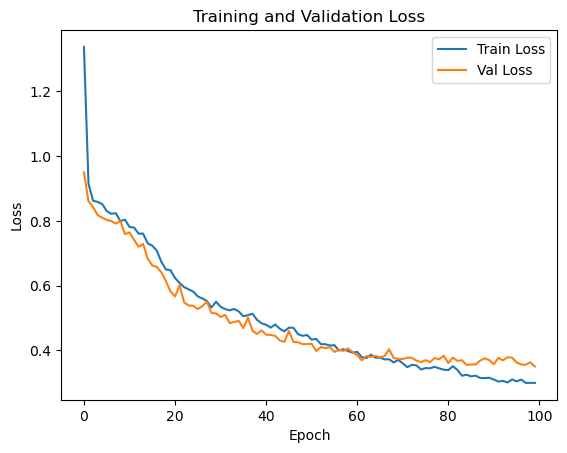

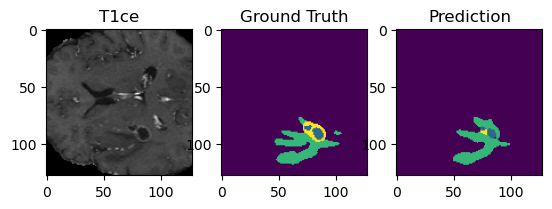

In [ ]:
#Training Process

class BraTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])  # (128,128,128,3)
        mask = np.load(self.mask_paths[idx])    # (128,128,128,4)

        image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2)  # -> [3, D, H, W]
        mask = torch.tensor(np.argmax(mask, axis=-1), dtype=torch.long)      # -> [D, H, W]

        return image, mask

train_dataset = BraTSDataset(
    image_dir='BraTS2021_TrainingData_Split/train/images/',
    mask_dir='BraTS2021_TrainingData_Split/train/masks/'
)

val_dataset = BraTSDataset(
    image_dir='BraTS2021_TrainingData_Split/val/images/',
    mask_dir='BraTS2021_TrainingData_Split/val/masks/'
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        num_classes = preds.shape[1]
        preds = torch.softmax(preds, dim=1)
        targets_onehot = F.one_hot(targets, num_classes).permute(0, 4, 1, 2, 3).float()
        
        intersection = (preds * targets_onehot).sum(dim=(2,3,4))
        union = preds.sum(dim=(2,3,4)) + targets_onehot.sum(dim=(2,3,4))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet3D(in_channels=3, out_classes=4).to(device)

ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss()

optimizer = Adam(model.parameters(), lr=1e-4)
num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        outputs = model(images)  # [B, 4, D, H, W]
        loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_loss = total_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        val_loss = 0
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

torch.save(model.state_dict(), 'Basic_100.pth')


plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


===== Test Evaluation Summary =====
Mean IoU   : 0.6284
Mean Dice  : 0.7228
Mean HD95  : 23.7599
Mean ASSD  : 0.6514


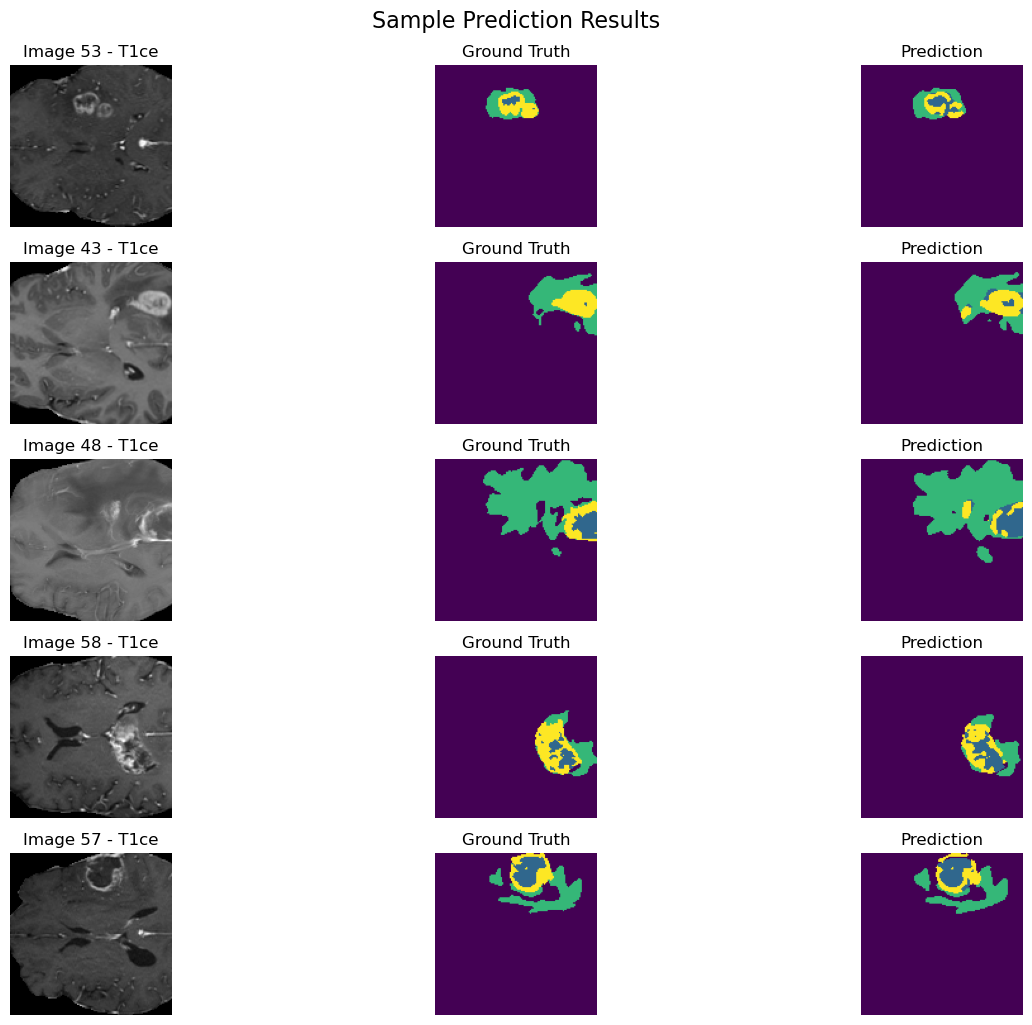

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        mask = np.load(self.mask_paths[idx])
        image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2)  
        mask = torch.tensor(np.argmax(mask, axis=-1), dtype=torch.long)      
        return image, mask

def compute_iou(pred, target, num_classes=4):
    pred, target = pred.view(-1), target.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        ious.append(intersection / union if union != 0 else float('nan'))
    return np.nanmean(ious)

def compute_dice(pred, target, num_classes=4, smooth=1e-5):
    pred, target = pred.view(-1), target.view(-1)
    dices = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item()
        dices.append((2. * intersection + smooth) / (union + smooth) if union != 0 else float('nan'))
    return np.nanmean(dices)

def compute_hd95(pred_np, gt_np):
    pred_itk = sitk.GetImageFromArray(pred_np.astype(np.uint8))
    gt_itk = sitk.GetImageFromArray(gt_np.astype(np.uint8))
    hausdorff = sitk.HausdorffDistanceImageFilter()
    hausdorff.Execute(pred_itk, gt_itk)
    return hausdorff.GetHausdorffDistance(), hausdorff.GetAverageHausdorffDistance()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D(in_channels=3, out_classes=4).to(device)
model.load_state_dict(torch.load("Basic_100.pth", map_location=device))
model.eval()

test_dataset = BraTSDataset('BraTS2021_Testing/images/', 'BraTS2021_Testing/masks/')
ious, dices, hd95s, assds = [], [], [], []

for image, mask in test_dataset:
    image, mask = image.to(device), mask.to(device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))  
        pred = output.argmax(dim=1).squeeze(0)  

    ious.append(compute_iou(pred, mask))
    dices.append(compute_dice(pred, mask))
    hd, assd = compute_hd95(pred.cpu().numpy(), mask.cpu().numpy())
    hd95s.append(hd)
    assds.append(assd)

print(f"\n===== Test Evaluation Summary =====")
print(f"Mean IoU   : {np.nanmean(ious):.4f}")
print(f"Mean Dice  : {np.nanmean(dices):.4f}")
print(f"Mean HD95  : {np.nanmean(hd95s):.4f}")
print(f"Mean ASSD  : {np.nanmean(assds):.4f}")

slice_idx = 62
indices_to_plot = [53, 43, 48] + random.sample([i for i in range(len(test_dataset)) if i not in [53,43,48]], 2)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices_to_plot):
    image, mask = test_dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(image[1, :, :, slice_idx], cmap='gray')  
    plt.title(f"Image {idx} - T1ce")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(mask[:, :, slice_idx].cpu())
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 3)
    plt.imshow(pred[:, :, slice_idx])
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Sample Prediction Results", y=1.02, fontsize=16)
plt.show()



Model B

Attention Gate and Learning Rate Scheduling.

It takes a very long time to train, and the performance is not very good.

In [23]:
class AttentionBlock3D(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock3D, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv3d(F_g, F_int, kernel_size=1),
            nn.BatchNorm3d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv3d(F_l, F_int, kernel_size=1),
            nn.BatchNorm3d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv3d(F_int, 1, kernel_size=1),
            nn.BatchNorm3d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi


class UNet3DWithAttention(nn.Module):
    def __init__(self, in_channels=3, out_classes=4, base_filters=16):
        super(UNet3DWithAttention, self).__init__()

        self.encoder1 = self.conv_block(in_channels, base_filters)
        self.pool1 = nn.MaxPool3d(2)

        self.encoder2 = self.conv_block(base_filters, base_filters*2)
        self.pool2 = nn.MaxPool3d(2)

        self.encoder3 = self.conv_block(base_filters*2, base_filters*4)
        self.pool3 = nn.MaxPool3d(2)

        self.encoder4 = self.conv_block(base_filters*4, base_filters*8)
        self.pool4 = nn.MaxPool3d(2)

        self.bottleneck = self.conv_block(base_filters*8, base_filters*16)

        self.upconv4 = nn.ConvTranspose3d(base_filters*16, base_filters*8, kernel_size=2, stride=2)
        self.att4 = AttentionBlock3D(F_g=base_filters*8, F_l=base_filters*8, F_int=base_filters*4)
        self.decoder4 = self.conv_block(base_filters*16, base_filters*8)

        self.upconv3 = nn.ConvTranspose3d(base_filters*8, base_filters*4, kernel_size=2, stride=2)
        self.att3 = AttentionBlock3D(F_g=base_filters*4, F_l=base_filters*4, F_int=base_filters*2)
        self.decoder3 = self.conv_block(base_filters*8, base_filters*4)

        self.upconv2 = nn.ConvTranspose3d(base_filters*4, base_filters*2, kernel_size=2, stride=2)
        self.att2 = AttentionBlock3D(F_g=base_filters*2, F_l=base_filters*2, F_int=base_filters)
        self.decoder2 = self.conv_block(base_filters*4, base_filters*2)

        self.upconv1 = nn.ConvTranspose3d(base_filters*2, base_filters, kernel_size=2, stride=2)
        self.att1 = AttentionBlock3D(F_g=base_filters, F_l=base_filters, F_int=base_filters // 2)
        self.decoder1 = self.conv_block(base_filters*2, base_filters)

        self.out_conv = nn.Conv3d(base_filters, out_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout3d(0.1 if out_channels <= 32 else 0.2 if out_channels <= 128 else 0.3),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        c1 = self.encoder1(x)
        p1 = self.pool1(c1)

        c2 = self.encoder2(p1)
        p2 = self.pool2(c2)

        c3 = self.encoder3(p2)
        p3 = self.pool3(c3)

        c4 = self.encoder4(p3)
        p4 = self.pool4(c4)

        bn = self.bottleneck(p4)

        u4 = self.upconv4(bn)
        c4 = self.att4(g=u4, x=c4)
        u4 = torch.cat([u4, c4], dim=1)
        d4 = self.decoder4(u4)

        u3 = self.upconv3(d4)
        c3 = self.att3(g=u3, x=c3)
        u3 = torch.cat([u3, c3], dim=1)
        d3 = self.decoder3(u3)

        u2 = self.upconv2(d3)
        c2 = self.att2(g=u2, x=c2)
        u2 = torch.cat([u2, c2], dim=1)
        d2 = self.decoder2(u2)

        u1 = self.upconv1(d2)
        c1 = self.att1(g=u1, x=c1)
        u1 = torch.cat([u1, c1], dim=1)
        d1 = self.decoder1(u1)

        out = self.out_conv(d1)
        return out


Epoch 1/100: 100%|██████████| 138/138 [01:49<00:00,  1.25it/s]


Epoch 1: Train Loss = 1.5509, Val Loss = 0.9862, Train IoU = 0.1688, Val IoU = 0.2525, LR = 1.00e-04


Epoch 2/100: 100%|██████████| 138/138 [01:38<00:00,  1.41it/s]


Epoch 2: Train Loss = 0.9094, Val Loss = 0.8346, Train IoU = 0.2597, Val IoU = 0.2932, LR = 1.00e-04


Epoch 3/100: 100%|██████████| 138/138 [01:36<00:00,  1.43it/s]


Epoch 3: Train Loss = 0.8662, Val Loss = 0.8122, Train IoU = 0.2782, Val IoU = 0.3020, LR = 1.00e-04


Epoch 4/100: 100%|██████████| 138/138 [01:35<00:00,  1.44it/s]


Epoch 4: Train Loss = 0.8116, Val Loss = 0.7917, Train IoU = 0.2957, Val IoU = 0.3153, LR = 1.00e-04


Epoch 5/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 5: Train Loss = 0.7828, Val Loss = 0.7744, Train IoU = 0.3120, Val IoU = 0.3390, LR = 1.00e-04


Epoch 6/100: 100%|██████████| 138/138 [01:25<00:00,  1.61it/s]


Epoch 6: Train Loss = 0.7729, Val Loss = 0.7535, Train IoU = 0.3194, Val IoU = 0.3407, LR = 1.00e-04


Epoch 7/100: 100%|██████████| 138/138 [01:24<00:00,  1.63it/s]


Epoch 7: Train Loss = 0.7539, Val Loss = 0.7530, Train IoU = 0.3366, Val IoU = 0.3464, LR = 1.00e-04


Epoch 8/100: 100%|██████████| 138/138 [01:24<00:00,  1.63it/s]


Epoch 8: Train Loss = 0.7428, Val Loss = 0.7403, Train IoU = 0.3386, Val IoU = 0.3698, LR = 1.00e-04


Epoch 9/100: 100%|██████████| 138/138 [01:24<00:00,  1.62it/s]


Epoch 9: Train Loss = 0.7436, Val Loss = 0.7455, Train IoU = 0.3448, Val IoU = 0.3547, LR = 1.00e-04


Epoch 10/100: 100%|██████████| 138/138 [01:25<00:00,  1.62it/s]


Epoch 10: Train Loss = 0.7380, Val Loss = 0.7515, Train IoU = 0.3422, Val IoU = 0.3637, LR = 1.00e-04


Epoch 11/100: 100%|██████████| 138/138 [01:25<00:00,  1.62it/s]


Epoch 11: Train Loss = 0.7136, Val Loss = 0.7340, Train IoU = 0.3509, Val IoU = 0.3586, LR = 1.00e-04


Epoch 12/100: 100%|██████████| 138/138 [01:25<00:00,  1.62it/s]


Epoch 12: Train Loss = 0.7065, Val Loss = 0.7258, Train IoU = 0.3743, Val IoU = 0.3610, LR = 1.00e-04


Epoch 13/100: 100%|██████████| 138/138 [01:30<00:00,  1.52it/s]


Epoch 13: Train Loss = 0.6970, Val Loss = 0.6951, Train IoU = 0.3834, Val IoU = 0.3926, LR = 1.00e-04


Epoch 14/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 14: Train Loss = 0.6928, Val Loss = 0.6795, Train IoU = 0.3888, Val IoU = 0.3917, LR = 1.00e-04


Epoch 15/100: 100%|██████████| 138/138 [01:27<00:00,  1.58it/s]


Epoch 15: Train Loss = 0.6823, Val Loss = 0.7954, Train IoU = 0.4054, Val IoU = 0.3278, LR = 1.00e-04


Epoch 16/100: 100%|██████████| 138/138 [01:25<00:00,  1.62it/s]


Epoch 16: Train Loss = 0.6700, Val Loss = 0.6452, Train IoU = 0.4144, Val IoU = 0.4456, LR = 1.00e-04


Epoch 17/100: 100%|██████████| 138/138 [01:27<00:00,  1.58it/s]


Epoch 17: Train Loss = 0.6660, Val Loss = 0.6678, Train IoU = 0.4210, Val IoU = 0.4327, LR = 1.00e-04


Epoch 18/100: 100%|██████████| 138/138 [01:33<00:00,  1.47it/s]


Epoch 18: Train Loss = 0.6473, Val Loss = 0.6257, Train IoU = 0.4361, Val IoU = 0.4552, LR = 1.00e-04


Epoch 19/100: 100%|██████████| 138/138 [01:37<00:00,  1.42it/s]


Epoch 19: Train Loss = 0.6403, Val Loss = 0.7230, Train IoU = 0.4387, Val IoU = 0.3774, LR = 1.00e-04


Epoch 20/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 20: Train Loss = 0.6259, Val Loss = 0.5969, Train IoU = 0.4525, Val IoU = 0.4727, LR = 1.00e-04


Epoch 21/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 21: Train Loss = 0.6272, Val Loss = 0.6004, Train IoU = 0.4542, Val IoU = 0.4711, LR = 1.00e-04


Epoch 22/100: 100%|██████████| 138/138 [01:31<00:00,  1.50it/s]


Epoch 22: Train Loss = 0.6027, Val Loss = 0.5882, Train IoU = 0.4737, Val IoU = 0.4770, LR = 1.00e-04


Epoch 23/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 23: Train Loss = 0.6131, Val Loss = 0.6284, Train IoU = 0.4688, Val IoU = 0.4555, LR = 1.00e-04


Epoch 24/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 24: Train Loss = 0.5861, Val Loss = 0.6060, Train IoU = 0.4836, Val IoU = 0.4667, LR = 1.00e-04


Epoch 25/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 25: Train Loss = 0.5728, Val Loss = 0.5716, Train IoU = 0.4953, Val IoU = 0.5005, LR = 1.00e-04


Epoch 26/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 26: Train Loss = 0.5561, Val Loss = 0.5293, Train IoU = 0.4993, Val IoU = 0.5242, LR = 1.00e-04


Epoch 27/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 27: Train Loss = 0.5601, Val Loss = 0.5619, Train IoU = 0.5011, Val IoU = 0.5097, LR = 1.00e-04


Epoch 28/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 28: Train Loss = 0.5424, Val Loss = 0.5114, Train IoU = 0.5149, Val IoU = 0.5389, LR = 1.00e-04


Epoch 29/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 29: Train Loss = 0.5249, Val Loss = 0.4889, Train IoU = 0.5258, Val IoU = 0.5563, LR = 1.00e-04


Epoch 30/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 30: Train Loss = 0.5241, Val Loss = 0.5251, Train IoU = 0.5284, Val IoU = 0.5336, LR = 1.00e-04


Epoch 31/100: 100%|██████████| 138/138 [01:31<00:00,  1.50it/s]


Epoch 31: Train Loss = 0.5144, Val Loss = 0.5178, Train IoU = 0.5291, Val IoU = 0.5331, LR = 1.00e-04


Epoch 32/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 32: Train Loss = 0.5109, Val Loss = 0.4688, Train IoU = 0.5372, Val IoU = 0.5682, LR = 1.00e-04


Epoch 33/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 33: Train Loss = 0.5190, Val Loss = 0.4720, Train IoU = 0.5314, Val IoU = 0.5669, LR = 1.00e-04


Epoch 34/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 34: Train Loss = 0.4939, Val Loss = 0.4503, Train IoU = 0.5472, Val IoU = 0.5813, LR = 1.00e-04


Epoch 35/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 35: Train Loss = 0.4884, Val Loss = 0.5043, Train IoU = 0.5508, Val IoU = 0.5448, LR = 1.00e-04


Epoch 36/100: 100%|██████████| 138/138 [01:31<00:00,  1.50it/s]


Epoch 36: Train Loss = 0.4856, Val Loss = 0.4667, Train IoU = 0.5556, Val IoU = 0.5678, LR = 1.00e-04


Epoch 37/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 37: Train Loss = 0.4759, Val Loss = 0.4387, Train IoU = 0.5632, Val IoU = 0.5897, LR = 1.00e-04


Epoch 38/100: 100%|██████████| 138/138 [01:30<00:00,  1.53it/s]


Epoch 38: Train Loss = 0.4657, Val Loss = 0.4450, Train IoU = 0.5666, Val IoU = 0.5888, LR = 1.00e-04


Epoch 39/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 39: Train Loss = 0.4553, Val Loss = 0.4446, Train IoU = 0.5734, Val IoU = 0.5942, LR = 1.00e-04


Epoch 40/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 40: Train Loss = 0.4598, Val Loss = 0.4542, Train IoU = 0.5722, Val IoU = 0.5817, LR = 1.00e-04


Epoch 41/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 41: Train Loss = 0.4509, Val Loss = 0.4164, Train IoU = 0.5777, Val IoU = 0.6094, LR = 1.00e-04


Epoch 42/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 42: Train Loss = 0.4399, Val Loss = 0.4254, Train IoU = 0.5890, Val IoU = 0.5992, LR = 1.00e-04


Epoch 43/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 43: Train Loss = 0.4346, Val Loss = 0.4040, Train IoU = 0.5911, Val IoU = 0.6100, LR = 1.00e-04


Epoch 44/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 44: Train Loss = 0.4324, Val Loss = 0.4040, Train IoU = 0.5897, Val IoU = 0.6124, LR = 1.00e-04


Epoch 45/100: 100%|██████████| 138/138 [01:36<00:00,  1.42it/s]


Epoch 45: Train Loss = 0.4403, Val Loss = 0.4364, Train IoU = 0.5854, Val IoU = 0.5905, LR = 1.00e-04


Epoch 46/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 46: Train Loss = 0.4255, Val Loss = 0.4684, Train IoU = 0.5970, Val IoU = 0.5675, LR = 1.00e-04


Epoch 47/100: 100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


Epoch 47: Train Loss = 0.4211, Val Loss = 0.4067, Train IoU = 0.6023, Val IoU = 0.6174, LR = 1.00e-04


Epoch 48/100: 100%|██████████| 138/138 [01:33<00:00,  1.47it/s]


Epoch 48: Train Loss = 0.4253, Val Loss = 0.4180, Train IoU = 0.6018, Val IoU = 0.6124, LR = 1.00e-04


Epoch 49/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 49: Train Loss = 0.4135, Val Loss = 0.3873, Train IoU = 0.6030, Val IoU = 0.6299, LR = 1.00e-04


Epoch 50/100: 100%|██████████| 138/138 [01:32<00:00,  1.48it/s]


Epoch 50: Train Loss = 0.4141, Val Loss = 0.4006, Train IoU = 0.6071, Val IoU = 0.6168, LR = 1.00e-04


Epoch 51/100: 100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


Epoch 51: Train Loss = 0.4120, Val Loss = 0.3965, Train IoU = 0.6051, Val IoU = 0.6275, LR = 1.00e-04


Epoch 52/100: 100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


Epoch 52: Train Loss = 0.4055, Val Loss = 0.4474, Train IoU = 0.6202, Val IoU = 0.5783, LR = 1.00e-04


Epoch 53/100: 100%|██████████| 138/138 [01:32<00:00,  1.49it/s]


Epoch 53: Train Loss = 0.3999, Val Loss = 0.3931, Train IoU = 0.6205, Val IoU = 0.6262, LR = 1.00e-04


Epoch 54/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 54: Train Loss = 0.3869, Val Loss = 0.4314, Train IoU = 0.6293, Val IoU = 0.6039, LR = 1.00e-04


Epoch 55/100: 100%|██████████| 138/138 [01:30<00:00,  1.52it/s]


Epoch 55: Train Loss = 0.3849, Val Loss = 0.4184, Train IoU = 0.6281, Val IoU = 0.6155, LR = 5.00e-05


Epoch 56/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 56: Train Loss = 0.3774, Val Loss = 0.3732, Train IoU = 0.6331, Val IoU = 0.6425, LR = 5.00e-05


Epoch 57/100: 100%|██████████| 138/138 [01:29<00:00,  1.55it/s]


Epoch 57: Train Loss = 0.3616, Val Loss = 0.3633, Train IoU = 0.6476, Val IoU = 0.6505, LR = 5.00e-05


Epoch 58/100: 100%|██████████| 138/138 [01:29<00:00,  1.53it/s]


Epoch 58: Train Loss = 0.3588, Val Loss = 0.3718, Train IoU = 0.6556, Val IoU = 0.6436, LR = 5.00e-05


Epoch 59/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 59: Train Loss = 0.3612, Val Loss = 0.3578, Train IoU = 0.6495, Val IoU = 0.6497, LR = 5.00e-05


Epoch 60/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 60: Train Loss = 0.3581, Val Loss = 0.3704, Train IoU = 0.6557, Val IoU = 0.6423, LR = 5.00e-05


Epoch 61/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 61: Train Loss = 0.3576, Val Loss = 0.3725, Train IoU = 0.6565, Val IoU = 0.6391, LR = 5.00e-05


Epoch 62/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 62: Train Loss = 0.3597, Val Loss = 0.3561, Train IoU = 0.6496, Val IoU = 0.6519, LR = 5.00e-05


Epoch 63/100: 100%|██████████| 138/138 [01:29<00:00,  1.55it/s]


Epoch 63: Train Loss = 0.3555, Val Loss = 0.3623, Train IoU = 0.6520, Val IoU = 0.6515, LR = 5.00e-05


Epoch 64/100: 100%|██████████| 138/138 [01:30<00:00,  1.53it/s]


Epoch 64: Train Loss = 0.3444, Val Loss = 0.3718, Train IoU = 0.6677, Val IoU = 0.6442, LR = 5.00e-05


Epoch 65/100: 100%|██████████| 138/138 [01:28<00:00,  1.55it/s]


Epoch 65: Train Loss = 0.3483, Val Loss = 0.3693, Train IoU = 0.6640, Val IoU = 0.6421, LR = 5.00e-05


Epoch 66/100: 100%|██████████| 138/138 [01:30<00:00,  1.53it/s]


Epoch 66: Train Loss = 0.3554, Val Loss = 0.3657, Train IoU = 0.6571, Val IoU = 0.6514, LR = 5.00e-05


Epoch 67/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 67: Train Loss = 0.3484, Val Loss = 0.3719, Train IoU = 0.6614, Val IoU = 0.6486, LR = 5.00e-05


Epoch 68/100: 100%|██████████| 138/138 [01:34<00:00,  1.47it/s]


Epoch 68: Train Loss = 0.3403, Val Loss = 0.3615, Train IoU = 0.6732, Val IoU = 0.6483, LR = 2.50e-05


Epoch 69/100: 100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


Epoch 69: Train Loss = 0.3346, Val Loss = 0.3537, Train IoU = 0.6709, Val IoU = 0.6591, LR = 2.50e-05


Epoch 70/100: 100%|██████████| 138/138 [01:33<00:00,  1.47it/s]


Epoch 70: Train Loss = 0.3348, Val Loss = 0.3532, Train IoU = 0.6783, Val IoU = 0.6561, LR = 2.50e-05


Epoch 71/100: 100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


Epoch 71: Train Loss = 0.3336, Val Loss = 0.3561, Train IoU = 0.6759, Val IoU = 0.6516, LR = 2.50e-05


Epoch 72/100: 100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


Epoch 72: Train Loss = 0.3313, Val Loss = 0.3579, Train IoU = 0.6720, Val IoU = 0.6557, LR = 2.50e-05


Epoch 73/100: 100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


Epoch 73: Train Loss = 0.3345, Val Loss = 0.3512, Train IoU = 0.6696, Val IoU = 0.6572, LR = 2.50e-05


Epoch 74/100: 100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


Epoch 74: Train Loss = 0.3304, Val Loss = 0.3520, Train IoU = 0.6718, Val IoU = 0.6584, LR = 2.50e-05


Epoch 75/100: 100%|██████████| 138/138 [01:28<00:00,  1.55it/s]


Epoch 75: Train Loss = 0.3289, Val Loss = 0.3566, Train IoU = 0.6742, Val IoU = 0.6552, LR = 2.50e-05


Epoch 76/100: 100%|██████████| 138/138 [01:33<00:00,  1.47it/s]


Epoch 76: Train Loss = 0.3228, Val Loss = 0.3481, Train IoU = 0.6846, Val IoU = 0.6586, LR = 2.50e-05


Epoch 77/100: 100%|██████████| 138/138 [01:32<00:00,  1.50it/s]


Epoch 77: Train Loss = 0.3275, Val Loss = 0.3674, Train IoU = 0.6835, Val IoU = 0.6538, LR = 2.50e-05


Epoch 78/100: 100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


Epoch 78: Train Loss = 0.3215, Val Loss = 0.3566, Train IoU = 0.6851, Val IoU = 0.6519, LR = 2.50e-05


Epoch 79/100: 100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


Epoch 79: Train Loss = 0.3261, Val Loss = 0.3556, Train IoU = 0.6783, Val IoU = 0.6553, LR = 2.50e-05


Epoch 80/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 80: Train Loss = 0.3192, Val Loss = 0.3555, Train IoU = 0.6864, Val IoU = 0.6555, LR = 2.50e-05


Epoch 81/100: 100%|██████████| 138/138 [01:33<00:00,  1.47it/s]


Epoch 81: Train Loss = 0.3203, Val Loss = 0.3584, Train IoU = 0.6875, Val IoU = 0.6545, LR = 2.50e-05


Epoch 82/100: 100%|██████████| 138/138 [01:33<00:00,  1.48it/s]


Epoch 82: Train Loss = 0.3234, Val Loss = 0.3509, Train IoU = 0.6851, Val IoU = 0.6566, LR = 1.25e-05


Epoch 83/100: 100%|██████████| 138/138 [01:30<00:00,  1.53it/s]


Epoch 83: Train Loss = 0.3198, Val Loss = 0.3558, Train IoU = 0.6884, Val IoU = 0.6570, LR = 1.25e-05


Epoch 84/100: 100%|██████████| 138/138 [01:28<00:00,  1.55it/s]


Epoch 84: Train Loss = 0.3179, Val Loss = 0.3520, Train IoU = 0.6885, Val IoU = 0.6593, LR = 1.25e-05


Epoch 85/100: 100%|██████████| 138/138 [01:29<00:00,  1.53it/s]


Epoch 85: Train Loss = 0.3172, Val Loss = 0.3511, Train IoU = 0.6871, Val IoU = 0.6593, LR = 1.25e-05


Epoch 86/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 86: Train Loss = 0.3135, Val Loss = 0.3498, Train IoU = 0.6917, Val IoU = 0.6616, LR = 1.25e-05


Epoch 87/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 87: Train Loss = 0.3191, Val Loss = 0.3553, Train IoU = 0.6867, Val IoU = 0.6589, LR = 1.25e-05


Epoch 88/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 88: Train Loss = 0.3158, Val Loss = 0.3558, Train IoU = 0.6899, Val IoU = 0.6600, LR = 6.25e-06


Epoch 89/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 89: Train Loss = 0.3094, Val Loss = 0.3539, Train IoU = 0.6941, Val IoU = 0.6597, LR = 6.25e-06


Epoch 90/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 90: Train Loss = 0.3116, Val Loss = 0.3492, Train IoU = 0.6898, Val IoU = 0.6604, LR = 6.25e-06


Epoch 91/100: 100%|██████████| 138/138 [01:30<00:00,  1.53it/s]


Epoch 91: Train Loss = 0.3121, Val Loss = 0.3495, Train IoU = 0.6916, Val IoU = 0.6626, LR = 6.25e-06


Epoch 92/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 92: Train Loss = 0.3050, Val Loss = 0.3507, Train IoU = 0.6923, Val IoU = 0.6613, LR = 6.25e-06


Epoch 93/100: 100%|██████████| 138/138 [01:31<00:00,  1.51it/s]


Epoch 93: Train Loss = 0.3076, Val Loss = 0.3506, Train IoU = 0.6971, Val IoU = 0.6617, LR = 6.25e-06


Epoch 94/100: 100%|██████████| 138/138 [01:31<00:00,  1.50it/s]


Epoch 94: Train Loss = 0.3141, Val Loss = 0.3485, Train IoU = 0.6906, Val IoU = 0.6619, LR = 3.13e-06


Epoch 95/100: 100%|██████████| 138/138 [01:29<00:00,  1.53it/s]


Epoch 95: Train Loss = 0.3099, Val Loss = 0.3502, Train IoU = 0.6990, Val IoU = 0.6623, LR = 3.13e-06


Epoch 96/100: 100%|██████████| 138/138 [01:32<00:00,  1.49it/s]


Epoch 96: Train Loss = 0.3082, Val Loss = 0.3490, Train IoU = 0.6942, Val IoU = 0.6625, LR = 3.13e-06


Epoch 97/100: 100%|██████████| 138/138 [01:30<00:00,  1.52it/s]


Epoch 97: Train Loss = 0.3101, Val Loss = 0.3513, Train IoU = 0.6923, Val IoU = 0.6613, LR = 3.13e-06


Epoch 98/100: 100%|██████████| 138/138 [01:31<00:00,  1.52it/s]


Epoch 98: Train Loss = 0.3055, Val Loss = 0.3520, Train IoU = 0.6984, Val IoU = 0.6607, LR = 3.13e-06


Epoch 99/100: 100%|██████████| 138/138 [01:30<00:00,  1.52it/s]


Epoch 99: Train Loss = 0.3062, Val Loss = 0.3515, Train IoU = 0.7004, Val IoU = 0.6615, LR = 3.13e-06


Epoch 100/100: 100%|██████████| 138/138 [01:29<00:00,  1.54it/s]


Epoch 100: Train Loss = 0.3116, Val Loss = 0.3489, Train IoU = 0.6960, Val IoU = 0.6621, LR = 1.56e-06


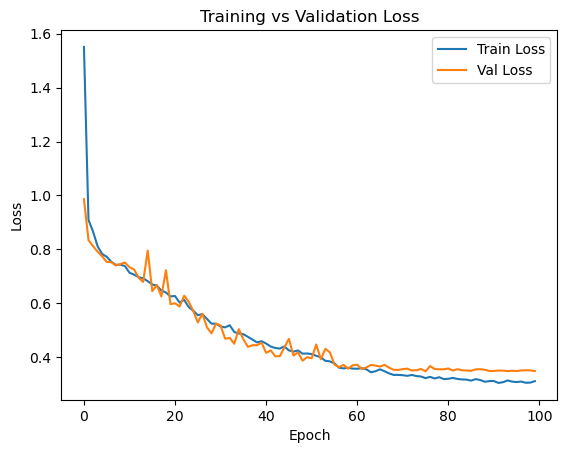

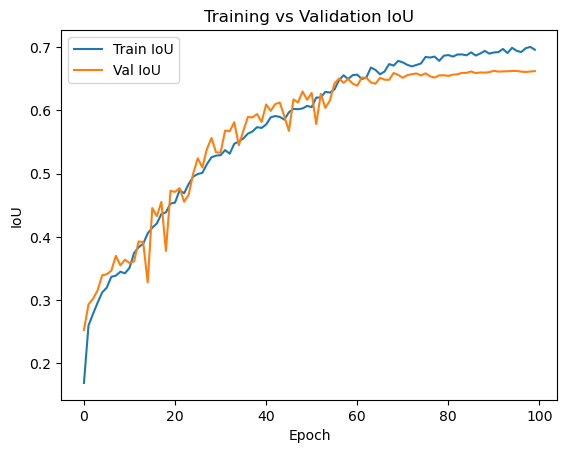

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
from tqdm import tqdm

class BraTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])  
        mask = np.load(self.mask_paths[idx])    
        image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2) 
        mask = torch.tensor(np.argmax(mask, axis=-1), dtype=torch.long)     
        return image, mask

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        num_classes = preds.shape[1]
        preds = torch.softmax(preds, dim=1)
        targets_onehot = F.one_hot(targets, num_classes).permute(0, 4, 1, 2, 3).float()
        intersection = (preds * targets_onehot).sum(dim=(2,3,4))
        union = preds.sum(dim=(2,3,4)) + targets_onehot.sum(dim=(2,3,4))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()


def compute_iou(preds, targets, num_classes=4):
    preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls
        intersection = (pred_inds & target_inds).sum().float()
        union = (pred_inds | target_inds).sum().float()
        if union == 0:
            ious.append(torch.tensor(1.0, device=preds.device))
        else:
            ious.append(intersection / union)
    return torch.mean(torch.stack(ious))


train_dataset = BraTSDataset(
    'BraTS2021_TrainingData_Split/train/images/', 
    'BraTS2021_TrainingData_Split/train/masks/')
val_dataset = BraTSDataset(
    'BraTS2021_TrainingData_Split/val/images/', 
    'BraTS2021_TrainingData_Split/val/masks/')

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet3DWithAttention(in_channels=3, out_classes=4).to(device)

ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss()
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

num_epochs = 100
train_losses, val_losses = [], []
train_ious, val_ious = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_iou = 0, 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += compute_iou(outputs.detach(), masks).item()

    train_loss = total_loss / len(train_loader)
    train_iou = total_iou / len(train_loader)
    train_losses.append(train_loss)
    train_ious.append(train_iou)

    model.eval()
    val_loss, val_iou_total = 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)
            val_loss += loss.item()
            val_iou_total += compute_iou(outputs, masks).item()

    val_loss /= len(val_loader)
    val_iou = val_iou_total / len(val_loader)
    val_losses.append(val_loss)
    val_ious.append(val_iou)

    scheduler.step(val_loss)

    print(
        f"Epoch {epoch+1}: "
          f"Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, "
          f"Train IoU = {train_iou:.4f}, Val IoU = {val_iou:.4f}, "
          f"LR = {optimizer.param_groups[0]['lr']:.2e}")

torch.save(model.state_dict(), 'Attention_LR_100.pth')

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.savefig("loss_plot.png")
plt.show()

plt.figure()
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("Training vs Validation IoU")
plt.legend()
plt.savefig("iou_plot.png")
plt.show()



===== Test Evaluation Summary =====
Mean IoU   : 0.6569
Mean Dice  : 0.7510
Mean HD95  : 25.2423
Mean ASSD  : 0.6235
Skipped samples (empty pred or GT): [66]


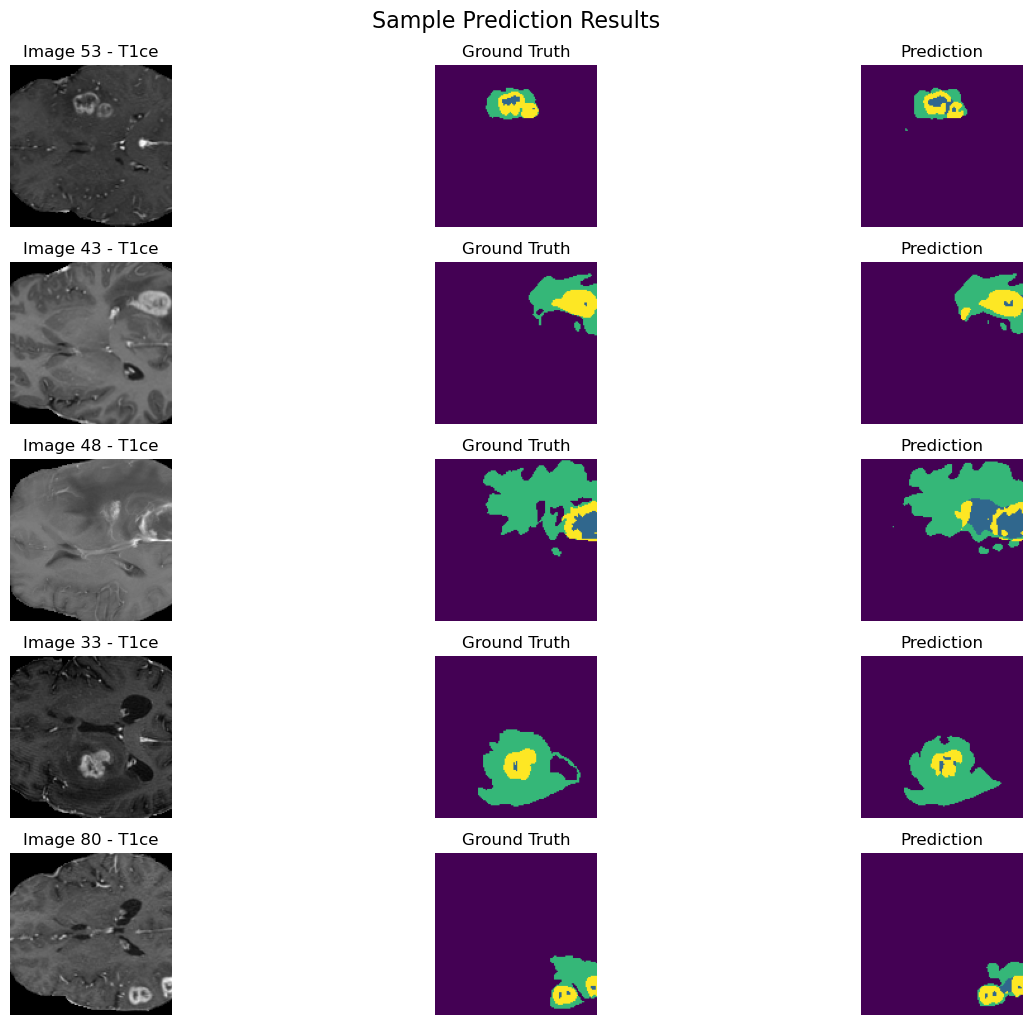

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        mask = np.load(self.mask_paths[idx])
        image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2)  
        mask = torch.tensor(np.argmax(mask, axis=-1), dtype=torch.long)     
        return image, mask

def compute_iou(pred, target, num_classes=4):
    pred, target = pred.view(-1), target.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        ious.append(intersection / union if union != 0 else float('nan'))
    return np.nanmean(ious)

def compute_dice(pred, target, num_classes=4, smooth=1e-5):
    pred, target = pred.view(-1), target.view(-1)
    dices = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item()
        dices.append((2. * intersection + smooth) / (union + smooth) if union != 0 else float('nan'))
    return np.nanmean(dices)

def compute_hd95(pred_np, gt_np):
    pred_itk = sitk.GetImageFromArray(pred_np.astype(np.uint8))
    gt_itk = sitk.GetImageFromArray(gt_np.astype(np.uint8))
    hausdorff = sitk.HausdorffDistanceImageFilter()
    hausdorff.Execute(pred_itk, gt_itk)
    return hausdorff.GetHausdorffDistance(), hausdorff.GetAverageHausdorffDistance()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3DWithAttention(in_channels=3, out_classes=4).to(device)
model.load_state_dict(torch.load("Attention_LR_100.pth", map_location=device))
model.eval()

test_dataset = BraTSDataset('BraTS2021_Testing/images/', 'BraTS2021_Testing/masks/')
ious, dices, hd95s, assds = [], [], [], []
skipped_indices = []

for idx, (image, mask) in enumerate(test_dataset):
    image, mask = image.to(device), mask.to(device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # [1,C,D,H,W]
        pred = output.argmax(dim=1).squeeze(0)  # [D,H,W]

    ious.append(compute_iou(pred, mask))
    dices.append(compute_dice(pred, mask))

    pred_np = pred.cpu().numpy().astype(np.uint8)
    mask_np = mask.cpu().numpy().astype(np.uint8)

    if np.any(pred_np) and np.any(mask_np):
        hd, assd = compute_hd95(pred_np, mask_np)
        hd95s.append(hd)
        assds.append(assd)
    else:
        skipped_indices.append(idx)
        hd95s.append(np.nan)
        assds.append(np.nan)

print(f"\n===== Test Evaluation Summary =====")
print(f"Mean IoU   : {np.nanmean(ious):.4f}")
print(f"Mean Dice  : {np.nanmean(dices):.4f}")
print(f"Mean HD95  : {np.nanmean(hd95s):.4f}")
print(f"Mean ASSD  : {np.nanmean(assds):.4f}")
print(f"Skipped samples (empty pred or GT): {skipped_indices}")


slice_idx = 62
indices_to_plot = [53, 43, 48] + random.sample([i for i in range(len(test_dataset)) if i not in [53,43,48]], 2)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices_to_plot):
    image, mask = test_dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(image[1, :, :, slice_idx], cmap='gray')  
    plt.title(f"Image {idx} - T1ce")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(mask[:, :, slice_idx].cpu())
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 3)
    plt.imshow(pred[:, :, slice_idx])
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Sample Prediction Results", y=1.02, fontsize=16)
plt.show()

Model C

U-Net V2

Also supposed to be a good model

In [ ]:
class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.residual = nn.Conv3d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.residual(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class UNet3DV2(nn.Module):
    def __init__(self, in_channels=3, out_classes=4, base_filters=32):
        super().__init__()
        self.enc1 = ResidualBlock3D(in_channels, base_filters)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ResidualBlock3D(base_filters, base_filters * 2)
        self.pool2 = nn.MaxPool3d(2)
        self.enc3 = ResidualBlock3D(base_filters * 2, base_filters * 4)
        self.pool3 = nn.MaxPool3d(2)
        self.enc4 = ResidualBlock3D(base_filters * 4, base_filters * 8)
        self.pool4 = nn.MaxPool3d(2)

        self.bottleneck = ResidualBlock3D(base_filters * 8, base_filters * 16)

        self.up4 = nn.ConvTranspose3d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.dec4 = ResidualBlock3D(base_filters * 16, base_filters * 8)
        self.up3 = nn.ConvTranspose3d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.dec3 = ResidualBlock3D(base_filters * 8, base_filters * 4)
        self.up2 = nn.ConvTranspose3d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock3D(base_filters * 4, base_filters * 2)
        self.up1 = nn.ConvTranspose3d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock3D(base_filters * 2, base_filters)

        self.out_conv = nn.Conv3d(base_filters, out_classes, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))
        bn = self.bottleneck(self.pool4(e4))

        d4 = self.dec4(torch.cat([self.up4(bn), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.out_conv(d1)

Epoch 1/100: 100%|██████████| 138/138 [01:37<00:00,  1.41it/s]


Epoch 1: Train Loss = 1.4847, Val Loss = 0.9934, Train IoU = 0.2909, Val IoU = 0.3643


Epoch 2/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 2: Train Loss = 0.5961, Val Loss = 0.5779, Train IoU = 0.4854, Val IoU = 0.4871


Epoch 3/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 3: Train Loss = 0.5229, Val Loss = 0.5366, Train IoU = 0.5297, Val IoU = 0.5266


Epoch 4/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 4: Train Loss = 0.4818, Val Loss = 0.5427, Train IoU = 0.5622, Val IoU = 0.5326


Epoch 5/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 5: Train Loss = 0.4458, Val Loss = 0.4527, Train IoU = 0.5892, Val IoU = 0.5851


Epoch 6/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 6: Train Loss = 0.4261, Val Loss = 0.4423, Train IoU = 0.5969, Val IoU = 0.5888


Epoch 7/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 7: Train Loss = 0.4037, Val Loss = 0.4187, Train IoU = 0.6117, Val IoU = 0.6232


Epoch 8/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 8: Train Loss = 0.3870, Val Loss = 0.4138, Train IoU = 0.6268, Val IoU = 0.6210


Epoch 9/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 9: Train Loss = 0.3778, Val Loss = 0.3890, Train IoU = 0.6338, Val IoU = 0.6335


Epoch 10/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 10: Train Loss = 0.3591, Val Loss = 0.4131, Train IoU = 0.6510, Val IoU = 0.6242


Epoch 11/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 11: Train Loss = 0.3435, Val Loss = 0.3829, Train IoU = 0.6629, Val IoU = 0.6331


Epoch 12/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 12: Train Loss = 0.3462, Val Loss = 0.3595, Train IoU = 0.6605, Val IoU = 0.6478


Epoch 13/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 13: Train Loss = 0.3257, Val Loss = 0.3398, Train IoU = 0.6817, Val IoU = 0.6625


Epoch 14/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 14: Train Loss = 0.3182, Val Loss = 0.3459, Train IoU = 0.6884, Val IoU = 0.6566


Epoch 15/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 15: Train Loss = 0.3161, Val Loss = 0.3403, Train IoU = 0.6859, Val IoU = 0.6708


Epoch 16/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 16: Train Loss = 0.3017, Val Loss = 0.3369, Train IoU = 0.7015, Val IoU = 0.6642


Epoch 17/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 17: Train Loss = 0.2967, Val Loss = 0.3320, Train IoU = 0.7021, Val IoU = 0.6683


Epoch 18/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 18: Train Loss = 0.2893, Val Loss = 0.3308, Train IoU = 0.7090, Val IoU = 0.6680


Epoch 19/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 19: Train Loss = 0.2819, Val Loss = 0.3490, Train IoU = 0.7148, Val IoU = 0.6615


Epoch 20/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 20: Train Loss = 0.2786, Val Loss = 0.3084, Train IoU = 0.7193, Val IoU = 0.6871


Epoch 21/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 21: Train Loss = 0.2864, Val Loss = 0.3446, Train IoU = 0.7139, Val IoU = 0.6591


Epoch 22/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 22: Train Loss = 0.2722, Val Loss = 0.3140, Train IoU = 0.7272, Val IoU = 0.6874


Epoch 23/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 23: Train Loss = 0.2727, Val Loss = 0.3226, Train IoU = 0.7219, Val IoU = 0.6795


Epoch 24/100: 100%|██████████| 138/138 [01:35<00:00,  1.44it/s]


Epoch 24: Train Loss = 0.2631, Val Loss = 0.3213, Train IoU = 0.7344, Val IoU = 0.6821


Epoch 25/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 25: Train Loss = 0.2584, Val Loss = 0.3165, Train IoU = 0.7383, Val IoU = 0.6892


Epoch 26/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 26: Train Loss = 0.2618, Val Loss = 0.3096, Train IoU = 0.7341, Val IoU = 0.6872


Epoch 27/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 27: Train Loss = 0.2544, Val Loss = 0.2952, Train IoU = 0.7383, Val IoU = 0.7010


Epoch 28/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 28: Train Loss = 0.2477, Val Loss = 0.3336, Train IoU = 0.7513, Val IoU = 0.6780


Epoch 29/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 29: Train Loss = 0.2407, Val Loss = 0.3302, Train IoU = 0.7554, Val IoU = 0.6810


Epoch 30/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 30: Train Loss = 0.2373, Val Loss = 0.3010, Train IoU = 0.7614, Val IoU = 0.7012


Epoch 31/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 31: Train Loss = 0.2415, Val Loss = 0.3069, Train IoU = 0.7544, Val IoU = 0.6901


Epoch 32/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 32: Train Loss = 0.2377, Val Loss = 0.3163, Train IoU = 0.7597, Val IoU = 0.6947


Epoch 33/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 33: Train Loss = 0.2311, Val Loss = 0.3194, Train IoU = 0.7659, Val IoU = 0.6959


Epoch 34/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 34: Train Loss = 0.2362, Val Loss = 0.3146, Train IoU = 0.7651, Val IoU = 0.6916


Epoch 35/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 35: Train Loss = 0.2273, Val Loss = 0.3164, Train IoU = 0.7693, Val IoU = 0.6944


Epoch 36/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 36: Train Loss = 0.2283, Val Loss = 0.3158, Train IoU = 0.7646, Val IoU = 0.6801


Epoch 37/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 37: Train Loss = 0.2179, Val Loss = 0.3027, Train IoU = 0.7761, Val IoU = 0.7024


Epoch 38/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 38: Train Loss = 0.2138, Val Loss = 0.3074, Train IoU = 0.7806, Val IoU = 0.6994


Epoch 39/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 39: Train Loss = 0.2150, Val Loss = 0.3062, Train IoU = 0.7818, Val IoU = 0.6979


Epoch 40/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 40: Train Loss = 0.2126, Val Loss = 0.3088, Train IoU = 0.7819, Val IoU = 0.6978


Epoch 41/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 41: Train Loss = 0.2077, Val Loss = 0.3057, Train IoU = 0.7824, Val IoU = 0.7032


Epoch 42/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 42: Train Loss = 0.2071, Val Loss = 0.3071, Train IoU = 0.7863, Val IoU = 0.7069


Epoch 43/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 43: Train Loss = 0.2054, Val Loss = 0.3044, Train IoU = 0.7881, Val IoU = 0.6999


Epoch 44/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 44: Train Loss = 0.1986, Val Loss = 0.2992, Train IoU = 0.7951, Val IoU = 0.6989


Epoch 45/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 45: Train Loss = 0.1958, Val Loss = 0.3210, Train IoU = 0.7945, Val IoU = 0.7029


Epoch 46/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 46: Train Loss = 0.1971, Val Loss = 0.3067, Train IoU = 0.7981, Val IoU = 0.7017


Epoch 47/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 47: Train Loss = 0.1909, Val Loss = 0.3029, Train IoU = 0.8046, Val IoU = 0.7019


Epoch 48/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 48: Train Loss = 0.1891, Val Loss = 0.3045, Train IoU = 0.8075, Val IoU = 0.6973


Epoch 49/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 49: Train Loss = 0.1833, Val Loss = 0.2955, Train IoU = 0.8114, Val IoU = 0.7072


Epoch 50/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 50: Train Loss = 0.1831, Val Loss = 0.3003, Train IoU = 0.8093, Val IoU = 0.7011


Epoch 51/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 51: Train Loss = 0.1865, Val Loss = 0.3069, Train IoU = 0.8089, Val IoU = 0.7014


Epoch 52/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 52: Train Loss = 0.1863, Val Loss = 0.3059, Train IoU = 0.8065, Val IoU = 0.7026


Epoch 53/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 53: Train Loss = 0.1843, Val Loss = 0.3057, Train IoU = 0.8101, Val IoU = 0.6998


Epoch 54/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 54: Train Loss = 0.1810, Val Loss = 0.2988, Train IoU = 0.8108, Val IoU = 0.7045


Epoch 55/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 55: Train Loss = 0.1791, Val Loss = 0.3005, Train IoU = 0.8139, Val IoU = 0.7021


Epoch 56/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 56: Train Loss = 0.1749, Val Loss = 0.2957, Train IoU = 0.8166, Val IoU = 0.7059


Epoch 57/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 57: Train Loss = 0.1742, Val Loss = 0.2914, Train IoU = 0.8182, Val IoU = 0.7079


Epoch 58/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 58: Train Loss = 0.1733, Val Loss = 0.3010, Train IoU = 0.8207, Val IoU = 0.7061


Epoch 59/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 59: Train Loss = 0.1682, Val Loss = 0.2951, Train IoU = 0.8269, Val IoU = 0.7074


Epoch 60/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 60: Train Loss = 0.1684, Val Loss = 0.2966, Train IoU = 0.8273, Val IoU = 0.7083


Epoch 61/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 61: Train Loss = 0.1656, Val Loss = 0.3087, Train IoU = 0.8304, Val IoU = 0.7020


Epoch 62/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 62: Train Loss = 0.1643, Val Loss = 0.2909, Train IoU = 0.8284, Val IoU = 0.7137


Epoch 63/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 63: Train Loss = 0.1676, Val Loss = 0.3101, Train IoU = 0.8270, Val IoU = 0.7018


Epoch 64/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 64: Train Loss = 0.1665, Val Loss = 0.2968, Train IoU = 0.8275, Val IoU = 0.7066


Epoch 65/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 65: Train Loss = 0.1654, Val Loss = 0.2947, Train IoU = 0.8287, Val IoU = 0.7103


Epoch 66/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 66: Train Loss = 0.1631, Val Loss = 0.3056, Train IoU = 0.8311, Val IoU = 0.7010


Epoch 67/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 67: Train Loss = 0.1611, Val Loss = 0.2899, Train IoU = 0.8386, Val IoU = 0.7157


Epoch 68/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 68: Train Loss = 0.1593, Val Loss = 0.2923, Train IoU = 0.8363, Val IoU = 0.7120


Epoch 69/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 69: Train Loss = 0.1558, Val Loss = 0.3000, Train IoU = 0.8413, Val IoU = 0.7118


Epoch 70/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 70: Train Loss = 0.1557, Val Loss = 0.2986, Train IoU = 0.8349, Val IoU = 0.7116


Epoch 71/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 71: Train Loss = 0.1561, Val Loss = 0.3022, Train IoU = 0.8407, Val IoU = 0.7064


Epoch 72/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 72: Train Loss = 0.1528, Val Loss = 0.2971, Train IoU = 0.8388, Val IoU = 0.7130


Epoch 73/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 73: Train Loss = 0.1519, Val Loss = 0.3065, Train IoU = 0.8449, Val IoU = 0.6996


Epoch 74/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 74: Train Loss = 0.1528, Val Loss = 0.2961, Train IoU = 0.8424, Val IoU = 0.7148


Epoch 75/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 75: Train Loss = 0.1559, Val Loss = 0.3003, Train IoU = 0.8416, Val IoU = 0.7097


Epoch 76/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 76: Train Loss = 0.1541, Val Loss = 0.3326, Train IoU = 0.8414, Val IoU = 0.6956


Epoch 77/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 77: Train Loss = 0.1540, Val Loss = 0.2967, Train IoU = 0.8401, Val IoU = 0.7112


Epoch 78/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 78: Train Loss = 0.1492, Val Loss = 0.3047, Train IoU = 0.8433, Val IoU = 0.7132


Epoch 79/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 79: Train Loss = 0.1483, Val Loss = 0.2939, Train IoU = 0.8468, Val IoU = 0.7160


Epoch 80/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 80: Train Loss = 0.1479, Val Loss = 0.3009, Train IoU = 0.8451, Val IoU = 0.7119


Epoch 81/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 81: Train Loss = 0.1472, Val Loss = 0.3119, Train IoU = 0.8458, Val IoU = 0.7057


Epoch 82/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 82: Train Loss = 0.1444, Val Loss = 0.2857, Train IoU = 0.8527, Val IoU = 0.7199


Epoch 83/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 83: Train Loss = 0.1476, Val Loss = 0.2933, Train IoU = 0.8487, Val IoU = 0.7176


Epoch 84/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 84: Train Loss = 0.1468, Val Loss = 0.2986, Train IoU = 0.8456, Val IoU = 0.7097


Epoch 85/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 85: Train Loss = 0.1461, Val Loss = 0.3054, Train IoU = 0.8516, Val IoU = 0.7100


Epoch 86/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 86: Train Loss = 0.1432, Val Loss = 0.3092, Train IoU = 0.8511, Val IoU = 0.7020


Epoch 87/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 87: Train Loss = 0.1404, Val Loss = 0.2946, Train IoU = 0.8551, Val IoU = 0.7136


Epoch 88/100: 100%|██████████| 138/138 [01:34<00:00,  1.45it/s]


Epoch 88: Train Loss = 0.1412, Val Loss = 0.3054, Train IoU = 0.8541, Val IoU = 0.7151


Epoch 89/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 89: Train Loss = 0.1408, Val Loss = 0.3003, Train IoU = 0.8593, Val IoU = 0.7130


Epoch 90/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 90: Train Loss = 0.1374, Val Loss = 0.3065, Train IoU = 0.8612, Val IoU = 0.7101


Epoch 91/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 91: Train Loss = 0.1404, Val Loss = 0.2993, Train IoU = 0.8561, Val IoU = 0.7094


Epoch 92/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 92: Train Loss = 0.1393, Val Loss = 0.3010, Train IoU = 0.8545, Val IoU = 0.7081


Epoch 93/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 93: Train Loss = 0.1369, Val Loss = 0.2950, Train IoU = 0.8591, Val IoU = 0.7152


Epoch 94/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 94: Train Loss = 0.1330, Val Loss = 0.2935, Train IoU = 0.8620, Val IoU = 0.7170


Epoch 95/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 95: Train Loss = 0.1333, Val Loss = 0.2995, Train IoU = 0.8641, Val IoU = 0.7115


Epoch 96/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 96: Train Loss = 0.1336, Val Loss = 0.2993, Train IoU = 0.8644, Val IoU = 0.7126


Epoch 97/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 97: Train Loss = 0.1352, Val Loss = 0.3002, Train IoU = 0.8578, Val IoU = 0.7142


Epoch 98/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 98: Train Loss = 0.1351, Val Loss = 0.3042, Train IoU = 0.8607, Val IoU = 0.7114


Epoch 99/100: 100%|██████████| 138/138 [01:34<00:00,  1.46it/s]


Epoch 99: Train Loss = 0.1319, Val Loss = 0.3004, Train IoU = 0.8662, Val IoU = 0.7138


Epoch 100/100: 100%|██████████| 138/138 [01:35<00:00,  1.45it/s]


Epoch 100: Train Loss = 0.1295, Val Loss = 0.2964, Train IoU = 0.8640, Val IoU = 0.7182


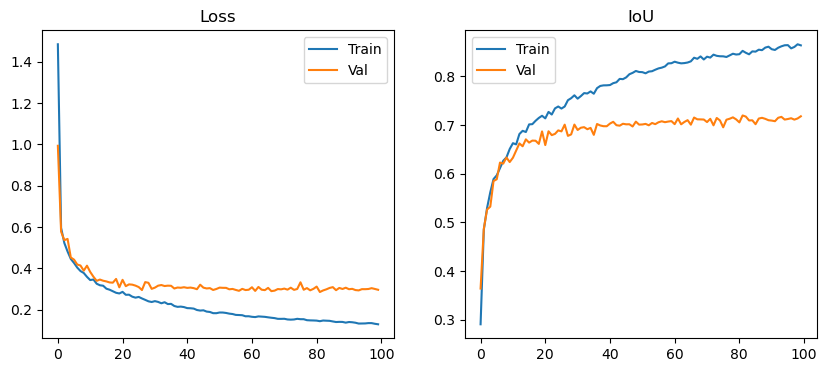

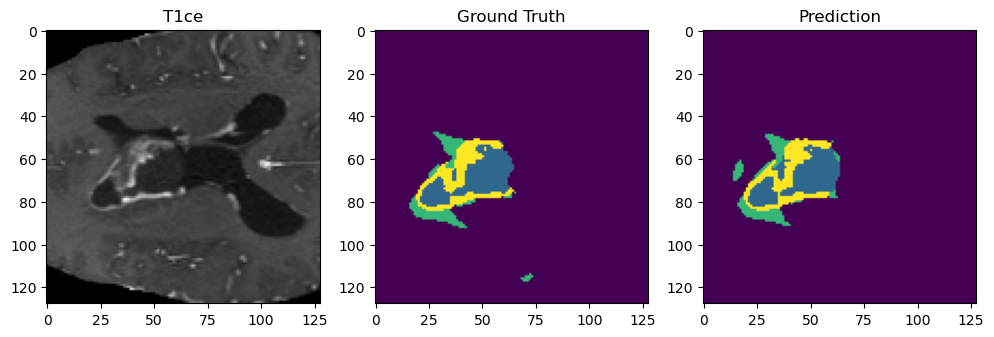

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        num_classes = preds.shape[1]
        preds = torch.softmax(preds, dim=1)
        targets_onehot = F.one_hot(targets, num_classes).permute(0, 4, 1, 2, 3).float()
        intersection = (preds * targets_onehot).sum(dim=(2,3,4))
        union = preds.sum(dim=(2,3,4)) + targets_onehot.sum(dim=(2,3,4))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

def compute_iou(preds, targets, num_classes=4):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        target_inds = (targets == cls)
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)

class BraTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        mask = np.load(self.mask_paths[idx])
        image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2)
        mask = torch.tensor(np.argmax(mask, axis=-1), dtype=torch.long)
        return image, mask

train_dataset = BraTSDataset('BraTS2021_TrainingData_Split/train/images/', 'BraTS2021_TrainingData_Split/train/masks/')
val_dataset = BraTSDataset('BraTS2021_TrainingData_Split/val/images/', 'BraTS2021_TrainingData_Split/val/masks/')
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3DV2(in_channels=3, out_classes=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss()

train_losses, val_losses, train_ious, val_ious = [], [], [], []
epochs = 100

for epoch in range(epochs):
    model.train()
    total_loss, total_iou = 0, 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += compute_iou(outputs, masks)

    train_losses.append(total_loss / len(train_loader))
    train_ious.append(total_iou / len(train_loader))

    model.eval()
    val_loss, val_iou = 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)
            val_loss += loss.item()
            val_iou += compute_iou(outputs, masks)

    val_losses.append(val_loss / len(val_loader))
    val_ious.append(val_iou / len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}, Train IoU = {train_ious[-1]:.4f}, Val IoU = {val_ious[-1]:.4f}")

torch.save(model.state_dict(), "UNET_V2_100.pth")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_ious, label="Train")
plt.plot(val_ious, label="Val")
plt.title("IoU")
plt.legend()
plt.show()


===== Test Evaluation Summary =====
Mean IoU   : 0.7434
Mean Dice  : 0.8212
Mean HD95  : 30.4309
Mean ASSD  : 0.3999


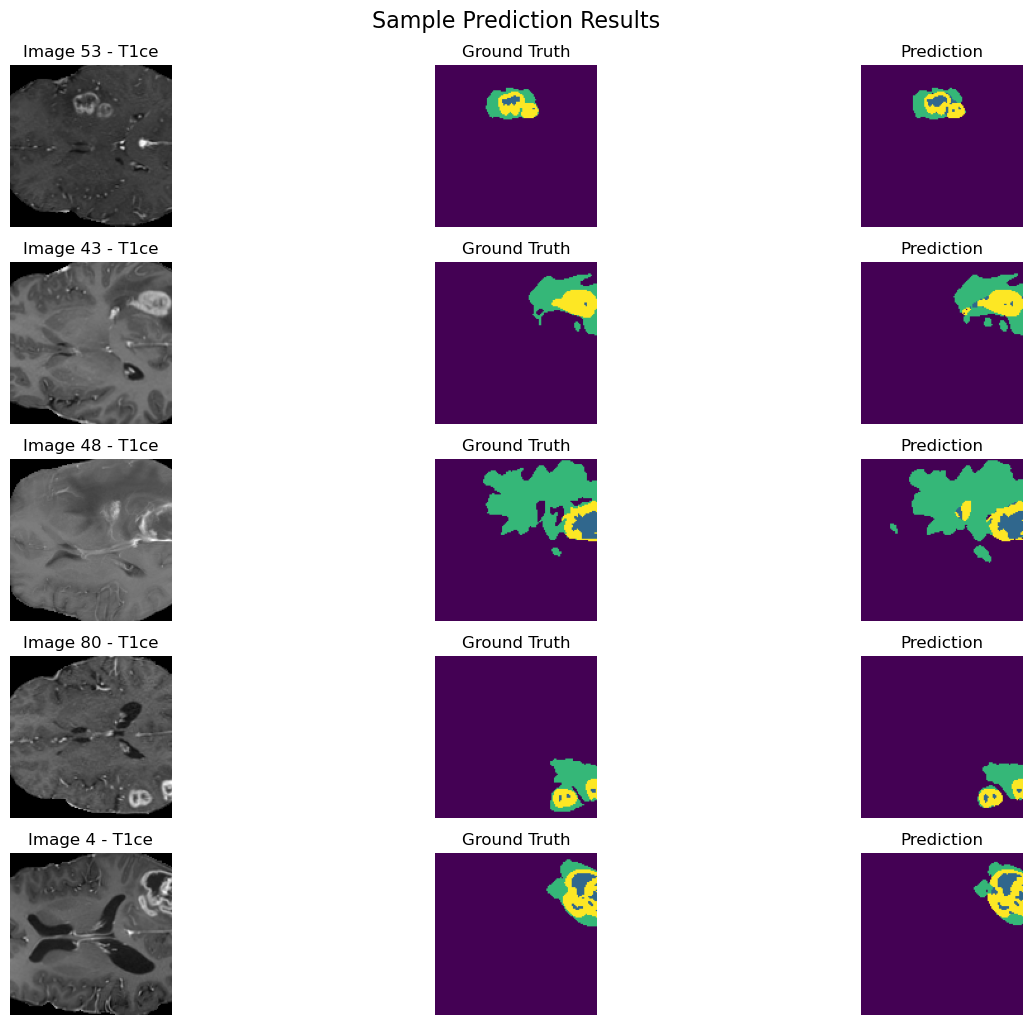

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        mask = np.load(self.mask_paths[idx])
        image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2)  # [C,D,H,W]
        mask = torch.tensor(np.argmax(mask, axis=-1), dtype=torch.long)      # [D,H,W]
        return image, mask

def compute_iou(pred, target, num_classes=4):
    pred, target = pred.view(-1), target.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        ious.append(intersection / union if union != 0 else float('nan'))
    return np.nanmean(ious)

def compute_dice(pred, target, num_classes=4, smooth=1e-5):
    pred, target = pred.view(-1), target.view(-1)
    dices = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item()
        dices.append((2. * intersection + smooth) / (union + smooth) if union != 0 else float('nan'))
    return np.nanmean(dices)

def compute_hd95(pred_np, gt_np):
    pred_itk = sitk.GetImageFromArray(pred_np.astype(np.uint8))
    gt_itk = sitk.GetImageFromArray(gt_np.astype(np.uint8))
    hausdorff = sitk.HausdorffDistanceImageFilter()
    hausdorff.Execute(pred_itk, gt_itk)
    return hausdorff.GetHausdorffDistance(), hausdorff.GetAverageHausdorffDistance()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3DV2(in_channels=3, out_classes=4).to(device)
model.load_state_dict(torch.load("UNET_V2_100.pth", map_location=device))
model.eval()

test_dataset = BraTSDataset('BraTS2021_Testing/images/', 'BraTS2021_Testing/masks/')
ious, dices, hd95s, assds = [], [], [], []

for image, mask in test_dataset:
    image, mask = image.to(device), mask.to(device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # [1,C,D,H,W]
        pred = output.argmax(dim=1).squeeze(0)  # [D,H,W]

    ious.append(compute_iou(pred, mask))
    dices.append(compute_dice(pred, mask))
    hd, assd = compute_hd95(pred.cpu().numpy(), mask.cpu().numpy())
    hd95s.append(hd)
    assds.append(assd)

print(f"\n===== Test Evaluation Summary =====")
print(f"Mean IoU   : {np.nanmean(ious):.4f}")
print(f"Mean Dice  : {np.nanmean(dices):.4f}")
print(f"Mean HD95  : {np.nanmean(hd95s):.4f}")
print(f"Mean ASSD  : {np.nanmean(assds):.4f}")

slice_idx = 62
indices_to_plot = [53, 43, 48] + random.sample([i for i in range(len(test_dataset)) if i not in [53,43,48]], 2)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices_to_plot):
    image, mask = test_dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(image[1, :, :, slice_idx], cmap='gray')  # T1ce channel
    plt.title(f"Image {idx} - T1ce")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(mask[:, :, slice_idx].cpu())
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 3)
    plt.imshow(pred[:, :, slice_idx])
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Sample Prediction Results", y=1.02, fontsize=16)
plt.show()

Model D

Batch Normalization


In [27]:
class UNet3D_BatchNorm(nn.Module):
    def __init__(self, in_channels=3, out_classes=4, base_filters=16):
        super(UNet3D_BatchNorm, self).__init__()

        self.encoder1 = self.conv_block(in_channels, base_filters)
        self.pool1 = nn.MaxPool3d(2)

        self.encoder2 = self.conv_block(base_filters, base_filters * 2)
        self.pool2 = nn.MaxPool3d(2)

        self.encoder3 = self.conv_block(base_filters * 2, base_filters * 4)
        self.pool3 = nn.MaxPool3d(2)

        self.encoder4 = self.conv_block(base_filters * 4, base_filters * 8)
        self.pool4 = nn.MaxPool3d(2)

        self.bottleneck = self.conv_block(base_filters * 8, base_filters * 16)

        self.upconv4 = nn.ConvTranspose3d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(base_filters * 16, base_filters * 8)

        self.upconv3 = nn.ConvTranspose3d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(base_filters * 8, base_filters * 4)

        self.upconv2 = nn.ConvTranspose3d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(base_filters * 4, base_filters * 2)

        self.upconv1 = nn.ConvTranspose3d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(base_filters * 2, base_filters)

        self.out_conv = nn.Conv3d(base_filters, out_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(0.1 if out_channels <= 32 else 0.2 if out_channels <= 128 else 0.3),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        c1 = self.encoder1(x)
        p1 = self.pool1(c1)

        c2 = self.encoder2(p1)
        p2 = self.pool2(c2)

        c3 = self.encoder3(p2)
        p3 = self.pool3(c3)

        c4 = self.encoder4(p3)
        p4 = self.pool4(c4)

        bn = self.bottleneck(p4)

        u4 = self.upconv4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        d4 = self.decoder4(u4)

        u3 = self.upconv3(d4)
        u3 = torch.cat([u3, c3], dim=1)
        d3 = self.decoder3(u3)

        u2 = self.upconv2(d3)
        u2 = torch.cat([u2, c2], dim=1)
        d2 = self.decoder2(u2)

        u1 = self.upconv1(d2)
        u1 = torch.cat([u1, c1], dim=1)
        d1 = self.decoder1(u1)

        out = self.out_conv(d1)
        return out

Epoch 1/100: 100%|██████████| 138/138 [01:29<00:00,  1.53it/s]


Epoch 1: Train Loss = 2.1941, Val Loss = 2.0344, Train IoU = 0.1724, Val IoU = 0.2731


Epoch 2/100: 100%|██████████| 138/138 [01:21<00:00,  1.69it/s]


Epoch 2: Train Loss = 1.9494, Val Loss = 1.8664, Train IoU = 0.2881, Val IoU = 0.3078


Epoch 3/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 3: Train Loss = 1.8197, Val Loss = 1.7952, Train IoU = 0.3162, Val IoU = 0.3321


Epoch 4/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 4: Train Loss = 1.7057, Val Loss = 1.6403, Train IoU = 0.3410, Val IoU = 0.3487


Epoch 5/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 5: Train Loss = 1.6011, Val Loss = 1.5462, Train IoU = 0.3605, Val IoU = 0.3658


Epoch 6/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 6: Train Loss = 1.5015, Val Loss = 1.4561, Train IoU = 0.3830, Val IoU = 0.4078


Epoch 7/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 7: Train Loss = 1.4089, Val Loss = 1.3579, Train IoU = 0.3836, Val IoU = 0.4120


Epoch 8/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 8: Train Loss = 1.3184, Val Loss = 1.2663, Train IoU = 0.4032, Val IoU = 0.4148


Epoch 9/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 9: Train Loss = 1.2334, Val Loss = 1.1910, Train IoU = 0.4165, Val IoU = 0.4142


Epoch 10/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 10: Train Loss = 1.1582, Val Loss = 1.1108, Train IoU = 0.4154, Val IoU = 0.4143


Epoch 11/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 11: Train Loss = 1.0810, Val Loss = 1.0170, Train IoU = 0.4154, Val IoU = 0.4288


Epoch 12/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 12: Train Loss = 1.0160, Val Loss = 0.9842, Train IoU = 0.4240, Val IoU = 0.4292


Epoch 13/100: 100%|██████████| 138/138 [01:22<00:00,  1.68it/s]


Epoch 13: Train Loss = 0.9573, Val Loss = 0.9366, Train IoU = 0.4302, Val IoU = 0.4273


Epoch 14/100: 100%|██████████| 138/138 [01:21<00:00,  1.68it/s]


Epoch 14: Train Loss = 0.9087, Val Loss = 0.8717, Train IoU = 0.4362, Val IoU = 0.4367


Epoch 15/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 15: Train Loss = 0.8606, Val Loss = 0.8269, Train IoU = 0.4481, Val IoU = 0.4482


Epoch 16/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 16: Train Loss = 0.8206, Val Loss = 0.7884, Train IoU = 0.4650, Val IoU = 0.5044


Epoch 17/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 17: Train Loss = 0.7843, Val Loss = 0.7561, Train IoU = 0.5195, Val IoU = 0.5358


Epoch 18/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 18: Train Loss = 0.7427, Val Loss = 0.6957, Train IoU = 0.5500, Val IoU = 0.5875


Epoch 19/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 19: Train Loss = 0.7025, Val Loss = 0.6721, Train IoU = 0.5723, Val IoU = 0.5639


Epoch 20/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 20: Train Loss = 0.6665, Val Loss = 0.6135, Train IoU = 0.5799, Val IoU = 0.6134


Epoch 21/100: 100%|██████████| 138/138 [01:22<00:00,  1.68it/s]


Epoch 21: Train Loss = 0.6270, Val Loss = 0.6170, Train IoU = 0.6000, Val IoU = 0.5971


Epoch 22/100: 100%|██████████| 138/138 [01:22<00:00,  1.68it/s]


Epoch 22: Train Loss = 0.6013, Val Loss = 0.5555, Train IoU = 0.6013, Val IoU = 0.6189


Epoch 23/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 23: Train Loss = 0.5785, Val Loss = 0.5249, Train IoU = 0.6060, Val IoU = 0.6233


Epoch 24/100: 100%|██████████| 138/138 [01:22<00:00,  1.68it/s]


Epoch 24: Train Loss = 0.5529, Val Loss = 0.5114, Train IoU = 0.6120, Val IoU = 0.6330


Epoch 25/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 25: Train Loss = 0.5232, Val Loss = 0.4992, Train IoU = 0.6265, Val IoU = 0.6219


Epoch 26/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 26: Train Loss = 0.5087, Val Loss = 0.4835, Train IoU = 0.6270, Val IoU = 0.6326


Epoch 27/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 27: Train Loss = 0.4901, Val Loss = 0.4477, Train IoU = 0.6316, Val IoU = 0.6520


Epoch 28/100: 100%|██████████| 138/138 [01:22<00:00,  1.68it/s]


Epoch 28: Train Loss = 0.4641, Val Loss = 0.4339, Train IoU = 0.6430, Val IoU = 0.6474


Epoch 29/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 29: Train Loss = 0.4453, Val Loss = 0.4154, Train IoU = 0.6515, Val IoU = 0.6582


Epoch 30/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 30: Train Loss = 0.4428, Val Loss = 0.4125, Train IoU = 0.6445, Val IoU = 0.6555


Epoch 31/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 31: Train Loss = 0.4272, Val Loss = 0.4169, Train IoU = 0.6497, Val IoU = 0.6555


Epoch 32/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 32: Train Loss = 0.4118, Val Loss = 0.3831, Train IoU = 0.6619, Val IoU = 0.6653


Epoch 33/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 33: Train Loss = 0.3974, Val Loss = 0.3756, Train IoU = 0.6630, Val IoU = 0.6612


Epoch 34/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 34: Train Loss = 0.3925, Val Loss = 0.3814, Train IoU = 0.6691, Val IoU = 0.6641


Epoch 35/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 35: Train Loss = 0.3888, Val Loss = 0.3772, Train IoU = 0.6682, Val IoU = 0.6465


Epoch 36/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 36: Train Loss = 0.3828, Val Loss = 0.3555, Train IoU = 0.6677, Val IoU = 0.6729


Epoch 37/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 37: Train Loss = 0.3673, Val Loss = 0.3587, Train IoU = 0.6757, Val IoU = 0.6675


Epoch 38/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 38: Train Loss = 0.3567, Val Loss = 0.3443, Train IoU = 0.6840, Val IoU = 0.6787


Epoch 39/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 39: Train Loss = 0.3539, Val Loss = 0.3404, Train IoU = 0.6815, Val IoU = 0.6707


Epoch 40/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 40: Train Loss = 0.3507, Val Loss = 0.3424, Train IoU = 0.6876, Val IoU = 0.6746


Epoch 41/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 41: Train Loss = 0.3412, Val Loss = 0.3239, Train IoU = 0.6908, Val IoU = 0.6863


Epoch 42/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 42: Train Loss = 0.3404, Val Loss = 0.3330, Train IoU = 0.6895, Val IoU = 0.6843


Epoch 43/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 43: Train Loss = 0.3348, Val Loss = 0.3207, Train IoU = 0.6941, Val IoU = 0.6887


Epoch 44/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 44: Train Loss = 0.3230, Val Loss = 0.3345, Train IoU = 0.7033, Val IoU = 0.6828


Epoch 45/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 45: Train Loss = 0.3226, Val Loss = 0.3203, Train IoU = 0.7013, Val IoU = 0.6854


Epoch 46/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 46: Train Loss = 0.3288, Val Loss = 0.3295, Train IoU = 0.6953, Val IoU = 0.6757


Epoch 47/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 47: Train Loss = 0.3193, Val Loss = 0.3142, Train IoU = 0.7049, Val IoU = 0.6929


Epoch 48/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 48: Train Loss = 0.3086, Val Loss = 0.3153, Train IoU = 0.7084, Val IoU = 0.6901


Epoch 49/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 49: Train Loss = 0.3107, Val Loss = 0.3170, Train IoU = 0.7045, Val IoU = 0.6912


Epoch 50/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 50: Train Loss = 0.3093, Val Loss = 0.3121, Train IoU = 0.7070, Val IoU = 0.6837


Epoch 51/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 51: Train Loss = 0.3050, Val Loss = 0.3104, Train IoU = 0.7141, Val IoU = 0.6976


Epoch 52/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 52: Train Loss = 0.3079, Val Loss = 0.2989, Train IoU = 0.7129, Val IoU = 0.6997


Epoch 53/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 53: Train Loss = 0.2996, Val Loss = 0.3071, Train IoU = 0.7156, Val IoU = 0.6949


Epoch 54/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 54: Train Loss = 0.3024, Val Loss = 0.3064, Train IoU = 0.7130, Val IoU = 0.6996


Epoch 55/100: 100%|██████████| 138/138 [01:22<00:00,  1.68it/s]


Epoch 55: Train Loss = 0.2944, Val Loss = 0.2966, Train IoU = 0.7147, Val IoU = 0.7028


Epoch 56/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 56: Train Loss = 0.2871, Val Loss = 0.2967, Train IoU = 0.7287, Val IoU = 0.6980


Epoch 57/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 57: Train Loss = 0.2891, Val Loss = 0.3124, Train IoU = 0.7257, Val IoU = 0.6834


Epoch 58/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 58: Train Loss = 0.2850, Val Loss = 0.2952, Train IoU = 0.7231, Val IoU = 0.7025


Epoch 59/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 59: Train Loss = 0.2810, Val Loss = 0.2965, Train IoU = 0.7239, Val IoU = 0.7000


Epoch 60/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 60: Train Loss = 0.2862, Val Loss = 0.2981, Train IoU = 0.7269, Val IoU = 0.6931


Epoch 61/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 61: Train Loss = 0.2839, Val Loss = 0.2975, Train IoU = 0.7227, Val IoU = 0.6990


Epoch 62/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 62: Train Loss = 0.2795, Val Loss = 0.2926, Train IoU = 0.7333, Val IoU = 0.7030


Epoch 63/100: 100%|██████████| 138/138 [01:22<00:00,  1.68it/s]


Epoch 63: Train Loss = 0.2729, Val Loss = 0.2926, Train IoU = 0.7412, Val IoU = 0.7071


Epoch 64/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 64: Train Loss = 0.2752, Val Loss = 0.2873, Train IoU = 0.7402, Val IoU = 0.7059


Epoch 65/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 65: Train Loss = 0.2725, Val Loss = 0.3028, Train IoU = 0.7341, Val IoU = 0.6928


Epoch 66/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 66: Train Loss = 0.2652, Val Loss = 0.2947, Train IoU = 0.7427, Val IoU = 0.7073


Epoch 67/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 67: Train Loss = 0.2691, Val Loss = 0.2987, Train IoU = 0.7333, Val IoU = 0.6932


Epoch 68/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 68: Train Loss = 0.2736, Val Loss = 0.3002, Train IoU = 0.7313, Val IoU = 0.6904


Epoch 69/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 69: Train Loss = 0.2648, Val Loss = 0.2975, Train IoU = 0.7344, Val IoU = 0.6999


Epoch 70/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 70: Train Loss = 0.2608, Val Loss = 0.2893, Train IoU = 0.7382, Val IoU = 0.7073


Epoch 71/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 71: Train Loss = 0.2655, Val Loss = 0.2953, Train IoU = 0.7436, Val IoU = 0.7090


Epoch 72/100: 100%|██████████| 138/138 [01:21<00:00,  1.69it/s]


Epoch 72: Train Loss = 0.2641, Val Loss = 0.3079, Train IoU = 0.7432, Val IoU = 0.6903


Epoch 73/100: 100%|██████████| 138/138 [01:21<00:00,  1.69it/s]


Epoch 73: Train Loss = 0.2635, Val Loss = 0.2898, Train IoU = 0.7389, Val IoU = 0.7085


Epoch 74/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 74: Train Loss = 0.2613, Val Loss = 0.2912, Train IoU = 0.7446, Val IoU = 0.7052


Epoch 75/100: 100%|██████████| 138/138 [01:22<00:00,  1.68it/s]


Epoch 75: Train Loss = 0.2600, Val Loss = 0.2974, Train IoU = 0.7429, Val IoU = 0.6984


Epoch 76/100: 100%|██████████| 138/138 [01:25<00:00,  1.62it/s]


Epoch 76: Train Loss = 0.2585, Val Loss = 0.2861, Train IoU = 0.7444, Val IoU = 0.7109


Epoch 77/100: 100%|██████████| 138/138 [01:21<00:00,  1.68it/s]


Epoch 77: Train Loss = 0.2560, Val Loss = 0.2992, Train IoU = 0.7500, Val IoU = 0.7029


Epoch 78/100: 100%|██████████| 138/138 [01:22<00:00,  1.68it/s]


Epoch 78: Train Loss = 0.2533, Val Loss = 0.2867, Train IoU = 0.7484, Val IoU = 0.7081


Epoch 79/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 79: Train Loss = 0.2483, Val Loss = 0.3004, Train IoU = 0.7531, Val IoU = 0.7030


Epoch 80/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 80: Train Loss = 0.2497, Val Loss = 0.2900, Train IoU = 0.7509, Val IoU = 0.7069


Epoch 81/100: 100%|██████████| 138/138 [01:22<00:00,  1.68it/s]


Epoch 81: Train Loss = 0.2517, Val Loss = 0.2834, Train IoU = 0.7475, Val IoU = 0.7154


Epoch 82/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 82: Train Loss = 0.2438, Val Loss = 0.2939, Train IoU = 0.7575, Val IoU = 0.7130


Epoch 83/100: 100%|██████████| 138/138 [01:21<00:00,  1.69it/s]


Epoch 83: Train Loss = 0.2510, Val Loss = 0.2887, Train IoU = 0.7517, Val IoU = 0.7148


Epoch 84/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 84: Train Loss = 0.2514, Val Loss = 0.3009, Train IoU = 0.7531, Val IoU = 0.7041


Epoch 85/100: 100%|██████████| 138/138 [01:22<00:00,  1.68it/s]


Epoch 85: Train Loss = 0.2485, Val Loss = 0.2962, Train IoU = 0.7505, Val IoU = 0.6993


Epoch 86/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 86: Train Loss = 0.2548, Val Loss = 0.2833, Train IoU = 0.7472, Val IoU = 0.7136


Epoch 87/100: 100%|██████████| 138/138 [01:26<00:00,  1.60it/s]


Epoch 87: Train Loss = 0.2471, Val Loss = 0.3013, Train IoU = 0.7565, Val IoU = 0.6958


Epoch 88/100: 100%|██████████| 138/138 [01:26<00:00,  1.59it/s]


Epoch 88: Train Loss = 0.2561, Val Loss = 0.2854, Train IoU = 0.7505, Val IoU = 0.7080


Epoch 89/100: 100%|██████████| 138/138 [01:26<00:00,  1.60it/s]


Epoch 89: Train Loss = 0.2444, Val Loss = 0.2871, Train IoU = 0.7558, Val IoU = 0.7163


Epoch 90/100: 100%|██████████| 138/138 [01:25<00:00,  1.61it/s]


Epoch 90: Train Loss = 0.2403, Val Loss = 0.2780, Train IoU = 0.7616, Val IoU = 0.7174


Epoch 91/100: 100%|██████████| 138/138 [01:25<00:00,  1.61it/s]


Epoch 91: Train Loss = 0.2370, Val Loss = 0.2820, Train IoU = 0.7644, Val IoU = 0.7138


Epoch 92/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 92: Train Loss = 0.2451, Val Loss = 0.2908, Train IoU = 0.7570, Val IoU = 0.7089


Epoch 93/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 93: Train Loss = 0.2375, Val Loss = 0.2926, Train IoU = 0.7657, Val IoU = 0.7149


Epoch 94/100: 100%|██████████| 138/138 [01:23<00:00,  1.64it/s]


Epoch 94: Train Loss = 0.2354, Val Loss = 0.2930, Train IoU = 0.7625, Val IoU = 0.7092


Epoch 95/100: 100%|██████████| 138/138 [01:25<00:00,  1.62it/s]


Epoch 95: Train Loss = 0.2363, Val Loss = 0.2990, Train IoU = 0.7663, Val IoU = 0.7101


Epoch 96/100: 100%|██████████| 138/138 [01:25<00:00,  1.62it/s]


Epoch 96: Train Loss = 0.2356, Val Loss = 0.2989, Train IoU = 0.7612, Val IoU = 0.7125


Epoch 97/100: 100%|██████████| 138/138 [01:22<00:00,  1.66it/s]


Epoch 97: Train Loss = 0.2379, Val Loss = 0.2883, Train IoU = 0.7648, Val IoU = 0.7093


Epoch 98/100: 100%|██████████| 138/138 [01:22<00:00,  1.68it/s]


Epoch 98: Train Loss = 0.2370, Val Loss = 0.2860, Train IoU = 0.7641, Val IoU = 0.7161


Epoch 99/100: 100%|██████████| 138/138 [01:22<00:00,  1.67it/s]


Epoch 99: Train Loss = 0.2334, Val Loss = 0.2913, Train IoU = 0.7683, Val IoU = 0.7101


Epoch 100/100: 100%|██████████| 138/138 [01:23<00:00,  1.66it/s]


Epoch 100: Train Loss = 0.2361, Val Loss = 0.2853, Train IoU = 0.7666, Val IoU = 0.7100


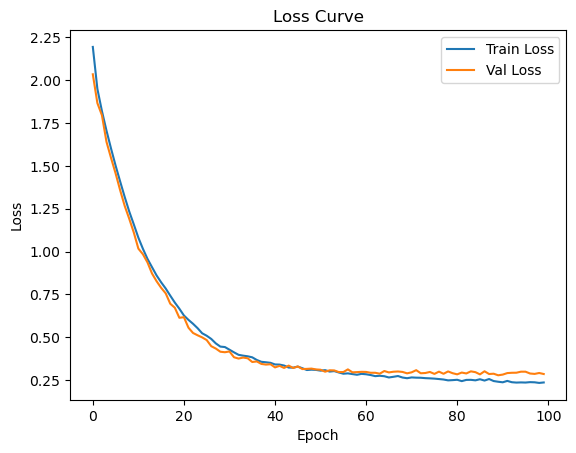

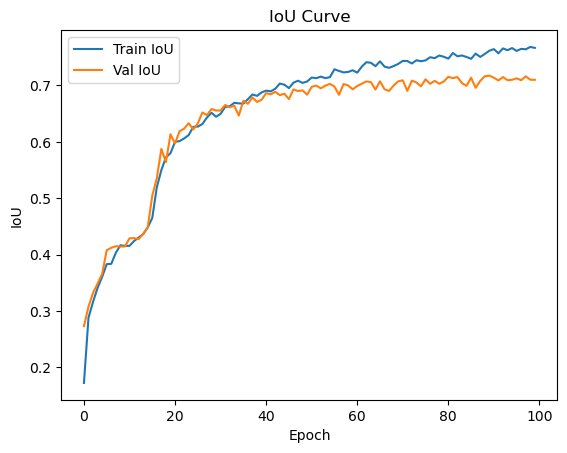

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        num_classes = preds.shape[1]
        preds = torch.softmax(preds, dim=1)
        targets_onehot = F.one_hot(targets, num_classes).permute(0, 4, 1, 2, 3).float()
        intersection = (preds * targets_onehot).sum(dim=(2,3,4))
        union = preds.sum(dim=(2,3,4)) + targets_onehot.sum(dim=(2,3,4))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

def compute_iou(pred, target, num_classes=4):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan')) 
        else:
            ious.append(intersection / union)
    return torch.tensor(ious).nanmean().item()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet3D_BatchNorm(in_channels=3, out_classes=4).to(device)

ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

num_epochs = 100
train_losses, val_losses, train_ious, val_ious = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_iou = 0, 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iou += compute_iou(outputs.argmax(1), masks)

    train_losses.append(total_loss / len(train_loader))
    train_ious.append(total_iou / len(train_loader))

    model.eval()
    val_loss, val_iou = 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)
            val_loss += loss.item()
            val_iou += compute_iou(outputs.argmax(1), masks)

    val_losses.append(val_loss / len(val_loader))
    val_ious.append(val_iou / len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}, "
          f"Train IoU = {train_ious[-1]:.4f}, Val IoU = {val_ious[-1]:.4f}")

torch.save(model.state_dict(), "BatchNorm_100.pth")

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.title("IoU Curve")
plt.show()


===== Test Evaluation Summary =====
Mean IoU   : 0.7344
Mean Dice  : 0.8145
Mean HD95  : 24.9849
Mean ASSD  : 0.5035


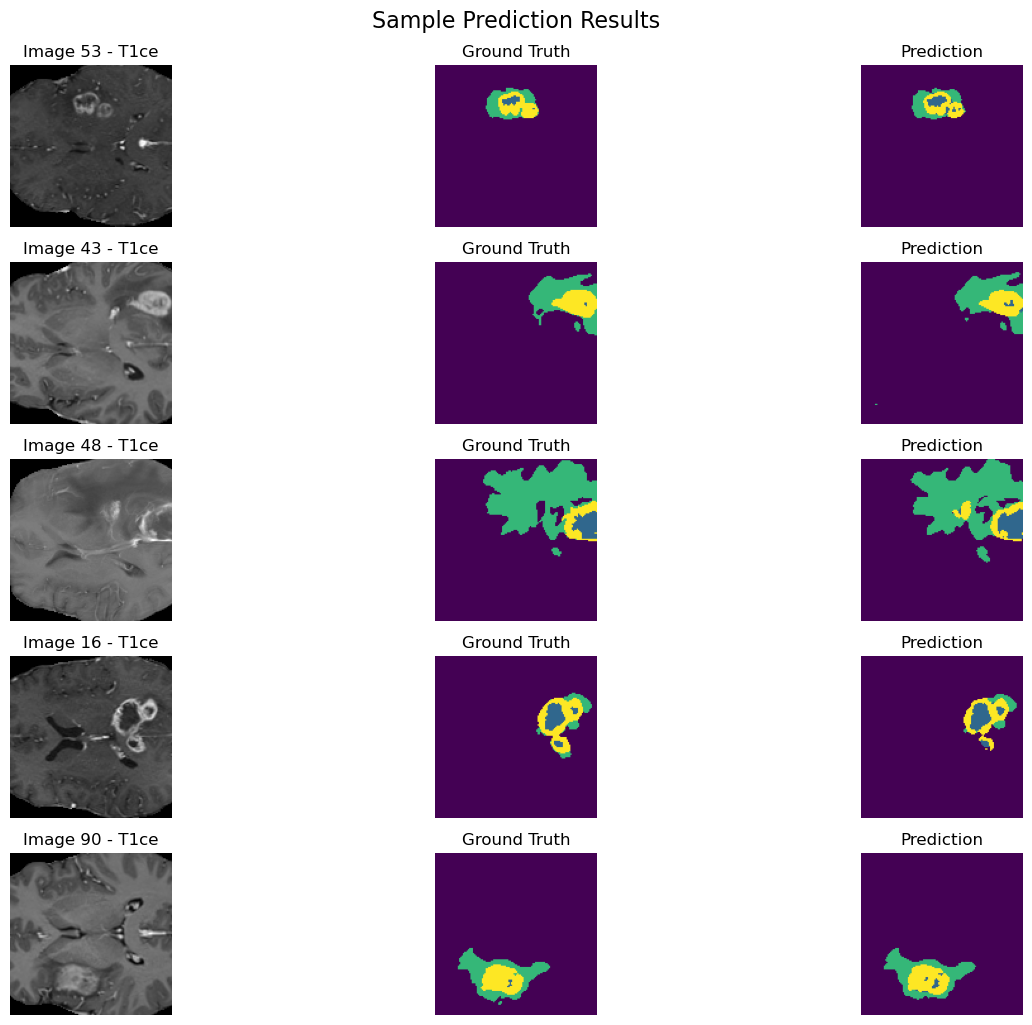

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        mask = np.load(self.mask_paths[idx])
        image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2)  
        mask = torch.tensor(np.argmax(mask, axis=-1), dtype=torch.long)     
        return image, mask

def compute_iou(pred, target, num_classes=4):
    pred, target = pred.view(-1), target.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        ious.append(intersection / union if union != 0 else float('nan'))
    return np.nanmean(ious)

def compute_dice(pred, target, num_classes=4, smooth=1e-5):
    pred, target = pred.view(-1), target.view(-1)
    dices = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item()
        dices.append((2. * intersection + smooth) / (union + smooth) if union != 0 else float('nan'))
    return np.nanmean(dices)

def compute_hd95(pred_np, gt_np):
    pred_itk = sitk.GetImageFromArray(pred_np.astype(np.uint8))
    gt_itk = sitk.GetImageFromArray(gt_np.astype(np.uint8))
    hausdorff = sitk.HausdorffDistanceImageFilter()
    hausdorff.Execute(pred_itk, gt_itk)
    return hausdorff.GetHausdorffDistance(), hausdorff.GetAverageHausdorffDistance()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D_BatchNorm(in_channels=3, out_classes=4).to(device)
model.load_state_dict(torch.load("BatchNorm_100.pth", map_location=device))
model.eval()

test_dataset = BraTSDataset('BraTS2021_Testing/images/', 'BraTS2021_Testing/masks/')
ious, dices, hd95s, assds = [], [], [], []

for image, mask in test_dataset:
    image, mask = image.to(device), mask.to(device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # [1,C,D,H,W]
        pred = output.argmax(dim=1).squeeze(0)  # [D,H,W]

    ious.append(compute_iou(pred, mask))
    dices.append(compute_dice(pred, mask))
    hd, assd = compute_hd95(pred.cpu().numpy(), mask.cpu().numpy())
    hd95s.append(hd)
    assds.append(assd)

print(f"\n===== Test Evaluation Summary =====")
print(f"Mean IoU   : {np.nanmean(ious):.4f}")
print(f"Mean Dice  : {np.nanmean(dices):.4f}")
print(f"Mean HD95  : {np.nanmean(hd95s):.4f}")
print(f"Mean ASSD  : {np.nanmean(assds):.4f}")

slice_idx = 62
indices_to_plot = [53, 43, 48] + random.sample([i for i in range(len(test_dataset)) if i not in [53,43,48]], 2)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices_to_plot):
    image, mask = test_dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(image[1, :, :, slice_idx], cmap='gray')  
    plt.title(f"Image {idx} - T1ce")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(mask[:, :, slice_idx].cpu())
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 3)
    plt.imshow(pred[:, :, slice_idx])
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Sample Prediction Results", y=1.02, fontsize=16)
plt.show()

Model E

Batch Normalization + Squeeze and Excitation Net


In [8]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y

class UNet3D_BN_SE(nn.Module):
    def __init__(self, in_channels=3, out_classes=4, base_filters=16):
        super(UNet3D_BN_SE, self).__init__()

        self.encoder1 = self.conv_block(in_channels, base_filters)
        self.pool1 = nn.MaxPool3d(2)

        self.encoder2 = self.conv_block(base_filters, base_filters * 2)
        self.pool2 = nn.MaxPool3d(2)

        self.encoder3 = self.conv_block(base_filters * 2, base_filters * 4)
        self.pool3 = nn.MaxPool3d(2)

        self.encoder4 = self.conv_block(base_filters * 4, base_filters * 8)
        self.pool4 = nn.MaxPool3d(2)

        self.bottleneck = self.conv_block(base_filters * 8, base_filters * 16)

        self.upconv4 = nn.ConvTranspose3d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(base_filters * 16, base_filters * 8)

        self.upconv3 = nn.ConvTranspose3d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(base_filters * 8, base_filters * 4)

        self.upconv2 = nn.ConvTranspose3d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(base_filters * 4, base_filters * 2)

        self.upconv1 = nn.ConvTranspose3d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(base_filters * 2, base_filters)

        self.out_conv = nn.Conv3d(base_filters, out_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(0.1 if out_channels <= 32 else 0.2 if out_channels <= 128 else 0.3),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )

    def forward(self, x):
        c1 = self.encoder1(x)
        p1 = self.pool1(c1)

        c2 = self.encoder2(p1)
        p2 = self.pool2(c2)

        c3 = self.encoder3(p2)
        p3 = self.pool3(c3)

        c4 = self.encoder4(p3)
        p4 = self.pool4(c4)

        bn = self.bottleneck(p4)

        u4 = self.upconv4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        d4 = self.decoder4(u4)

        u3 = self.upconv3(d4)
        u3 = torch.cat([u3, c3], dim=1)
        d3 = self.decoder3(u3)

        u2 = self.upconv2(d3)
        u2 = torch.cat([u2, c2], dim=1)
        d2 = self.decoder2(u2)

        u1 = self.upconv1(d2)
        u1 = torch.cat([u1, c1], dim=1)
        d1 = self.decoder1(u1)

        out = self.out_conv(d1)
        return out


Epoch 1/100: 100%|██████████| 138/138 [02:01<00:00,  1.14it/s]


Epoch 1: Train Loss = 2.0150, Val Loss = 1.9370, Train IoU = 0.2412, Val IoU = 0.3366


Epoch 2/100: 100%|██████████| 138/138 [01:46<00:00,  1.30it/s]


Epoch 2: Train Loss = 1.8859, Val Loss = 1.8373, Train IoU = 0.3357, Val IoU = 0.3584


Epoch 3/100: 100%|██████████| 138/138 [01:46<00:00,  1.30it/s]


Epoch 3: Train Loss = 1.8070, Val Loss = 1.7646, Train IoU = 0.3586, Val IoU = 0.3753


Epoch 4/100: 100%|██████████| 138/138 [01:45<00:00,  1.31it/s]


Epoch 4: Train Loss = 1.7324, Val Loss = 1.7085, Train IoU = 0.3633, Val IoU = 0.3441


Epoch 5/100: 100%|██████████| 138/138 [01:48<00:00,  1.27it/s]


Epoch 5: Train Loss = 1.6584, Val Loss = 1.6293, Train IoU = 0.3681, Val IoU = 0.3513


Epoch 6/100: 100%|██████████| 138/138 [01:48<00:00,  1.27it/s]


Epoch 6: Train Loss = 1.5899, Val Loss = 1.5505, Train IoU = 0.3666, Val IoU = 0.3608


Epoch 7/100: 100%|██████████| 138/138 [01:42<00:00,  1.34it/s]


Epoch 7: Train Loss = 1.5213, Val Loss = 1.4693, Train IoU = 0.3738, Val IoU = 0.3709


Epoch 8/100: 100%|██████████| 138/138 [01:49<00:00,  1.26it/s]


Epoch 8: Train Loss = 1.4568, Val Loss = 1.4342, Train IoU = 0.3751, Val IoU = 0.3695


Epoch 9/100: 100%|██████████| 138/138 [01:43<00:00,  1.34it/s]


Epoch 9: Train Loss = 1.3985, Val Loss = 1.3466, Train IoU = 0.3797, Val IoU = 0.4046


Epoch 10/100: 100%|██████████| 138/138 [01:49<00:00,  1.26it/s]


Epoch 10: Train Loss = 1.3351, Val Loss = 1.2991, Train IoU = 0.4068, Val IoU = 0.4394


Epoch 11/100: 100%|██████████| 138/138 [01:46<00:00,  1.30it/s]


Epoch 11: Train Loss = 1.2789, Val Loss = 1.2483, Train IoU = 0.4185, Val IoU = 0.4328


Epoch 12/100: 100%|██████████| 138/138 [01:44<00:00,  1.32it/s]


Epoch 12: Train Loss = 1.2246, Val Loss = 1.1896, Train IoU = 0.4310, Val IoU = 0.4369


Epoch 13/100: 100%|██████████| 138/138 [01:44<00:00,  1.32it/s]


Epoch 13: Train Loss = 1.1745, Val Loss = 1.1532, Train IoU = 0.4340, Val IoU = 0.4470


Epoch 14/100: 100%|██████████| 138/138 [01:50<00:00,  1.25it/s]


Epoch 14: Train Loss = 1.1285, Val Loss = 1.0898, Train IoU = 0.4462, Val IoU = 0.4555


Epoch 15/100: 100%|██████████| 138/138 [01:45<00:00,  1.31it/s]


Epoch 15: Train Loss = 1.0853, Val Loss = 1.0635, Train IoU = 0.4430, Val IoU = 0.4523


Epoch 16/100: 100%|██████████| 138/138 [01:49<00:00,  1.26it/s]


Epoch 16: Train Loss = 1.0427, Val Loss = 1.0083, Train IoU = 0.4476, Val IoU = 0.4647


Epoch 17/100: 100%|██████████| 138/138 [01:47<00:00,  1.29it/s]


Epoch 17: Train Loss = 1.0057, Val Loss = 0.9910, Train IoU = 0.4526, Val IoU = 0.4474


Epoch 18/100: 100%|██████████| 138/138 [01:50<00:00,  1.25it/s]


Epoch 18: Train Loss = 0.9686, Val Loss = 0.9428, Train IoU = 0.4548, Val IoU = 0.4542


Epoch 19/100: 100%|██████████| 138/138 [01:47<00:00,  1.29it/s]


Epoch 19: Train Loss = 0.9337, Val Loss = 0.9183, Train IoU = 0.4540, Val IoU = 0.4574


Epoch 20/100: 100%|██████████| 138/138 [01:44<00:00,  1.33it/s]


Epoch 20: Train Loss = 0.9010, Val Loss = 0.8631, Train IoU = 0.5214, Val IoU = 0.5612


Epoch 21/100: 100%|██████████| 138/138 [01:48<00:00,  1.27it/s]


Epoch 21: Train Loss = 0.8682, Val Loss = 0.8377, Train IoU = 0.5568, Val IoU = 0.5836


Epoch 22/100: 100%|██████████| 138/138 [01:48<00:00,  1.27it/s]


Epoch 22: Train Loss = 0.8332, Val Loss = 0.8032, Train IoU = 0.5812, Val IoU = 0.6023


Epoch 23/100: 100%|██████████| 138/138 [01:48<00:00,  1.28it/s]


Epoch 23: Train Loss = 0.7983, Val Loss = 0.7809, Train IoU = 0.6037, Val IoU = 0.5866


Epoch 24/100: 100%|██████████| 138/138 [01:48<00:00,  1.27it/s]


Epoch 24: Train Loss = 0.7718, Val Loss = 0.7735, Train IoU = 0.5978, Val IoU = 0.5364


Epoch 25/100: 100%|██████████| 138/138 [01:45<00:00,  1.30it/s]


Epoch 25: Train Loss = 0.7454, Val Loss = 0.7212, Train IoU = 0.5966, Val IoU = 0.6285


Epoch 26/100: 100%|██████████| 138/138 [01:45<00:00,  1.31it/s]


Epoch 26: Train Loss = 0.7149, Val Loss = 0.6745, Train IoU = 0.6147, Val IoU = 0.6400


Epoch 27/100: 100%|██████████| 138/138 [01:49<00:00,  1.26it/s]


Epoch 27: Train Loss = 0.6903, Val Loss = 0.6661, Train IoU = 0.6162, Val IoU = 0.6254


Epoch 28/100: 100%|██████████| 138/138 [01:44<00:00,  1.32it/s]


Epoch 28: Train Loss = 0.6632, Val Loss = 0.6332, Train IoU = 0.6183, Val IoU = 0.6118


Epoch 29/100: 100%|██████████| 138/138 [01:49<00:00,  1.26it/s]


Epoch 29: Train Loss = 0.6366, Val Loss = 0.6166, Train IoU = 0.6282, Val IoU = 0.6210


Epoch 30/100: 100%|██████████| 138/138 [01:47<00:00,  1.28it/s]


Epoch 30: Train Loss = 0.6131, Val Loss = 0.5836, Train IoU = 0.6356, Val IoU = 0.6471


Epoch 31/100: 100%|██████████| 138/138 [01:49<00:00,  1.26it/s]


Epoch 31: Train Loss = 0.5972, Val Loss = 0.5592, Train IoU = 0.6347, Val IoU = 0.6483


Epoch 32/100: 100%|██████████| 138/138 [01:45<00:00,  1.30it/s]


Epoch 32: Train Loss = 0.5706, Val Loss = 0.5350, Train IoU = 0.6470, Val IoU = 0.6511


Epoch 33/100: 100%|██████████| 138/138 [01:49<00:00,  1.26it/s]


Epoch 33: Train Loss = 0.5541, Val Loss = 0.5160, Train IoU = 0.6443, Val IoU = 0.6528


Epoch 34/100: 100%|██████████| 138/138 [01:44<00:00,  1.32it/s]


Epoch 34: Train Loss = 0.5325, Val Loss = 0.4989, Train IoU = 0.6516, Val IoU = 0.6551


Epoch 35/100: 100%|██████████| 138/138 [01:47<00:00,  1.28it/s]


Epoch 35: Train Loss = 0.5133, Val Loss = 0.4803, Train IoU = 0.6587, Val IoU = 0.6687


Epoch 36/100: 100%|██████████| 138/138 [01:42<00:00,  1.34it/s]


Epoch 36: Train Loss = 0.5021, Val Loss = 0.4568, Train IoU = 0.6526, Val IoU = 0.6724


Epoch 37/100: 100%|██████████| 138/138 [01:49<00:00,  1.26it/s]


Epoch 37: Train Loss = 0.4799, Val Loss = 0.4514, Train IoU = 0.6664, Val IoU = 0.6549


Epoch 38/100: 100%|██████████| 138/138 [01:47<00:00,  1.28it/s]


Epoch 38: Train Loss = 0.4682, Val Loss = 0.4244, Train IoU = 0.6671, Val IoU = 0.6719


Epoch 39/100: 100%|██████████| 138/138 [01:43<00:00,  1.33it/s]


Epoch 39: Train Loss = 0.4511, Val Loss = 0.4231, Train IoU = 0.6711, Val IoU = 0.6682


Epoch 40/100: 100%|██████████| 138/138 [01:44<00:00,  1.32it/s]


Epoch 40: Train Loss = 0.4412, Val Loss = 0.4112, Train IoU = 0.6709, Val IoU = 0.6728


Epoch 41/100: 100%|██████████| 138/138 [01:47<00:00,  1.28it/s]


Epoch 41: Train Loss = 0.4256, Val Loss = 0.3906, Train IoU = 0.6817, Val IoU = 0.6815


Epoch 42/100: 100%|██████████| 138/138 [01:48<00:00,  1.27it/s]


Epoch 42: Train Loss = 0.4093, Val Loss = 0.3905, Train IoU = 0.6846, Val IoU = 0.6737


Epoch 43/100: 100%|██████████| 138/138 [01:42<00:00,  1.34it/s]


Epoch 43: Train Loss = 0.3972, Val Loss = 0.3817, Train IoU = 0.6932, Val IoU = 0.6717


Epoch 44/100: 100%|██████████| 138/138 [01:49<00:00,  1.27it/s]


Epoch 44: Train Loss = 0.3965, Val Loss = 0.3716, Train IoU = 0.6854, Val IoU = 0.6746


Epoch 45/100: 100%|██████████| 138/138 [01:47<00:00,  1.28it/s]


Epoch 45: Train Loss = 0.3873, Val Loss = 0.3670, Train IoU = 0.6844, Val IoU = 0.6803


Epoch 46/100: 100%|██████████| 138/138 [01:49<00:00,  1.26it/s]


Epoch 46: Train Loss = 0.3780, Val Loss = 0.3567, Train IoU = 0.6967, Val IoU = 0.6847


Epoch 47/100: 100%|██████████| 138/138 [01:46<00:00,  1.30it/s]


Epoch 47: Train Loss = 0.3663, Val Loss = 0.3515, Train IoU = 0.6967, Val IoU = 0.6853


Epoch 48/100: 100%|██████████| 138/138 [01:49<00:00,  1.26it/s]


Epoch 48: Train Loss = 0.3591, Val Loss = 0.3516, Train IoU = 0.6987, Val IoU = 0.6838


Epoch 49/100: 100%|██████████| 138/138 [01:48<00:00,  1.28it/s]


Epoch 49: Train Loss = 0.3529, Val Loss = 0.3756, Train IoU = 0.7002, Val IoU = 0.6634


Epoch 50/100: 100%|██████████| 138/138 [01:49<00:00,  1.25it/s]


Epoch 50: Train Loss = 0.3517, Val Loss = 0.3674, Train IoU = 0.6982, Val IoU = 0.6680


Epoch 51/100: 100%|██████████| 138/138 [01:44<00:00,  1.32it/s]


Epoch 51: Train Loss = 0.3433, Val Loss = 0.3404, Train IoU = 0.7040, Val IoU = 0.6869


Epoch 52/100: 100%|██████████| 138/138 [01:47<00:00,  1.28it/s]


Epoch 52: Train Loss = 0.3314, Val Loss = 0.3264, Train IoU = 0.7121, Val IoU = 0.6920


Epoch 53/100: 100%|██████████| 138/138 [01:48<00:00,  1.28it/s]


Epoch 53: Train Loss = 0.3246, Val Loss = 0.3240, Train IoU = 0.7174, Val IoU = 0.6934


Epoch 54/100: 100%|██████████| 138/138 [01:46<00:00,  1.29it/s]


Epoch 54: Train Loss = 0.3242, Val Loss = 0.3365, Train IoU = 0.7116, Val IoU = 0.6830


Epoch 55/100: 100%|██████████| 138/138 [01:48<00:00,  1.27it/s]


Epoch 55: Train Loss = 0.3240, Val Loss = 0.3191, Train IoU = 0.7105, Val IoU = 0.6880


Epoch 56/100: 100%|██████████| 138/138 [01:43<00:00,  1.33it/s]


Epoch 56: Train Loss = 0.3142, Val Loss = 0.3149, Train IoU = 0.7172, Val IoU = 0.7025


Epoch 57/100: 100%|██████████| 138/138 [01:47<00:00,  1.28it/s]


Epoch 57: Train Loss = 0.3090, Val Loss = 0.3094, Train IoU = 0.7178, Val IoU = 0.7004


Epoch 58/100: 100%|██████████| 138/138 [01:48<00:00,  1.27it/s]


Epoch 58: Train Loss = 0.3043, Val Loss = 0.3092, Train IoU = 0.7273, Val IoU = 0.6978


Epoch 59/100: 100%|██████████| 138/138 [01:49<00:00,  1.26it/s]


Epoch 59: Train Loss = 0.2983, Val Loss = 0.3115, Train IoU = 0.7298, Val IoU = 0.6939


Epoch 60/100: 100%|██████████| 138/138 [01:48<00:00,  1.27it/s]


Epoch 60: Train Loss = 0.3002, Val Loss = 0.3139, Train IoU = 0.7273, Val IoU = 0.6953


Epoch 61/100: 100%|██████████| 138/138 [01:49<00:00,  1.26it/s]


Epoch 61: Train Loss = 0.2977, Val Loss = 0.3130, Train IoU = 0.7248, Val IoU = 0.6952


Epoch 62/100: 100%|██████████| 138/138 [01:47<00:00,  1.28it/s]


Epoch 62: Train Loss = 0.3012, Val Loss = 0.3092, Train IoU = 0.7220, Val IoU = 0.7006


Epoch 63/100: 100%|██████████| 138/138 [01:46<00:00,  1.29it/s]


Epoch 63: Train Loss = 0.2942, Val Loss = 0.3124, Train IoU = 0.7244, Val IoU = 0.6942


Epoch 64/100: 100%|██████████| 138/138 [01:47<00:00,  1.28it/s]


Epoch 64: Train Loss = 0.2892, Val Loss = 0.3032, Train IoU = 0.7246, Val IoU = 0.7044


Epoch 65/100: 100%|██████████| 138/138 [01:49<00:00,  1.25it/s]


Epoch 65: Train Loss = 0.2900, Val Loss = 0.3033, Train IoU = 0.7274, Val IoU = 0.7000


Epoch 66/100: 100%|██████████| 138/138 [01:47<00:00,  1.28it/s]


Epoch 66: Train Loss = 0.2849, Val Loss = 0.3038, Train IoU = 0.7333, Val IoU = 0.6968


Epoch 67/100: 100%|██████████| 138/138 [01:44<00:00,  1.32it/s]


Epoch 67: Train Loss = 0.2767, Val Loss = 0.3209, Train IoU = 0.7384, Val IoU = 0.6915


Epoch 68/100: 100%|██████████| 138/138 [01:46<00:00,  1.29it/s]


Epoch 68: Train Loss = 0.2782, Val Loss = 0.3081, Train IoU = 0.7414, Val IoU = 0.6950


Epoch 69/100: 100%|██████████| 138/138 [01:47<00:00,  1.28it/s]


Epoch 69: Train Loss = 0.2846, Val Loss = 0.3073, Train IoU = 0.7325, Val IoU = 0.6998


Epoch 70/100: 100%|██████████| 138/138 [01:47<00:00,  1.28it/s]


Epoch 70: Train Loss = 0.2777, Val Loss = 0.3141, Train IoU = 0.7325, Val IoU = 0.6924


Epoch 71/100: 100%|██████████| 138/138 [01:43<00:00,  1.33it/s]


Epoch 71: Train Loss = 0.2752, Val Loss = 0.3059, Train IoU = 0.7402, Val IoU = 0.6967


Epoch 72/100: 100%|██████████| 138/138 [01:48<00:00,  1.28it/s]


Epoch 72: Train Loss = 0.2741, Val Loss = 0.3020, Train IoU = 0.7396, Val IoU = 0.7045


Epoch 73/100: 100%|██████████| 138/138 [01:46<00:00,  1.29it/s]


Epoch 73: Train Loss = 0.2691, Val Loss = 0.3019, Train IoU = 0.7394, Val IoU = 0.7004


Epoch 74/100: 100%|██████████| 138/138 [01:48<00:00,  1.27it/s]


Epoch 74: Train Loss = 0.2657, Val Loss = 0.3099, Train IoU = 0.7499, Val IoU = 0.6965


Epoch 75/100: 100%|██████████| 138/138 [01:43<00:00,  1.33it/s]


Epoch 75: Train Loss = 0.2703, Val Loss = 0.2929, Train IoU = 0.7395, Val IoU = 0.7063


Epoch 76/100: 100%|██████████| 138/138 [01:48<00:00,  1.27it/s]


Epoch 76: Train Loss = 0.2625, Val Loss = 0.2973, Train IoU = 0.7464, Val IoU = 0.7019


Epoch 77/100: 100%|██████████| 138/138 [01:43<00:00,  1.33it/s]


Epoch 77: Train Loss = 0.2632, Val Loss = 0.3049, Train IoU = 0.7425, Val IoU = 0.6959


Epoch 78/100: 100%|██████████| 138/138 [01:42<00:00,  1.34it/s]


Epoch 78: Train Loss = 0.2605, Val Loss = 0.3131, Train IoU = 0.7464, Val IoU = 0.6948


Epoch 79/100: 100%|██████████| 138/138 [01:42<00:00,  1.34it/s]


Epoch 79: Train Loss = 0.2594, Val Loss = 0.2898, Train IoU = 0.7511, Val IoU = 0.7074


Epoch 80/100: 100%|██████████| 138/138 [01:43<00:00,  1.34it/s]


Epoch 80: Train Loss = 0.2604, Val Loss = 0.2903, Train IoU = 0.7449, Val IoU = 0.7084


Epoch 81/100: 100%|██████████| 138/138 [01:41<00:00,  1.37it/s]


Epoch 81: Train Loss = 0.2537, Val Loss = 0.2945, Train IoU = 0.7521, Val IoU = 0.7046


Epoch 82/100: 100%|██████████| 138/138 [01:43<00:00,  1.33it/s]


Epoch 82: Train Loss = 0.2560, Val Loss = 0.3059, Train IoU = 0.7497, Val IoU = 0.6942


Epoch 83/100: 100%|██████████| 138/138 [01:57<00:00,  1.18it/s]


Epoch 83: Train Loss = 0.2554, Val Loss = 0.2963, Train IoU = 0.7528, Val IoU = 0.7016


Epoch 84/100: 100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 84: Train Loss = 0.2538, Val Loss = 0.2900, Train IoU = 0.7510, Val IoU = 0.7086


Epoch 85/100: 100%|██████████| 138/138 [02:08<00:00,  1.08it/s]


Epoch 85: Train Loss = 0.2518, Val Loss = 0.2978, Train IoU = 0.7501, Val IoU = 0.7034


Epoch 86/100: 100%|██████████| 138/138 [02:54<00:00,  1.27s/it]


Epoch 86: Train Loss = 0.2500, Val Loss = 0.3133, Train IoU = 0.7549, Val IoU = 0.6951


Epoch 87/100: 100%|██████████| 138/138 [03:23<00:00,  1.48s/it]


Epoch 87: Train Loss = 0.2516, Val Loss = 0.3000, Train IoU = 0.7551, Val IoU = 0.7053


Epoch 88/100: 100%|██████████| 138/138 [02:31<00:00,  1.10s/it]


Epoch 88: Train Loss = 0.2457, Val Loss = 0.3020, Train IoU = 0.7610, Val IoU = 0.7077


Epoch 89/100: 100%|██████████| 138/138 [02:18<00:00,  1.01s/it]


Epoch 89: Train Loss = 0.2501, Val Loss = 0.2994, Train IoU = 0.7530, Val IoU = 0.7065


Epoch 90/100: 100%|██████████| 138/138 [02:18<00:00,  1.00s/it]


Epoch 90: Train Loss = 0.2513, Val Loss = 0.3092, Train IoU = 0.7504, Val IoU = 0.7060


Epoch 91/100: 100%|██████████| 138/138 [02:31<00:00,  1.10s/it]


Epoch 91: Train Loss = 0.2511, Val Loss = 0.2924, Train IoU = 0.7534, Val IoU = 0.7062


Epoch 92/100: 100%|██████████| 138/138 [02:21<00:00,  1.02s/it]


Epoch 92: Train Loss = 0.2446, Val Loss = 0.2952, Train IoU = 0.7587, Val IoU = 0.7051


Epoch 93/100: 100%|██████████| 138/138 [02:15<00:00,  1.02it/s]


Epoch 93: Train Loss = 0.2399, Val Loss = 0.2875, Train IoU = 0.7624, Val IoU = 0.7180


Epoch 94/100: 100%|██████████| 138/138 [02:16<00:00,  1.01it/s]


Epoch 94: Train Loss = 0.2442, Val Loss = 0.2974, Train IoU = 0.7585, Val IoU = 0.7031


Epoch 95/100: 100%|██████████| 138/138 [02:14<00:00,  1.03it/s]


Epoch 95: Train Loss = 0.2446, Val Loss = 0.2956, Train IoU = 0.7584, Val IoU = 0.7063


Epoch 96/100: 100%|██████████| 138/138 [02:19<00:00,  1.01s/it]


Epoch 96: Train Loss = 0.2411, Val Loss = 0.2932, Train IoU = 0.7621, Val IoU = 0.7086


Epoch 97/100: 100%|██████████| 138/138 [02:22<00:00,  1.04s/it]


Epoch 97: Train Loss = 0.2410, Val Loss = 0.3028, Train IoU = 0.7584, Val IoU = 0.6979


Epoch 98/100: 100%|██████████| 138/138 [02:23<00:00,  1.04s/it]


Epoch 98: Train Loss = 0.2381, Val Loss = 0.2938, Train IoU = 0.7658, Val IoU = 0.7098


Epoch 99/100: 100%|██████████| 138/138 [02:16<00:00,  1.01it/s]


Epoch 99: Train Loss = 0.2389, Val Loss = 0.2935, Train IoU = 0.7699, Val IoU = 0.7073


Epoch 100/100: 100%|██████████| 138/138 [02:14<00:00,  1.02it/s]


Epoch 100: Train Loss = 0.2347, Val Loss = 0.3013, Train IoU = 0.7646, Val IoU = 0.7038


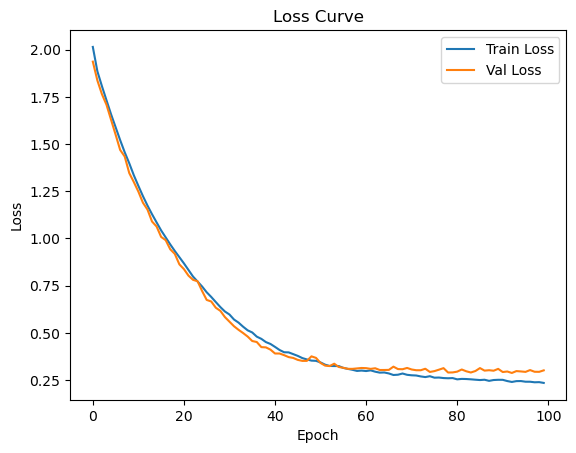

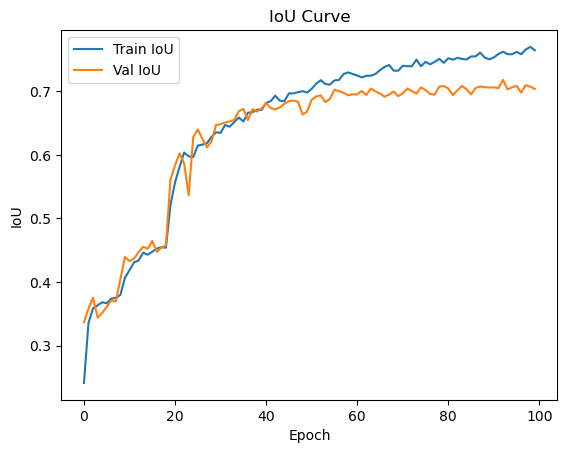

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        num_classes = preds.shape[1]
        preds = torch.softmax(preds, dim=1)
        targets_onehot = F.one_hot(targets, num_classes).permute(0, 4, 1, 2, 3).float()
        intersection = (preds * targets_onehot).sum(dim=(2, 3, 4))
        union = preds.sum(dim=(2, 3, 4)) + targets_onehot.sum(dim=(2, 3, 4))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

def compute_iou(pred, target, num_classes=4):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return torch.tensor(ious).nanmean().item()

class BraTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])  # [128,128,128,3]
        mask = np.load(self.mask_paths[idx])    # [128,128,128,4]

        image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2)  # [3, D, H, W]
        mask = torch.tensor(np.argmax(mask, axis=-1), dtype=torch.long)      # [D, H, W]
        return image, mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D_BN_SE(in_channels=3, out_classes=4).to(device)

ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

train_dataset = BraTSDataset(
    image_dir='BraTS2021_TrainingData_Split/train/images/',
    mask_dir='BraTS2021_TrainingData_Split/train/masks/'
)
val_dataset = BraTSDataset(
    image_dir='BraTS2021_TrainingData_Split/val/images/',
    mask_dir='BraTS2021_TrainingData_Split/val/masks/'
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)

num_epochs = 100
train_losses, val_losses, train_ious, val_ious = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_iou = 0, 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iou += compute_iou(outputs.argmax(1), masks)

    train_losses.append(total_loss / len(train_loader))
    train_ious.append(total_iou / len(train_loader))

    model.eval()
    val_loss, val_iou = 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)
            val_loss += loss.item()
            val_iou += compute_iou(outputs.argmax(1), masks)

    val_losses.append(val_loss / len(val_loader))
    val_ious.append(val_iou / len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}, "
          f"Train IoU = {train_ious[-1]:.4f}, Val IoU = {val_ious[-1]:.4f}")

torch.save(model.state_dict(), "BN_SE_100.pth")

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.title("IoU Curve")
plt.show()


===== Test Evaluation Summary =====
Mean IoU   : 0.7581
Mean Dice  : 0.8334
Mean HD95  : 24.5166
Mean ASSD  : 0.3933


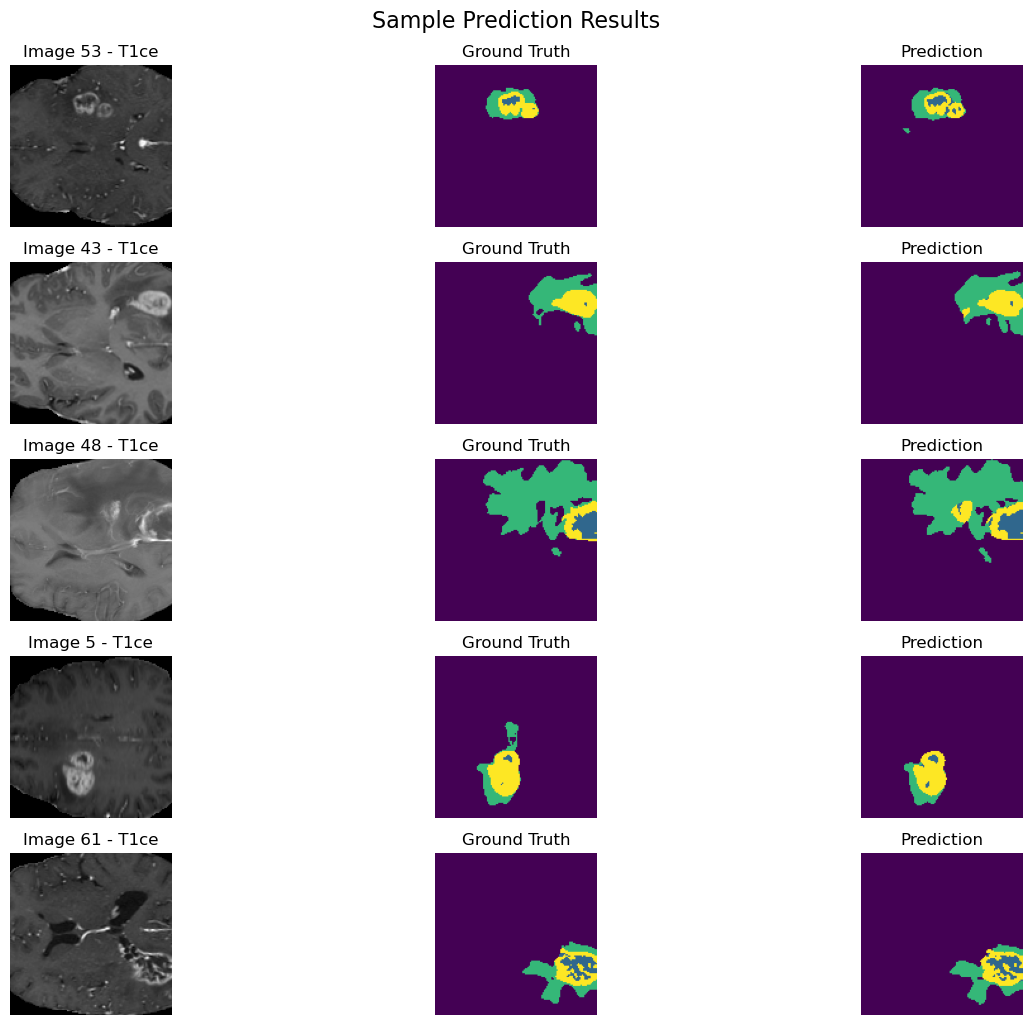

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        mask = np.load(self.mask_paths[idx])
        image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2)  # [C,D,H,W]
        mask = torch.tensor(np.argmax(mask, axis=-1), dtype=torch.long)      # [D,H,W]
        return image, mask

def compute_iou(pred, target, num_classes=4):
    pred, target = pred.view(-1), target.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        ious.append(intersection / union if union != 0 else float('nan'))
    return np.nanmean(ious)

def compute_dice(pred, target, num_classes=4, smooth=1e-5):
    pred, target = pred.view(-1), target.view(-1)
    dices = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item()
        dices.append((2. * intersection + smooth) / (union + smooth) if union != 0 else float('nan'))
    return np.nanmean(dices)

def compute_hd95(pred_np, gt_np):
    pred_itk = sitk.GetImageFromArray(pred_np.astype(np.uint8))
    gt_itk = sitk.GetImageFromArray(gt_np.astype(np.uint8))
    hausdorff = sitk.HausdorffDistanceImageFilter()
    hausdorff.Execute(pred_itk, gt_itk)
    return hausdorff.GetHausdorffDistance(), hausdorff.GetAverageHausdorffDistance()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D_BN_SE(in_channels=3, out_classes=4).to(device)
model.load_state_dict(torch.load("BN_SE_400.pth", map_location=device))
model.eval()

test_dataset = BraTSDataset('BraTS2021_Testing/images/', 'BraTS2021_Testing/masks/')
ious, dices, hd95s, assds = [], [], [], []

for image, mask in test_dataset:
    image, mask = image.to(device), mask.to(device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # [1,C,D,H,W]
        pred = output.argmax(dim=1).squeeze(0)  # [D,H,W]

    ious.append(compute_iou(pred, mask))
    dices.append(compute_dice(pred, mask))
    hd, assd = compute_hd95(pred.cpu().numpy(), mask.cpu().numpy())
    hd95s.append(hd)
    assds.append(assd)

print(f"\n===== Test Evaluation Summary =====")
print(f"Mean IoU   : {np.nanmean(ious):.4f}")
print(f"Mean Dice  : {np.nanmean(dices):.4f}")
print(f"Mean HD95  : {np.nanmean(hd95s):.4f}")
print(f"Mean ASSD  : {np.nanmean(assds):.4f}")

slice_idx = 62
indices_to_plot = [53, 43, 48] + random.sample([i for i in range(len(test_dataset)) if i not in [53,43,48]], 2)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices_to_plot):
    image, mask = test_dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(image[1, :, :, slice_idx], cmap='gray')  # T1ce channel
    plt.title(f"Image {idx} - T1ce")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(mask[:, :, slice_idx].cpu())
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 3)
    plt.imshow(pred[:, :, slice_idx])
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Sample Prediction Results", y=1.02, fontsize=16)
plt.show()

Model F

Group Normalization + SE Block

In [16]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.pool = nn.AdaptiveAvgPool3d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1, 1)
        return x * y


class UNet3D_GN_SE(nn.Module):
    def __init__(self, in_channels=3, out_classes=4, base_filters=16, groups=8):
        super(UNet3D_GN_SE, self).__init__()
        self.groups = groups

        self.encoder1 = self.conv_block(in_channels, base_filters)
        self.pool1 = nn.MaxPool3d(2)

        self.encoder2 = self.conv_block(base_filters, base_filters * 2)
        self.pool2 = nn.MaxPool3d(2)

        self.encoder3 = self.conv_block(base_filters * 2, base_filters * 4)
        self.pool3 = nn.MaxPool3d(2)

        self.encoder4 = self.conv_block(base_filters * 4, base_filters * 8)
        self.pool4 = nn.MaxPool3d(2)

        self.bottleneck = self.conv_block(base_filters * 8, base_filters * 16)

        self.upconv4 = nn.ConvTranspose3d(base_filters * 16, base_filters * 8, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(base_filters * 16, base_filters * 8)

        self.upconv3 = nn.ConvTranspose3d(base_filters * 8, base_filters * 4, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(base_filters * 8, base_filters * 4)

        self.upconv2 = nn.ConvTranspose3d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(base_filters * 4, base_filters * 2)

        self.upconv1 = nn.ConvTranspose3d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(base_filters * 2, base_filters)

        self.out_conv = nn.Conv3d(base_filters, out_classes, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(self.groups, out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout3d(0.1 if out_channels <= 32 else 0.2 if out_channels <= 128 else 0.3),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.GroupNorm(self.groups, out_channels),
            nn.ReLU(inplace=True),
            SEBlock(out_channels)
        )

    def forward(self, x):
        c1 = self.encoder1(x)
        p1 = self.pool1(c1)

        c2 = self.encoder2(p1)
        p2 = self.pool2(c2)

        c3 = self.encoder3(p2)
        p3 = self.pool3(c3)

        c4 = self.encoder4(p3)
        p4 = self.pool4(c4)

        bn = self.bottleneck(p4)

        u4 = self.upconv4(bn)
        u4 = torch.cat([u4, c4], dim=1)
        d4 = self.decoder4(u4)

        u3 = self.upconv3(d4)
        u3 = torch.cat([u3, c3], dim=1)
        d3 = self.decoder3(u3)

        u2 = self.upconv2(d3)
        u2 = torch.cat([u2, c2], dim=1)
        d2 = self.decoder2(u2)

        u1 = self.upconv1(d2)
        u1 = torch.cat([u1, c1], dim=1)
        d1 = self.decoder1(u1)

        out = self.out_conv(d1)
        return out


Epoch 1/1000: 100%|██████████| 138/138 [01:00<00:00,  2.26it/s]


Epoch 1: Train Loss = 2.1054, Val Loss = 1.9922, Train IoU = 0.2099, Val IoU = 0.3386


Epoch 2/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 2: Train Loss = 1.9348, Val Loss = 1.8659, Train IoU = 0.3357, Val IoU = 0.3489


Epoch 3/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 3: Train Loss = 1.8104, Val Loss = 1.7416, Train IoU = 0.3413, Val IoU = 0.3575


Epoch 4/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 4: Train Loss = 1.6840, Val Loss = 1.6142, Train IoU = 0.3498, Val IoU = 0.3597


Epoch 5/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 5: Train Loss = 1.5581, Val Loss = 1.4910, Train IoU = 0.3514, Val IoU = 0.3650


Epoch 6/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 6: Train Loss = 1.4364, Val Loss = 1.3722, Train IoU = 0.3559, Val IoU = 0.3662


Epoch 7/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 7: Train Loss = 1.3225, Val Loss = 1.2639, Train IoU = 0.3564, Val IoU = 0.3691


Epoch 8/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 8: Train Loss = 1.2190, Val Loss = 1.1690, Train IoU = 0.3589, Val IoU = 0.3673


Epoch 9/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 9: Train Loss = 1.1288, Val Loss = 1.0817, Train IoU = 0.3594, Val IoU = 0.3690


Epoch 10/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 10: Train Loss = 1.0511, Val Loss = 1.0093, Train IoU = 0.3632, Val IoU = 0.3728


Epoch 11/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 11: Train Loss = 0.9850, Val Loss = 0.9520, Train IoU = 0.3647, Val IoU = 0.3686


Epoch 12/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 12: Train Loss = 0.9274, Val Loss = 0.8955, Train IoU = 0.3680, Val IoU = 0.3803


Epoch 13/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 13: Train Loss = 0.8785, Val Loss = 0.8522, Train IoU = 0.3697, Val IoU = 0.3791


Epoch 14/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 14: Train Loss = 0.8373, Val Loss = 0.8141, Train IoU = 0.3719, Val IoU = 0.3800


Epoch 15/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 15: Train Loss = 0.8027, Val Loss = 0.7825, Train IoU = 0.3708, Val IoU = 0.3820


Epoch 16/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 16: Train Loss = 0.7711, Val Loss = 0.7524, Train IoU = 0.3729, Val IoU = 0.3823


Epoch 17/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 17: Train Loss = 0.7451, Val Loss = 0.7259, Train IoU = 0.3783, Val IoU = 0.3912


Epoch 18/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 18: Train Loss = 0.7183, Val Loss = 0.7160, Train IoU = 0.4096, Val IoU = 0.4497


Epoch 19/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 19: Train Loss = 0.6976, Val Loss = 0.6861, Train IoU = 0.4362, Val IoU = 0.4504


Epoch 20/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 20: Train Loss = 0.6767, Val Loss = 0.6626, Train IoU = 0.4614, Val IoU = 0.4818


Epoch 21/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 21: Train Loss = 0.6610, Val Loss = 0.6502, Train IoU = 0.4808, Val IoU = 0.4899


Epoch 22/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 22: Train Loss = 0.6414, Val Loss = 0.6283, Train IoU = 0.4942, Val IoU = 0.4988


Epoch 23/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 23: Train Loss = 0.6161, Val Loss = 0.5977, Train IoU = 0.4863, Val IoU = 0.4962


Epoch 24/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 24: Train Loss = 0.5972, Val Loss = 0.5693, Train IoU = 0.4988, Val IoU = 0.5477


Epoch 25/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 25: Train Loss = 0.5753, Val Loss = 0.5478, Train IoU = 0.5391, Val IoU = 0.5627


Epoch 26/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 26: Train Loss = 0.5492, Val Loss = 0.5300, Train IoU = 0.5505, Val IoU = 0.5718


Epoch 27/1000: 100%|██████████| 138/138 [01:00<00:00,  2.30it/s]


Epoch 27: Train Loss = 0.5335, Val Loss = 0.5190, Train IoU = 0.5701, Val IoU = 0.6032


Epoch 28/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 28: Train Loss = 0.5119, Val Loss = 0.4920, Train IoU = 0.5945, Val IoU = 0.6194


Epoch 29/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 29: Train Loss = 0.4868, Val Loss = 0.4603, Train IoU = 0.6181, Val IoU = 0.6351


Epoch 30/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 30: Train Loss = 0.4634, Val Loss = 0.4445, Train IoU = 0.6291, Val IoU = 0.6399


Epoch 31/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 31: Train Loss = 0.4395, Val Loss = 0.4126, Train IoU = 0.6417, Val IoU = 0.6598


Epoch 32/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 32: Train Loss = 0.4185, Val Loss = 0.4022, Train IoU = 0.6534, Val IoU = 0.6603


Epoch 33/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 33: Train Loss = 0.4173, Val Loss = 0.4413, Train IoU = 0.6441, Val IoU = 0.5981


Epoch 34/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 34: Train Loss = 0.4056, Val Loss = 0.3796, Train IoU = 0.6460, Val IoU = 0.6596


Epoch 35/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 35: Train Loss = 0.3894, Val Loss = 0.3827, Train IoU = 0.6596, Val IoU = 0.6557


Epoch 36/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 36: Train Loss = 0.3877, Val Loss = 0.3594, Train IoU = 0.6553, Val IoU = 0.6748


Epoch 37/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 37: Train Loss = 0.3723, Val Loss = 0.3603, Train IoU = 0.6675, Val IoU = 0.6665


Epoch 38/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 38: Train Loss = 0.3592, Val Loss = 0.3420, Train IoU = 0.6723, Val IoU = 0.6778


Epoch 39/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 39: Train Loss = 0.3534, Val Loss = 0.3487, Train IoU = 0.6771, Val IoU = 0.6741


Epoch 40/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 40: Train Loss = 0.3486, Val Loss = 0.3542, Train IoU = 0.6718, Val IoU = 0.6684


Epoch 41/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 41: Train Loss = 0.3434, Val Loss = 0.3488, Train IoU = 0.6763, Val IoU = 0.6627


Epoch 42/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 42: Train Loss = 0.3405, Val Loss = 0.3424, Train IoU = 0.6826, Val IoU = 0.6737


Epoch 43/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 43: Train Loss = 0.3347, Val Loss = 0.3326, Train IoU = 0.6835, Val IoU = 0.6822


Epoch 44/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 44: Train Loss = 0.3287, Val Loss = 0.3307, Train IoU = 0.6888, Val IoU = 0.6802


Epoch 45/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 45: Train Loss = 0.3320, Val Loss = 0.3356, Train IoU = 0.6901, Val IoU = 0.6725


Epoch 46/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 46: Train Loss = 0.3302, Val Loss = 0.3263, Train IoU = 0.6840, Val IoU = 0.6834


Epoch 47/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 47: Train Loss = 0.3226, Val Loss = 0.3339, Train IoU = 0.6921, Val IoU = 0.6766


Epoch 48/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 48: Train Loss = 0.3148, Val Loss = 0.3225, Train IoU = 0.6981, Val IoU = 0.6819


Epoch 49/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 49: Train Loss = 0.3113, Val Loss = 0.3132, Train IoU = 0.6972, Val IoU = 0.6876


Epoch 50/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 50: Train Loss = 0.3124, Val Loss = 0.3153, Train IoU = 0.6934, Val IoU = 0.6884


Epoch 51/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 51: Train Loss = 0.3120, Val Loss = 0.3128, Train IoU = 0.7002, Val IoU = 0.6856


Epoch 52/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 52: Train Loss = 0.3059, Val Loss = 0.3126, Train IoU = 0.7002, Val IoU = 0.6862


Epoch 53/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 53: Train Loss = 0.2994, Val Loss = 0.3211, Train IoU = 0.7088, Val IoU = 0.6846


Epoch 54/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 54: Train Loss = 0.3019, Val Loss = 0.3152, Train IoU = 0.7099, Val IoU = 0.6895


Epoch 55/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 55: Train Loss = 0.2944, Val Loss = 0.3082, Train IoU = 0.7111, Val IoU = 0.6897


Epoch 56/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 56: Train Loss = 0.3003, Val Loss = 0.3156, Train IoU = 0.7100, Val IoU = 0.6931


Epoch 57/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 57: Train Loss = 0.2955, Val Loss = 0.3087, Train IoU = 0.7089, Val IoU = 0.6933


Epoch 58/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 58: Train Loss = 0.2901, Val Loss = 0.3071, Train IoU = 0.7156, Val IoU = 0.6932


Epoch 59/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 59: Train Loss = 0.2858, Val Loss = 0.3079, Train IoU = 0.7166, Val IoU = 0.6922


Epoch 60/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 60: Train Loss = 0.2893, Val Loss = 0.3009, Train IoU = 0.7145, Val IoU = 0.6942


Epoch 61/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 61: Train Loss = 0.2847, Val Loss = 0.3097, Train IoU = 0.7194, Val IoU = 0.6899


Epoch 62/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 62: Train Loss = 0.2836, Val Loss = 0.3183, Train IoU = 0.7178, Val IoU = 0.6866


Epoch 63/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 63: Train Loss = 0.2805, Val Loss = 0.3044, Train IoU = 0.7264, Val IoU = 0.6935


Epoch 64/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 64: Train Loss = 0.2774, Val Loss = 0.3024, Train IoU = 0.7294, Val IoU = 0.6941


Epoch 65/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 65: Train Loss = 0.2789, Val Loss = 0.3003, Train IoU = 0.7174, Val IoU = 0.6965


Epoch 66/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 66: Train Loss = 0.2747, Val Loss = 0.2990, Train IoU = 0.7250, Val IoU = 0.6963


Epoch 67/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 67: Train Loss = 0.2768, Val Loss = 0.2990, Train IoU = 0.7244, Val IoU = 0.6984


Epoch 68/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 68: Train Loss = 0.2732, Val Loss = 0.3075, Train IoU = 0.7285, Val IoU = 0.6898


Epoch 69/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 69: Train Loss = 0.2700, Val Loss = 0.3039, Train IoU = 0.7319, Val IoU = 0.6989


Epoch 70/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 70: Train Loss = 0.2733, Val Loss = 0.3059, Train IoU = 0.7279, Val IoU = 0.6996


Epoch 71/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 71: Train Loss = 0.2711, Val Loss = 0.3014, Train IoU = 0.7235, Val IoU = 0.6981


Epoch 72/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 72: Train Loss = 0.2712, Val Loss = 0.3026, Train IoU = 0.7290, Val IoU = 0.6963


Epoch 73/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 73: Train Loss = 0.2649, Val Loss = 0.2988, Train IoU = 0.7317, Val IoU = 0.6994


Epoch 74/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 74: Train Loss = 0.2725, Val Loss = 0.2933, Train IoU = 0.7280, Val IoU = 0.7046


Epoch 75/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 75: Train Loss = 0.2663, Val Loss = 0.2996, Train IoU = 0.7322, Val IoU = 0.6981


Epoch 76/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 76: Train Loss = 0.2641, Val Loss = 0.2963, Train IoU = 0.7400, Val IoU = 0.7002


Epoch 77/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 77: Train Loss = 0.2645, Val Loss = 0.2993, Train IoU = 0.7362, Val IoU = 0.6976


Epoch 78/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 78: Train Loss = 0.2609, Val Loss = 0.3046, Train IoU = 0.7416, Val IoU = 0.6964


Epoch 79/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 79: Train Loss = 0.2624, Val Loss = 0.3031, Train IoU = 0.7391, Val IoU = 0.6958


Epoch 80/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 80: Train Loss = 0.2644, Val Loss = 0.3031, Train IoU = 0.7353, Val IoU = 0.6990


Epoch 81/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 81: Train Loss = 0.2607, Val Loss = 0.2902, Train IoU = 0.7351, Val IoU = 0.7069


Epoch 82/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 82: Train Loss = 0.2560, Val Loss = 0.2930, Train IoU = 0.7392, Val IoU = 0.7059


Epoch 83/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 83: Train Loss = 0.2605, Val Loss = 0.2934, Train IoU = 0.7391, Val IoU = 0.7067


Epoch 84/1000: 100%|██████████| 138/138 [01:04<00:00,  2.13it/s]


Epoch 84: Train Loss = 0.2605, Val Loss = 0.3090, Train IoU = 0.7413, Val IoU = 0.6975


Epoch 85/1000: 100%|██████████| 138/138 [01:03<00:00,  2.17it/s]


Epoch 85: Train Loss = 0.2687, Val Loss = 0.2889, Train IoU = 0.7331, Val IoU = 0.7095


Epoch 86/1000: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


Epoch 86: Train Loss = 0.2540, Val Loss = 0.2998, Train IoU = 0.7441, Val IoU = 0.7037


Epoch 87/1000: 100%|██████████| 138/138 [01:02<00:00,  2.19it/s]


Epoch 87: Train Loss = 0.2569, Val Loss = 0.2990, Train IoU = 0.7475, Val IoU = 0.7004


Epoch 88/1000: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]


Epoch 88: Train Loss = 0.2574, Val Loss = 0.2925, Train IoU = 0.7382, Val IoU = 0.7068


Epoch 89/1000: 100%|██████████| 138/138 [01:03<00:00,  2.19it/s]


Epoch 89: Train Loss = 0.2515, Val Loss = 0.3048, Train IoU = 0.7508, Val IoU = 0.6990


Epoch 90/1000: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]


Epoch 90: Train Loss = 0.2513, Val Loss = 0.3054, Train IoU = 0.7457, Val IoU = 0.7004


Epoch 91/1000: 100%|██████████| 138/138 [01:03<00:00,  2.19it/s]


Epoch 91: Train Loss = 0.2495, Val Loss = 0.3009, Train IoU = 0.7439, Val IoU = 0.7011


Epoch 92/1000: 100%|██████████| 138/138 [01:03<00:00,  2.19it/s]


Epoch 92: Train Loss = 0.2530, Val Loss = 0.2991, Train IoU = 0.7446, Val IoU = 0.6993


Epoch 93/1000: 100%|██████████| 138/138 [01:03<00:00,  2.17it/s]


Epoch 93: Train Loss = 0.2519, Val Loss = 0.2950, Train IoU = 0.7472, Val IoU = 0.7044


Epoch 94/1000: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]


Epoch 94: Train Loss = 0.2463, Val Loss = 0.3001, Train IoU = 0.7481, Val IoU = 0.7045


Epoch 95/1000: 100%|██████████| 138/138 [01:02<00:00,  2.20it/s]


Epoch 95: Train Loss = 0.2506, Val Loss = 0.2904, Train IoU = 0.7443, Val IoU = 0.7079


Epoch 96/1000: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]


Epoch 96: Train Loss = 0.2470, Val Loss = 0.2958, Train IoU = 0.7495, Val IoU = 0.7060


Epoch 97/1000: 100%|██████████| 138/138 [01:03<00:00,  2.19it/s]


Epoch 97: Train Loss = 0.2464, Val Loss = 0.2931, Train IoU = 0.7536, Val IoU = 0.7061


Epoch 98/1000: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]


Epoch 98: Train Loss = 0.2416, Val Loss = 0.2955, Train IoU = 0.7544, Val IoU = 0.7112


Epoch 99/1000: 100%|██████████| 138/138 [01:03<00:00,  2.19it/s]


Epoch 99: Train Loss = 0.2466, Val Loss = 0.2977, Train IoU = 0.7496, Val IoU = 0.7039


Epoch 100/1000: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]


Epoch 100: Train Loss = 0.2428, Val Loss = 0.2939, Train IoU = 0.7560, Val IoU = 0.7069


Epoch 101/1000: 100%|██████████| 138/138 [01:02<00:00,  2.19it/s]


Epoch 101: Train Loss = 0.2465, Val Loss = 0.3081, Train IoU = 0.7464, Val IoU = 0.6887


Epoch 102/1000: 100%|██████████| 138/138 [01:02<00:00,  2.19it/s]


Epoch 102: Train Loss = 0.2519, Val Loss = 0.3034, Train IoU = 0.7444, Val IoU = 0.6961


Epoch 103/1000: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]


Epoch 103: Train Loss = 0.2454, Val Loss = 0.2928, Train IoU = 0.7498, Val IoU = 0.7104


Epoch 104/1000: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]


Epoch 104: Train Loss = 0.2411, Val Loss = 0.2899, Train IoU = 0.7547, Val IoU = 0.7077


Epoch 105/1000: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]


Epoch 105: Train Loss = 0.2458, Val Loss = 0.2985, Train IoU = 0.7473, Val IoU = 0.7061


Epoch 106/1000: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]


Epoch 106: Train Loss = 0.2416, Val Loss = 0.2926, Train IoU = 0.7520, Val IoU = 0.7042


Epoch 107/1000: 100%|██████████| 138/138 [01:03<00:00,  2.19it/s]


Epoch 107: Train Loss = 0.2427, Val Loss = 0.2948, Train IoU = 0.7518, Val IoU = 0.7125


Epoch 108/1000: 100%|██████████| 138/138 [01:03<00:00,  2.17it/s]


Epoch 108: Train Loss = 0.2429, Val Loss = 0.2845, Train IoU = 0.7558, Val IoU = 0.7141


Epoch 109/1000: 100%|██████████| 138/138 [01:02<00:00,  2.20it/s]


Epoch 109: Train Loss = 0.2377, Val Loss = 0.2906, Train IoU = 0.7595, Val IoU = 0.7174


Epoch 110/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 110: Train Loss = 0.2352, Val Loss = 0.2936, Train IoU = 0.7609, Val IoU = 0.7062


Epoch 111/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 111: Train Loss = 0.2421, Val Loss = 0.2909, Train IoU = 0.7510, Val IoU = 0.7086


Epoch 112/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 112: Train Loss = 0.2345, Val Loss = 0.2935, Train IoU = 0.7572, Val IoU = 0.7100


Epoch 113/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 113: Train Loss = 0.2346, Val Loss = 0.2974, Train IoU = 0.7632, Val IoU = 0.7033


Epoch 114/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 114: Train Loss = 0.2330, Val Loss = 0.2890, Train IoU = 0.7646, Val IoU = 0.7129


Epoch 115/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 115: Train Loss = 0.2338, Val Loss = 0.3036, Train IoU = 0.7645, Val IoU = 0.7030


Epoch 116/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 116: Train Loss = 0.2332, Val Loss = 0.3009, Train IoU = 0.7609, Val IoU = 0.7034


Epoch 117/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 117: Train Loss = 0.2348, Val Loss = 0.2900, Train IoU = 0.7591, Val IoU = 0.7165


Epoch 118/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 118: Train Loss = 0.2337, Val Loss = 0.2984, Train IoU = 0.7612, Val IoU = 0.7061


Epoch 119/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 119: Train Loss = 0.2384, Val Loss = 0.2913, Train IoU = 0.7595, Val IoU = 0.7104


Epoch 120/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 120: Train Loss = 0.2333, Val Loss = 0.3012, Train IoU = 0.7622, Val IoU = 0.7087


Epoch 121/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 121: Train Loss = 0.2288, Val Loss = 0.2933, Train IoU = 0.7673, Val IoU = 0.7112


Epoch 122/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 122: Train Loss = 0.2314, Val Loss = 0.2856, Train IoU = 0.7629, Val IoU = 0.7121


Epoch 123/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 123: Train Loss = 0.2309, Val Loss = 0.2950, Train IoU = 0.7640, Val IoU = 0.7082


Epoch 124/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 124: Train Loss = 0.2295, Val Loss = 0.2936, Train IoU = 0.7658, Val IoU = 0.7087


Epoch 125/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 125: Train Loss = 0.2282, Val Loss = 0.2897, Train IoU = 0.7663, Val IoU = 0.7112


Epoch 126/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 126: Train Loss = 0.2251, Val Loss = 0.2867, Train IoU = 0.7723, Val IoU = 0.7120


Epoch 127/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 127: Train Loss = 0.2267, Val Loss = 0.2947, Train IoU = 0.7690, Val IoU = 0.7081


Epoch 128/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 128: Train Loss = 0.2275, Val Loss = 0.2922, Train IoU = 0.7685, Val IoU = 0.7079


Epoch 129/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 129: Train Loss = 0.2247, Val Loss = 0.2918, Train IoU = 0.7690, Val IoU = 0.7148


Epoch 130/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 130: Train Loss = 0.2273, Val Loss = 0.2965, Train IoU = 0.7680, Val IoU = 0.7069


Epoch 131/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 131: Train Loss = 0.2250, Val Loss = 0.2943, Train IoU = 0.7715, Val IoU = 0.7073


Epoch 132/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 132: Train Loss = 0.2276, Val Loss = 0.2891, Train IoU = 0.7698, Val IoU = 0.7117


Epoch 133/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 133: Train Loss = 0.2217, Val Loss = 0.2892, Train IoU = 0.7762, Val IoU = 0.7121


Epoch 134/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 134: Train Loss = 0.2245, Val Loss = 0.2934, Train IoU = 0.7699, Val IoU = 0.7081


Epoch 135/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 135: Train Loss = 0.2236, Val Loss = 0.2955, Train IoU = 0.7735, Val IoU = 0.7080


Epoch 136/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 136: Train Loss = 0.2208, Val Loss = 0.2931, Train IoU = 0.7727, Val IoU = 0.7105


Epoch 137/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 137: Train Loss = 0.2189, Val Loss = 0.2881, Train IoU = 0.7734, Val IoU = 0.7159


Epoch 138/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 138: Train Loss = 0.2166, Val Loss = 0.2891, Train IoU = 0.7822, Val IoU = 0.7140


Epoch 139/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 139: Train Loss = 0.2217, Val Loss = 0.2878, Train IoU = 0.7760, Val IoU = 0.7121


Epoch 140/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 140: Train Loss = 0.2206, Val Loss = 0.2976, Train IoU = 0.7747, Val IoU = 0.7075


Epoch 141/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 141: Train Loss = 0.2217, Val Loss = 0.2884, Train IoU = 0.7698, Val IoU = 0.7147


Epoch 142/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 142: Train Loss = 0.2173, Val Loss = 0.2969, Train IoU = 0.7743, Val IoU = 0.7072


Epoch 143/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 143: Train Loss = 0.2247, Val Loss = 0.2884, Train IoU = 0.7676, Val IoU = 0.7122


Epoch 144/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 144: Train Loss = 0.2267, Val Loss = 0.2896, Train IoU = 0.7679, Val IoU = 0.7149


Epoch 145/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 145: Train Loss = 0.2208, Val Loss = 0.2918, Train IoU = 0.7743, Val IoU = 0.7099


Epoch 146/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 146: Train Loss = 0.2146, Val Loss = 0.2873, Train IoU = 0.7808, Val IoU = 0.7166


Epoch 147/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 147: Train Loss = 0.2158, Val Loss = 0.2898, Train IoU = 0.7765, Val IoU = 0.7144


Epoch 148/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 148: Train Loss = 0.2169, Val Loss = 0.2922, Train IoU = 0.7731, Val IoU = 0.7110


Epoch 149/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 149: Train Loss = 0.2160, Val Loss = 0.3027, Train IoU = 0.7778, Val IoU = 0.7028


Epoch 150/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 150: Train Loss = 0.2257, Val Loss = 0.3004, Train IoU = 0.7705, Val IoU = 0.7039


Epoch 151/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 151: Train Loss = 0.2162, Val Loss = 0.2968, Train IoU = 0.7777, Val IoU = 0.7110


Epoch 152/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 152: Train Loss = 0.2212, Val Loss = 0.2889, Train IoU = 0.7753, Val IoU = 0.7129


Epoch 153/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 153: Train Loss = 0.2197, Val Loss = 0.2916, Train IoU = 0.7737, Val IoU = 0.7101


Epoch 154/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 154: Train Loss = 0.2152, Val Loss = 0.2938, Train IoU = 0.7776, Val IoU = 0.7111


Epoch 155/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 155: Train Loss = 0.2187, Val Loss = 0.2861, Train IoU = 0.7790, Val IoU = 0.7157


Epoch 156/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 156: Train Loss = 0.2140, Val Loss = 0.2959, Train IoU = 0.7793, Val IoU = 0.7112


Epoch 157/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 157: Train Loss = 0.2097, Val Loss = 0.3021, Train IoU = 0.7845, Val IoU = 0.7063


Epoch 158/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 158: Train Loss = 0.2137, Val Loss = 0.2860, Train IoU = 0.7817, Val IoU = 0.7163


Epoch 159/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 159: Train Loss = 0.2105, Val Loss = 0.2865, Train IoU = 0.7818, Val IoU = 0.7167


Epoch 160/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 160: Train Loss = 0.2075, Val Loss = 0.2903, Train IoU = 0.7894, Val IoU = 0.7193


Epoch 161/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 161: Train Loss = 0.2106, Val Loss = 0.2841, Train IoU = 0.7877, Val IoU = 0.7176


Epoch 162/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 162: Train Loss = 0.2171, Val Loss = 0.2861, Train IoU = 0.7784, Val IoU = 0.7143


Epoch 163/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 163: Train Loss = 0.2137, Val Loss = 0.2861, Train IoU = 0.7807, Val IoU = 0.7149


Epoch 164/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 164: Train Loss = 0.2117, Val Loss = 0.2917, Train IoU = 0.7837, Val IoU = 0.7118


Epoch 165/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 165: Train Loss = 0.2082, Val Loss = 0.2955, Train IoU = 0.7850, Val IoU = 0.7107


Epoch 166/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 166: Train Loss = 0.2058, Val Loss = 0.2942, Train IoU = 0.7901, Val IoU = 0.7067


Epoch 167/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 167: Train Loss = 0.2111, Val Loss = 0.2940, Train IoU = 0.7832, Val IoU = 0.7086


Epoch 168/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 168: Train Loss = 0.2136, Val Loss = 0.2868, Train IoU = 0.7816, Val IoU = 0.7140


Epoch 169/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 169: Train Loss = 0.2080, Val Loss = 0.2931, Train IoU = 0.7830, Val IoU = 0.7100


Epoch 170/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 170: Train Loss = 0.2115, Val Loss = 0.2923, Train IoU = 0.7845, Val IoU = 0.7101


Epoch 171/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 171: Train Loss = 0.2059, Val Loss = 0.2892, Train IoU = 0.7876, Val IoU = 0.7143


Epoch 172/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 172: Train Loss = 0.2043, Val Loss = 0.2943, Train IoU = 0.7920, Val IoU = 0.7107


Epoch 173/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 173: Train Loss = 0.2047, Val Loss = 0.2884, Train IoU = 0.7909, Val IoU = 0.7134


Epoch 174/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 174: Train Loss = 0.2022, Val Loss = 0.2908, Train IoU = 0.7904, Val IoU = 0.7113


Epoch 175/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 175: Train Loss = 0.2067, Val Loss = 0.2983, Train IoU = 0.7859, Val IoU = 0.7023


Epoch 176/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 176: Train Loss = 0.2064, Val Loss = 0.2940, Train IoU = 0.7809, Val IoU = 0.7108


Epoch 177/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 177: Train Loss = 0.2094, Val Loss = 0.2959, Train IoU = 0.7889, Val IoU = 0.7073


Epoch 178/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 178: Train Loss = 0.2077, Val Loss = 0.2910, Train IoU = 0.7824, Val IoU = 0.7113


Epoch 179/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 179: Train Loss = 0.1999, Val Loss = 0.2875, Train IoU = 0.7943, Val IoU = 0.7123


Epoch 180/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 180: Train Loss = 0.1995, Val Loss = 0.2909, Train IoU = 0.7945, Val IoU = 0.7135


Epoch 181/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 181: Train Loss = 0.2007, Val Loss = 0.2950, Train IoU = 0.7960, Val IoU = 0.7101


Epoch 182/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 182: Train Loss = 0.2009, Val Loss = 0.2888, Train IoU = 0.7936, Val IoU = 0.7155


Epoch 183/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 183: Train Loss = 0.2037, Val Loss = 0.2905, Train IoU = 0.7903, Val IoU = 0.7114


Epoch 184/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 184: Train Loss = 0.2000, Val Loss = 0.2944, Train IoU = 0.7970, Val IoU = 0.7122


Epoch 185/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 185: Train Loss = 0.2041, Val Loss = 0.2826, Train IoU = 0.7902, Val IoU = 0.7199


Epoch 186/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 186: Train Loss = 0.2021, Val Loss = 0.2914, Train IoU = 0.7909, Val IoU = 0.7145


Epoch 187/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 187: Train Loss = 0.1994, Val Loss = 0.2976, Train IoU = 0.7971, Val IoU = 0.7126


Epoch 188/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 188: Train Loss = 0.2030, Val Loss = 0.2933, Train IoU = 0.7939, Val IoU = 0.7125


Epoch 189/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 189: Train Loss = 0.2001, Val Loss = 0.2935, Train IoU = 0.7946, Val IoU = 0.7110


Epoch 190/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 190: Train Loss = 0.1989, Val Loss = 0.2853, Train IoU = 0.7986, Val IoU = 0.7160


Epoch 191/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 191: Train Loss = 0.1983, Val Loss = 0.2899, Train IoU = 0.7916, Val IoU = 0.7151


Epoch 192/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 192: Train Loss = 0.1975, Val Loss = 0.2872, Train IoU = 0.7984, Val IoU = 0.7137


Epoch 193/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 193: Train Loss = 0.2010, Val Loss = 0.2953, Train IoU = 0.7948, Val IoU = 0.7129


Epoch 194/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 194: Train Loss = 0.2054, Val Loss = 0.2914, Train IoU = 0.7878, Val IoU = 0.7115


Epoch 195/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 195: Train Loss = 0.1988, Val Loss = 0.2909, Train IoU = 0.7947, Val IoU = 0.7135


Epoch 196/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 196: Train Loss = 0.2029, Val Loss = 0.2896, Train IoU = 0.7933, Val IoU = 0.7132


Epoch 197/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 197: Train Loss = 0.1985, Val Loss = 0.2937, Train IoU = 0.7992, Val IoU = 0.7108


Epoch 198/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 198: Train Loss = 0.1957, Val Loss = 0.2929, Train IoU = 0.7991, Val IoU = 0.7131


Epoch 199/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 199: Train Loss = 0.1964, Val Loss = 0.2853, Train IoU = 0.7977, Val IoU = 0.7178


Epoch 200/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 200: Train Loss = 0.1937, Val Loss = 0.2896, Train IoU = 0.7966, Val IoU = 0.7142


Epoch 201/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 201: Train Loss = 0.1941, Val Loss = 0.2932, Train IoU = 0.8003, Val IoU = 0.7133


Epoch 202/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 202: Train Loss = 0.1951, Val Loss = 0.2972, Train IoU = 0.8023, Val IoU = 0.7111


Epoch 203/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 203: Train Loss = 0.1946, Val Loss = 0.2935, Train IoU = 0.8001, Val IoU = 0.7133


Epoch 204/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 204: Train Loss = 0.1966, Val Loss = 0.2905, Train IoU = 0.7996, Val IoU = 0.7153


Epoch 205/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 205: Train Loss = 0.1972, Val Loss = 0.2968, Train IoU = 0.7973, Val IoU = 0.7110


Epoch 206/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 206: Train Loss = 0.1949, Val Loss = 0.2859, Train IoU = 0.7999, Val IoU = 0.7159


Epoch 207/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 207: Train Loss = 0.1935, Val Loss = 0.2880, Train IoU = 0.7959, Val IoU = 0.7235


Epoch 208/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 208: Train Loss = 0.1935, Val Loss = 0.2888, Train IoU = 0.8016, Val IoU = 0.7153


Epoch 209/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 209: Train Loss = 0.1914, Val Loss = 0.2904, Train IoU = 0.8054, Val IoU = 0.7154


Epoch 210/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 210: Train Loss = 0.1928, Val Loss = 0.3041, Train IoU = 0.7998, Val IoU = 0.6959


Epoch 211/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 211: Train Loss = 0.1943, Val Loss = 0.2843, Train IoU = 0.7988, Val IoU = 0.7200


Epoch 212/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 212: Train Loss = 0.1902, Val Loss = 0.2902, Train IoU = 0.8064, Val IoU = 0.7197


Epoch 213/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 213: Train Loss = 0.1881, Val Loss = 0.2858, Train IoU = 0.8057, Val IoU = 0.7188


Epoch 214/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 214: Train Loss = 0.1874, Val Loss = 0.2932, Train IoU = 0.8045, Val IoU = 0.7125


Epoch 215/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 215: Train Loss = 0.1886, Val Loss = 0.2893, Train IoU = 0.8035, Val IoU = 0.7174


Epoch 216/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 216: Train Loss = 0.1885, Val Loss = 0.2850, Train IoU = 0.7988, Val IoU = 0.7158


Epoch 217/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 217: Train Loss = 0.1892, Val Loss = 0.2929, Train IoU = 0.8045, Val IoU = 0.7140


Epoch 218/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 218: Train Loss = 0.1954, Val Loss = 0.2923, Train IoU = 0.7965, Val IoU = 0.7169


Epoch 219/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 219: Train Loss = 0.1895, Val Loss = 0.2917, Train IoU = 0.8044, Val IoU = 0.7141


Epoch 220/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 220: Train Loss = 0.1905, Val Loss = 0.2886, Train IoU = 0.8045, Val IoU = 0.7163


Epoch 221/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 221: Train Loss = 0.1858, Val Loss = 0.2951, Train IoU = 0.8054, Val IoU = 0.7120


Epoch 222/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 222: Train Loss = 0.1876, Val Loss = 0.2923, Train IoU = 0.8046, Val IoU = 0.7124


Epoch 223/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 223: Train Loss = 0.1875, Val Loss = 0.2876, Train IoU = 0.8076, Val IoU = 0.7161


Epoch 224/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 224: Train Loss = 0.1872, Val Loss = 0.2855, Train IoU = 0.8078, Val IoU = 0.7183


Epoch 225/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 225: Train Loss = 0.1857, Val Loss = 0.2936, Train IoU = 0.8078, Val IoU = 0.7176


Epoch 226/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 226: Train Loss = 0.1843, Val Loss = 0.3005, Train IoU = 0.8094, Val IoU = 0.7070


Epoch 227/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 227: Train Loss = 0.1878, Val Loss = 0.2955, Train IoU = 0.8057, Val IoU = 0.7090


Epoch 228/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 228: Train Loss = 0.1852, Val Loss = 0.2988, Train IoU = 0.8100, Val IoU = 0.7102


Epoch 229/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 229: Train Loss = 0.1839, Val Loss = 0.2901, Train IoU = 0.8110, Val IoU = 0.7155


Epoch 230/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 230: Train Loss = 0.1908, Val Loss = 0.2871, Train IoU = 0.8031, Val IoU = 0.7184


Epoch 231/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 231: Train Loss = 0.1849, Val Loss = 0.3012, Train IoU = 0.8108, Val IoU = 0.7097


Epoch 232/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 232: Train Loss = 0.1888, Val Loss = 0.2996, Train IoU = 0.7986, Val IoU = 0.7094


Epoch 233/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 233: Train Loss = 0.1869, Val Loss = 0.2970, Train IoU = 0.8065, Val IoU = 0.7106


Epoch 234/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 234: Train Loss = 0.1832, Val Loss = 0.2948, Train IoU = 0.8116, Val IoU = 0.7146


Epoch 235/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 235: Train Loss = 0.1847, Val Loss = 0.2969, Train IoU = 0.8083, Val IoU = 0.7113


Epoch 236/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 236: Train Loss = 0.1859, Val Loss = 0.2999, Train IoU = 0.8091, Val IoU = 0.7082


Epoch 237/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 237: Train Loss = 0.1861, Val Loss = 0.2911, Train IoU = 0.8137, Val IoU = 0.7173


Epoch 238/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 238: Train Loss = 0.1829, Val Loss = 0.2942, Train IoU = 0.8096, Val IoU = 0.7171


Epoch 239/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 239: Train Loss = 0.1811, Val Loss = 0.2904, Train IoU = 0.8121, Val IoU = 0.7157


Epoch 240/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 240: Train Loss = 0.1799, Val Loss = 0.2989, Train IoU = 0.8115, Val IoU = 0.7140


Epoch 241/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 241: Train Loss = 0.1831, Val Loss = 0.2928, Train IoU = 0.8144, Val IoU = 0.7155


Epoch 242/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 242: Train Loss = 0.1826, Val Loss = 0.2903, Train IoU = 0.8110, Val IoU = 0.7185


Epoch 243/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 243: Train Loss = 0.1826, Val Loss = 0.2921, Train IoU = 0.8110, Val IoU = 0.7163


Epoch 244/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 244: Train Loss = 0.1811, Val Loss = 0.2948, Train IoU = 0.8170, Val IoU = 0.7147


Epoch 245/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 245: Train Loss = 0.1790, Val Loss = 0.3030, Train IoU = 0.8138, Val IoU = 0.7093


Epoch 246/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 246: Train Loss = 0.1834, Val Loss = 0.3028, Train IoU = 0.8068, Val IoU = 0.7117


Epoch 247/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 247: Train Loss = 0.1845, Val Loss = 0.2940, Train IoU = 0.8101, Val IoU = 0.7140


Epoch 248/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 248: Train Loss = 0.1823, Val Loss = 0.2922, Train IoU = 0.8144, Val IoU = 0.7129


Epoch 249/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 249: Train Loss = 0.1823, Val Loss = 0.2912, Train IoU = 0.8146, Val IoU = 0.7138


Epoch 250/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 250: Train Loss = 0.1808, Val Loss = 0.2855, Train IoU = 0.8104, Val IoU = 0.7182


Epoch 251/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 251: Train Loss = 0.1791, Val Loss = 0.2872, Train IoU = 0.8179, Val IoU = 0.7176


Epoch 252/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 252: Train Loss = 0.1834, Val Loss = 0.2818, Train IoU = 0.8113, Val IoU = 0.7213


Epoch 253/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 253: Train Loss = 0.1796, Val Loss = 0.2837, Train IoU = 0.8101, Val IoU = 0.7207


Epoch 254/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 254: Train Loss = 0.1811, Val Loss = 0.2942, Train IoU = 0.8126, Val IoU = 0.7143


Epoch 255/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 255: Train Loss = 0.1790, Val Loss = 0.2932, Train IoU = 0.8131, Val IoU = 0.7165


Epoch 256/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 256: Train Loss = 0.1780, Val Loss = 0.2847, Train IoU = 0.8160, Val IoU = 0.7201


Epoch 257/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 257: Train Loss = 0.1807, Val Loss = 0.2976, Train IoU = 0.8114, Val IoU = 0.7105


Epoch 258/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 258: Train Loss = 0.1788, Val Loss = 0.2870, Train IoU = 0.8109, Val IoU = 0.7184


Epoch 259/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 259: Train Loss = 0.1748, Val Loss = 0.2908, Train IoU = 0.8169, Val IoU = 0.7148


Epoch 260/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 260: Train Loss = 0.1769, Val Loss = 0.2954, Train IoU = 0.8168, Val IoU = 0.7159


Epoch 261/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 261: Train Loss = 0.1764, Val Loss = 0.2906, Train IoU = 0.8196, Val IoU = 0.7148


Epoch 262/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 262: Train Loss = 0.1757, Val Loss = 0.2932, Train IoU = 0.8211, Val IoU = 0.7150


Epoch 263/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 263: Train Loss = 0.1741, Val Loss = 0.2910, Train IoU = 0.8171, Val IoU = 0.7191


Epoch 264/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 264: Train Loss = 0.1745, Val Loss = 0.2980, Train IoU = 0.8165, Val IoU = 0.7119


Epoch 265/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 265: Train Loss = 0.1774, Val Loss = 0.2919, Train IoU = 0.8184, Val IoU = 0.7167


Epoch 266/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 266: Train Loss = 0.1766, Val Loss = 0.2853, Train IoU = 0.8201, Val IoU = 0.7196


Epoch 267/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 267: Train Loss = 0.1787, Val Loss = 0.2986, Train IoU = 0.8165, Val IoU = 0.7145


Epoch 268/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 268: Train Loss = 0.1779, Val Loss = 0.2914, Train IoU = 0.8157, Val IoU = 0.7156


Epoch 269/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 269: Train Loss = 0.1734, Val Loss = 0.2894, Train IoU = 0.8192, Val IoU = 0.7162


Epoch 270/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 270: Train Loss = 0.1744, Val Loss = 0.3001, Train IoU = 0.8197, Val IoU = 0.7076


Epoch 271/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 271: Train Loss = 0.1771, Val Loss = 0.2933, Train IoU = 0.8217, Val IoU = 0.7159


Epoch 272/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 272: Train Loss = 0.1748, Val Loss = 0.2869, Train IoU = 0.8205, Val IoU = 0.7223


Epoch 273/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 273: Train Loss = 0.1740, Val Loss = 0.2894, Train IoU = 0.8220, Val IoU = 0.7174


Epoch 274/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 274: Train Loss = 0.1745, Val Loss = 0.2860, Train IoU = 0.8108, Val IoU = 0.7184


Epoch 275/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 275: Train Loss = 0.1739, Val Loss = 0.2936, Train IoU = 0.8184, Val IoU = 0.7156


Epoch 276/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 276: Train Loss = 0.1730, Val Loss = 0.2909, Train IoU = 0.8236, Val IoU = 0.7179


Epoch 277/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 277: Train Loss = 0.1700, Val Loss = 0.2859, Train IoU = 0.8240, Val IoU = 0.7182


Epoch 278/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 278: Train Loss = 0.1726, Val Loss = 0.2846, Train IoU = 0.8168, Val IoU = 0.7204


Epoch 279/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 279: Train Loss = 0.1745, Val Loss = 0.3004, Train IoU = 0.8144, Val IoU = 0.7108


Epoch 280/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 280: Train Loss = 0.1730, Val Loss = 0.2842, Train IoU = 0.8215, Val IoU = 0.7218


Epoch 281/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 281: Train Loss = 0.1715, Val Loss = 0.2898, Train IoU = 0.8220, Val IoU = 0.7183


Epoch 282/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 282: Train Loss = 0.1732, Val Loss = 0.2885, Train IoU = 0.8182, Val IoU = 0.7179


Epoch 283/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 283: Train Loss = 0.1697, Val Loss = 0.2908, Train IoU = 0.8223, Val IoU = 0.7189


Epoch 284/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 284: Train Loss = 0.1708, Val Loss = 0.2947, Train IoU = 0.8228, Val IoU = 0.7143


Epoch 285/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 285: Train Loss = 0.1687, Val Loss = 0.2978, Train IoU = 0.8222, Val IoU = 0.7113


Epoch 286/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 286: Train Loss = 0.1701, Val Loss = 0.2944, Train IoU = 0.8271, Val IoU = 0.7156


Epoch 287/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 287: Train Loss = 0.1703, Val Loss = 0.2911, Train IoU = 0.8255, Val IoU = 0.7216


Epoch 288/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 288: Train Loss = 0.1699, Val Loss = 0.2898, Train IoU = 0.8260, Val IoU = 0.7180


Epoch 289/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 289: Train Loss = 0.1754, Val Loss = 0.2930, Train IoU = 0.8119, Val IoU = 0.7178


Epoch 290/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 290: Train Loss = 0.1711, Val Loss = 0.2923, Train IoU = 0.8221, Val IoU = 0.7186


Epoch 291/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 291: Train Loss = 0.1674, Val Loss = 0.2962, Train IoU = 0.8269, Val IoU = 0.7144


Epoch 292/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 292: Train Loss = 0.1688, Val Loss = 0.2917, Train IoU = 0.8257, Val IoU = 0.7149


Epoch 293/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 293: Train Loss = 0.1693, Val Loss = 0.2912, Train IoU = 0.8198, Val IoU = 0.7150


Epoch 294/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 294: Train Loss = 0.1687, Val Loss = 0.2982, Train IoU = 0.8264, Val IoU = 0.7140


Epoch 295/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 295: Train Loss = 0.1674, Val Loss = 0.2926, Train IoU = 0.8244, Val IoU = 0.7169


Epoch 296/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 296: Train Loss = 0.1683, Val Loss = 0.3062, Train IoU = 0.8206, Val IoU = 0.7102


Epoch 297/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 297: Train Loss = 0.1731, Val Loss = 0.2957, Train IoU = 0.8179, Val IoU = 0.7141


Epoch 298/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 298: Train Loss = 0.1679, Val Loss = 0.2971, Train IoU = 0.8270, Val IoU = 0.7137


Epoch 299/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 299: Train Loss = 0.1667, Val Loss = 0.2878, Train IoU = 0.8293, Val IoU = 0.7201


Epoch 300/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 300: Train Loss = 0.1673, Val Loss = 0.2934, Train IoU = 0.8263, Val IoU = 0.7155


Epoch 301/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 301: Train Loss = 0.1655, Val Loss = 0.2913, Train IoU = 0.8303, Val IoU = 0.7162


Epoch 302/1000: 100%|██████████| 138/138 [00:58<00:00,  2.36it/s]


Epoch 302: Train Loss = 0.1663, Val Loss = 0.2961, Train IoU = 0.8320, Val IoU = 0.7143


Epoch 303/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 303: Train Loss = 0.1661, Val Loss = 0.2938, Train IoU = 0.8288, Val IoU = 0.7152


Epoch 304/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 304: Train Loss = 0.1675, Val Loss = 0.2887, Train IoU = 0.8281, Val IoU = 0.7193


Epoch 305/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 305: Train Loss = 0.1667, Val Loss = 0.3048, Train IoU = 0.8267, Val IoU = 0.7113


Epoch 306/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 306: Train Loss = 0.1651, Val Loss = 0.2944, Train IoU = 0.8272, Val IoU = 0.7163


Epoch 307/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 307: Train Loss = 0.1656, Val Loss = 0.2996, Train IoU = 0.8277, Val IoU = 0.7138


Epoch 308/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 308: Train Loss = 0.1660, Val Loss = 0.2900, Train IoU = 0.8321, Val IoU = 0.7187


Epoch 309/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 309: Train Loss = 0.1641, Val Loss = 0.2961, Train IoU = 0.8291, Val IoU = 0.7142


Epoch 310/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 310: Train Loss = 0.1741, Val Loss = 0.2919, Train IoU = 0.8212, Val IoU = 0.7176


Epoch 311/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 311: Train Loss = 0.1670, Val Loss = 0.2971, Train IoU = 0.8250, Val IoU = 0.7153


Epoch 312/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 312: Train Loss = 0.1652, Val Loss = 0.2958, Train IoU = 0.8274, Val IoU = 0.7147


Epoch 313/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 313: Train Loss = 0.1631, Val Loss = 0.2977, Train IoU = 0.8313, Val IoU = 0.7156


Epoch 314/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 314: Train Loss = 0.1660, Val Loss = 0.2926, Train IoU = 0.8270, Val IoU = 0.7164


Epoch 315/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 315: Train Loss = 0.1631, Val Loss = 0.2997, Train IoU = 0.8293, Val IoU = 0.7150


Epoch 316/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 316: Train Loss = 0.1634, Val Loss = 0.2931, Train IoU = 0.8299, Val IoU = 0.7132


Epoch 317/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 317: Train Loss = 0.1643, Val Loss = 0.2996, Train IoU = 0.8347, Val IoU = 0.7126


Epoch 318/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 318: Train Loss = 0.1629, Val Loss = 0.2927, Train IoU = 0.8288, Val IoU = 0.7170


Epoch 319/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 319: Train Loss = 0.1647, Val Loss = 0.2952, Train IoU = 0.8287, Val IoU = 0.7146


Epoch 320/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 320: Train Loss = 0.1660, Val Loss = 0.3031, Train IoU = 0.8281, Val IoU = 0.7104


Epoch 321/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 321: Train Loss = 0.1647, Val Loss = 0.2872, Train IoU = 0.8260, Val IoU = 0.7204


Epoch 322/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 322: Train Loss = 0.1621, Val Loss = 0.2891, Train IoU = 0.8336, Val IoU = 0.7184


Epoch 323/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 323: Train Loss = 0.1635, Val Loss = 0.2916, Train IoU = 0.8295, Val IoU = 0.7194


Epoch 324/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 324: Train Loss = 0.1651, Val Loss = 0.2975, Train IoU = 0.8272, Val IoU = 0.7127


Epoch 325/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 325: Train Loss = 0.1616, Val Loss = 0.2879, Train IoU = 0.8306, Val IoU = 0.7196


Epoch 326/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 326: Train Loss = 0.1599, Val Loss = 0.2906, Train IoU = 0.8367, Val IoU = 0.7177


Epoch 327/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 327: Train Loss = 0.1615, Val Loss = 0.2925, Train IoU = 0.8325, Val IoU = 0.7184


Epoch 328/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 328: Train Loss = 0.1636, Val Loss = 0.2890, Train IoU = 0.8264, Val IoU = 0.7188


Epoch 329/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 329: Train Loss = 0.1637, Val Loss = 0.2992, Train IoU = 0.8317, Val IoU = 0.7127


Epoch 330/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 330: Train Loss = 0.1638, Val Loss = 0.2983, Train IoU = 0.8287, Val IoU = 0.7124


Epoch 331/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 331: Train Loss = 0.1632, Val Loss = 0.2917, Train IoU = 0.8267, Val IoU = 0.7183


Epoch 332/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 332: Train Loss = 0.1624, Val Loss = 0.2923, Train IoU = 0.8335, Val IoU = 0.7178


Epoch 333/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 333: Train Loss = 0.1603, Val Loss = 0.2934, Train IoU = 0.8338, Val IoU = 0.7162


Epoch 334/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 334: Train Loss = 0.1594, Val Loss = 0.2937, Train IoU = 0.8358, Val IoU = 0.7167


Epoch 335/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 335: Train Loss = 0.1617, Val Loss = 0.2942, Train IoU = 0.8318, Val IoU = 0.7177


Epoch 336/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 336: Train Loss = 0.1611, Val Loss = 0.2955, Train IoU = 0.8347, Val IoU = 0.7148


Epoch 337/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 337: Train Loss = 0.1608, Val Loss = 0.2948, Train IoU = 0.8288, Val IoU = 0.7164


Epoch 338/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 338: Train Loss = 0.1636, Val Loss = 0.2906, Train IoU = 0.8327, Val IoU = 0.7187


Epoch 339/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 339: Train Loss = 0.1633, Val Loss = 0.3023, Train IoU = 0.8333, Val IoU = 0.7120


Epoch 340/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 340: Train Loss = 0.1609, Val Loss = 0.2927, Train IoU = 0.8318, Val IoU = 0.7168


Epoch 341/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 341: Train Loss = 0.1605, Val Loss = 0.2958, Train IoU = 0.8355, Val IoU = 0.7152


Epoch 342/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 342: Train Loss = 0.1587, Val Loss = 0.2999, Train IoU = 0.8368, Val IoU = 0.7137


Epoch 343/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 343: Train Loss = 0.1589, Val Loss = 0.2932, Train IoU = 0.8365, Val IoU = 0.7170


Epoch 344/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 344: Train Loss = 0.1570, Val Loss = 0.2935, Train IoU = 0.8395, Val IoU = 0.7166


Epoch 345/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 345: Train Loss = 0.1592, Val Loss = 0.2902, Train IoU = 0.8360, Val IoU = 0.7204


Epoch 346/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 346: Train Loss = 0.1588, Val Loss = 0.2942, Train IoU = 0.8369, Val IoU = 0.7173


Epoch 347/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 347: Train Loss = 0.1568, Val Loss = 0.2919, Train IoU = 0.8369, Val IoU = 0.7179


Epoch 348/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 348: Train Loss = 0.1605, Val Loss = 0.2883, Train IoU = 0.8323, Val IoU = 0.7199


Epoch 349/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 349: Train Loss = 0.1592, Val Loss = 0.2916, Train IoU = 0.8307, Val IoU = 0.7199


Epoch 350/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 350: Train Loss = 0.1601, Val Loss = 0.2927, Train IoU = 0.8317, Val IoU = 0.7163


Epoch 351/1000: 100%|██████████| 138/138 [00:58<00:00,  2.36it/s]


Epoch 351: Train Loss = 0.1588, Val Loss = 0.2890, Train IoU = 0.8334, Val IoU = 0.7213


Epoch 352/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 352: Train Loss = 0.1564, Val Loss = 0.2969, Train IoU = 0.8394, Val IoU = 0.7163


Epoch 353/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 353: Train Loss = 0.1577, Val Loss = 0.2914, Train IoU = 0.8393, Val IoU = 0.7207


Epoch 354/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 354: Train Loss = 0.1569, Val Loss = 0.2907, Train IoU = 0.8370, Val IoU = 0.7218


Epoch 355/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 355: Train Loss = 0.1565, Val Loss = 0.2949, Train IoU = 0.8351, Val IoU = 0.7153


Epoch 356/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 356: Train Loss = 0.1566, Val Loss = 0.2944, Train IoU = 0.8370, Val IoU = 0.7186


Epoch 357/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 357: Train Loss = 0.1559, Val Loss = 0.2946, Train IoU = 0.8354, Val IoU = 0.7169


Epoch 358/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 358: Train Loss = 0.1577, Val Loss = 0.2869, Train IoU = 0.8382, Val IoU = 0.7235


Epoch 359/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 359: Train Loss = 0.1552, Val Loss = 0.2935, Train IoU = 0.8389, Val IoU = 0.7180


Epoch 360/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 360: Train Loss = 0.1694, Val Loss = 0.2997, Train IoU = 0.8262, Val IoU = 0.7100


Epoch 361/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 361: Train Loss = 0.1623, Val Loss = 0.2981, Train IoU = 0.8337, Val IoU = 0.7159


Epoch 362/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 362: Train Loss = 0.1590, Val Loss = 0.2979, Train IoU = 0.8403, Val IoU = 0.7156


Epoch 363/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 363: Train Loss = 0.1572, Val Loss = 0.2860, Train IoU = 0.8381, Val IoU = 0.7222


Epoch 364/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 364: Train Loss = 0.1553, Val Loss = 0.2889, Train IoU = 0.8396, Val IoU = 0.7216


Epoch 365/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 365: Train Loss = 0.1559, Val Loss = 0.2917, Train IoU = 0.8416, Val IoU = 0.7176


Epoch 366/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 366: Train Loss = 0.1552, Val Loss = 0.2930, Train IoU = 0.8380, Val IoU = 0.7181


Epoch 367/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 367: Train Loss = 0.1545, Val Loss = 0.2870, Train IoU = 0.8378, Val IoU = 0.7227


Epoch 368/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 368: Train Loss = 0.1543, Val Loss = 0.2926, Train IoU = 0.8384, Val IoU = 0.7190


Epoch 369/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 369: Train Loss = 0.1542, Val Loss = 0.2990, Train IoU = 0.8394, Val IoU = 0.7132


Epoch 370/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 370: Train Loss = 0.1551, Val Loss = 0.2979, Train IoU = 0.8347, Val IoU = 0.7146


Epoch 371/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 371: Train Loss = 0.1552, Val Loss = 0.2904, Train IoU = 0.8351, Val IoU = 0.7208


Epoch 372/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 372: Train Loss = 0.1540, Val Loss = 0.2927, Train IoU = 0.8390, Val IoU = 0.7197


Epoch 373/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 373: Train Loss = 0.1543, Val Loss = 0.2894, Train IoU = 0.8400, Val IoU = 0.7203


Epoch 374/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 374: Train Loss = 0.1591, Val Loss = 0.2959, Train IoU = 0.8342, Val IoU = 0.7165


Epoch 375/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 375: Train Loss = 0.1531, Val Loss = 0.2970, Train IoU = 0.8391, Val IoU = 0.7168


Epoch 376/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 376: Train Loss = 0.1816, Val Loss = 0.2939, Train IoU = 0.8103, Val IoU = 0.7137


Epoch 377/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 377: Train Loss = 0.1591, Val Loss = 0.2867, Train IoU = 0.8326, Val IoU = 0.7213


Epoch 378/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 378: Train Loss = 0.1540, Val Loss = 0.2941, Train IoU = 0.8386, Val IoU = 0.7195


Epoch 379/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 379: Train Loss = 0.1520, Val Loss = 0.2901, Train IoU = 0.8422, Val IoU = 0.7178


Epoch 380/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 380: Train Loss = 0.1529, Val Loss = 0.2943, Train IoU = 0.8383, Val IoU = 0.7173


Epoch 381/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 381: Train Loss = 0.1526, Val Loss = 0.2898, Train IoU = 0.8402, Val IoU = 0.7216


Epoch 382/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 382: Train Loss = 0.1528, Val Loss = 0.2913, Train IoU = 0.8429, Val IoU = 0.7199


Epoch 383/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 383: Train Loss = 0.1522, Val Loss = 0.2915, Train IoU = 0.8426, Val IoU = 0.7176


Epoch 384/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 384: Train Loss = 0.1506, Val Loss = 0.2920, Train IoU = 0.8419, Val IoU = 0.7187


Epoch 385/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 385: Train Loss = 0.1518, Val Loss = 0.2887, Train IoU = 0.8390, Val IoU = 0.7217


Epoch 386/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 386: Train Loss = 0.1526, Val Loss = 0.2967, Train IoU = 0.8435, Val IoU = 0.7165


Epoch 387/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 387: Train Loss = 0.1511, Val Loss = 0.2920, Train IoU = 0.8428, Val IoU = 0.7200


Epoch 388/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 388: Train Loss = 0.1506, Val Loss = 0.2900, Train IoU = 0.8448, Val IoU = 0.7205


Epoch 389/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 389: Train Loss = 0.1521, Val Loss = 0.2970, Train IoU = 0.8440, Val IoU = 0.7171


Epoch 390/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 390: Train Loss = 0.1518, Val Loss = 0.2951, Train IoU = 0.8408, Val IoU = 0.7152


Epoch 391/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 391: Train Loss = 0.1511, Val Loss = 0.2920, Train IoU = 0.8430, Val IoU = 0.7210


Epoch 392/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 392: Train Loss = 0.1497, Val Loss = 0.2909, Train IoU = 0.8446, Val IoU = 0.7196


Epoch 393/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 393: Train Loss = 0.1498, Val Loss = 0.2924, Train IoU = 0.8453, Val IoU = 0.7194


Epoch 394/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 394: Train Loss = 0.1509, Val Loss = 0.2949, Train IoU = 0.8435, Val IoU = 0.7183


Epoch 395/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 395: Train Loss = 0.1496, Val Loss = 0.2949, Train IoU = 0.8437, Val IoU = 0.7177


Epoch 396/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 396: Train Loss = 0.1508, Val Loss = 0.2908, Train IoU = 0.8410, Val IoU = 0.7195


Epoch 397/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 397: Train Loss = 0.1503, Val Loss = 0.2915, Train IoU = 0.8425, Val IoU = 0.7219


Epoch 398/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 398: Train Loss = 0.1513, Val Loss = 0.2994, Train IoU = 0.8425, Val IoU = 0.7123


Epoch 399/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 399: Train Loss = 0.1519, Val Loss = 0.2968, Train IoU = 0.8437, Val IoU = 0.7166


Epoch 400/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 400: Train Loss = 0.1525, Val Loss = 0.2918, Train IoU = 0.8406, Val IoU = 0.7192


Epoch 401/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 401: Train Loss = 0.1510, Val Loss = 0.2966, Train IoU = 0.8426, Val IoU = 0.7176


Epoch 402/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 402: Train Loss = 0.1536, Val Loss = 0.2949, Train IoU = 0.8393, Val IoU = 0.7187


Epoch 403/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 403: Train Loss = 0.1512, Val Loss = 0.2935, Train IoU = 0.8408, Val IoU = 0.7198


Epoch 404/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 404: Train Loss = 0.1487, Val Loss = 0.2933, Train IoU = 0.8477, Val IoU = 0.7204


Epoch 405/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 405: Train Loss = 0.1495, Val Loss = 0.2925, Train IoU = 0.8397, Val IoU = 0.7175


Epoch 406/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 406: Train Loss = 0.1493, Val Loss = 0.2922, Train IoU = 0.8431, Val IoU = 0.7189


Epoch 407/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 407: Train Loss = 0.1515, Val Loss = 0.2923, Train IoU = 0.8421, Val IoU = 0.7196


Epoch 408/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 408: Train Loss = 0.1501, Val Loss = 0.2944, Train IoU = 0.8438, Val IoU = 0.7169


Epoch 409/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 409: Train Loss = 0.1621, Val Loss = 0.2943, Train IoU = 0.8326, Val IoU = 0.7149


Epoch 410/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 410: Train Loss = 0.1524, Val Loss = 0.2916, Train IoU = 0.8443, Val IoU = 0.7210


Epoch 411/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 411: Train Loss = 0.1487, Val Loss = 0.2894, Train IoU = 0.8448, Val IoU = 0.7211


Epoch 412/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 412: Train Loss = 0.1496, Val Loss = 0.2900, Train IoU = 0.8467, Val IoU = 0.7233


Epoch 413/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 413: Train Loss = 0.1517, Val Loss = 0.2935, Train IoU = 0.8419, Val IoU = 0.7204


Epoch 414/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 414: Train Loss = 0.1482, Val Loss = 0.2989, Train IoU = 0.8426, Val IoU = 0.7165


Epoch 415/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 415: Train Loss = 0.1489, Val Loss = 0.2914, Train IoU = 0.8420, Val IoU = 0.7221


Epoch 416/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 416: Train Loss = 0.1480, Val Loss = 0.2938, Train IoU = 0.8467, Val IoU = 0.7175


Epoch 417/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 417: Train Loss = 0.1497, Val Loss = 0.2935, Train IoU = 0.8448, Val IoU = 0.7215


Epoch 418/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 418: Train Loss = 0.1472, Val Loss = 0.2903, Train IoU = 0.8481, Val IoU = 0.7217


Epoch 419/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 419: Train Loss = 0.1477, Val Loss = 0.2963, Train IoU = 0.8482, Val IoU = 0.7163


Epoch 420/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 420: Train Loss = 0.1466, Val Loss = 0.2947, Train IoU = 0.8457, Val IoU = 0.7187


Epoch 421/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 421: Train Loss = 0.1483, Val Loss = 0.2961, Train IoU = 0.8496, Val IoU = 0.7173


Epoch 422/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 422: Train Loss = 0.1493, Val Loss = 0.2969, Train IoU = 0.8436, Val IoU = 0.7179


Epoch 423/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 423: Train Loss = 0.1469, Val Loss = 0.2975, Train IoU = 0.8475, Val IoU = 0.7181


Epoch 424/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 424: Train Loss = 0.1490, Val Loss = 0.2921, Train IoU = 0.8477, Val IoU = 0.7201


Epoch 425/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 425: Train Loss = 0.1490, Val Loss = 0.2943, Train IoU = 0.8447, Val IoU = 0.7193


Epoch 426/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 426: Train Loss = 0.1468, Val Loss = 0.2920, Train IoU = 0.8447, Val IoU = 0.7215


Epoch 427/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 427: Train Loss = 0.1451, Val Loss = 0.2975, Train IoU = 0.8483, Val IoU = 0.7188


Epoch 428/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 428: Train Loss = 0.1467, Val Loss = 0.2918, Train IoU = 0.8476, Val IoU = 0.7207


Epoch 429/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 429: Train Loss = 0.1478, Val Loss = 0.2975, Train IoU = 0.8452, Val IoU = 0.7161


Epoch 430/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 430: Train Loss = 0.1483, Val Loss = 0.2956, Train IoU = 0.8451, Val IoU = 0.7177


Epoch 431/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 431: Train Loss = 0.1459, Val Loss = 0.2962, Train IoU = 0.8451, Val IoU = 0.7185


Epoch 432/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 432: Train Loss = 0.1471, Val Loss = 0.2944, Train IoU = 0.8482, Val IoU = 0.7190


Epoch 433/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 433: Train Loss = 0.1460, Val Loss = 0.2948, Train IoU = 0.8484, Val IoU = 0.7195


Epoch 434/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 434: Train Loss = 0.1447, Val Loss = 0.2988, Train IoU = 0.8535, Val IoU = 0.7173


Epoch 435/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 435: Train Loss = 0.1459, Val Loss = 0.2990, Train IoU = 0.8463, Val IoU = 0.7159


Epoch 436/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 436: Train Loss = 0.1466, Val Loss = 0.2974, Train IoU = 0.8453, Val IoU = 0.7176


Epoch 437/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 437: Train Loss = 0.1455, Val Loss = 0.2956, Train IoU = 0.8502, Val IoU = 0.7187


Epoch 438/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 438: Train Loss = 0.1491, Val Loss = 0.2966, Train IoU = 0.8447, Val IoU = 0.7177


Epoch 439/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 439: Train Loss = 0.1447, Val Loss = 0.2951, Train IoU = 0.8495, Val IoU = 0.7196


Epoch 440/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 440: Train Loss = 0.1442, Val Loss = 0.2959, Train IoU = 0.8519, Val IoU = 0.7189


Epoch 441/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 441: Train Loss = 0.1450, Val Loss = 0.2980, Train IoU = 0.8513, Val IoU = 0.7165


Epoch 442/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 442: Train Loss = 0.1461, Val Loss = 0.2943, Train IoU = 0.8483, Val IoU = 0.7199


Epoch 443/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 443: Train Loss = 0.1477, Val Loss = 0.3033, Train IoU = 0.8495, Val IoU = 0.7163


Epoch 444/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 444: Train Loss = 0.1482, Val Loss = 0.3027, Train IoU = 0.8446, Val IoU = 0.7118


Epoch 445/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 445: Train Loss = 0.1499, Val Loss = 0.2960, Train IoU = 0.8412, Val IoU = 0.7188


Epoch 446/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 446: Train Loss = 0.1453, Val Loss = 0.2922, Train IoU = 0.8463, Val IoU = 0.7213


Epoch 447/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 447: Train Loss = 0.1446, Val Loss = 0.2920, Train IoU = 0.8478, Val IoU = 0.7217


Epoch 448/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 448: Train Loss = 0.1452, Val Loss = 0.2968, Train IoU = 0.8523, Val IoU = 0.7196


Epoch 449/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 449: Train Loss = 0.1448, Val Loss = 0.2960, Train IoU = 0.8489, Val IoU = 0.7208


Epoch 450/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 450: Train Loss = 0.1465, Val Loss = 0.2969, Train IoU = 0.8492, Val IoU = 0.7189


Epoch 451/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 451: Train Loss = 0.1440, Val Loss = 0.2959, Train IoU = 0.8517, Val IoU = 0.7189


Epoch 452/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 452: Train Loss = 0.1437, Val Loss = 0.2997, Train IoU = 0.8534, Val IoU = 0.7176


Epoch 453/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 453: Train Loss = 0.1431, Val Loss = 0.2923, Train IoU = 0.8544, Val IoU = 0.7196


Epoch 454/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 454: Train Loss = 0.1451, Val Loss = 0.2913, Train IoU = 0.8488, Val IoU = 0.7225


Epoch 455/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 455: Train Loss = 0.1429, Val Loss = 0.3038, Train IoU = 0.8495, Val IoU = 0.7141


Epoch 456/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 456: Train Loss = 0.1440, Val Loss = 0.2963, Train IoU = 0.8531, Val IoU = 0.7196


Epoch 457/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 457: Train Loss = 0.1417, Val Loss = 0.2922, Train IoU = 0.8486, Val IoU = 0.7232


Epoch 458/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 458: Train Loss = 0.1446, Val Loss = 0.3011, Train IoU = 0.8496, Val IoU = 0.7149


Epoch 459/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 459: Train Loss = 0.1435, Val Loss = 0.3004, Train IoU = 0.8543, Val IoU = 0.7166


Epoch 460/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 460: Train Loss = 0.1436, Val Loss = 0.2998, Train IoU = 0.8503, Val IoU = 0.7162


Epoch 461/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 461: Train Loss = 0.1430, Val Loss = 0.2949, Train IoU = 0.8522, Val IoU = 0.7192


Epoch 462/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 462: Train Loss = 0.1425, Val Loss = 0.2935, Train IoU = 0.8504, Val IoU = 0.7209


Epoch 463/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 463: Train Loss = 0.1441, Val Loss = 0.2984, Train IoU = 0.8516, Val IoU = 0.7177


Epoch 464/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 464: Train Loss = 0.1421, Val Loss = 0.2970, Train IoU = 0.8560, Val IoU = 0.7171


Epoch 465/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 465: Train Loss = 0.1445, Val Loss = 0.3010, Train IoU = 0.8503, Val IoU = 0.7153


Epoch 466/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 466: Train Loss = 0.1439, Val Loss = 0.3020, Train IoU = 0.8512, Val IoU = 0.7135


Epoch 467/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 467: Train Loss = 0.1429, Val Loss = 0.3027, Train IoU = 0.8501, Val IoU = 0.7161


Epoch 468/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 468: Train Loss = 0.1430, Val Loss = 0.2964, Train IoU = 0.8519, Val IoU = 0.7186


Epoch 469/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 469: Train Loss = 0.1426, Val Loss = 0.3029, Train IoU = 0.8554, Val IoU = 0.7138


Epoch 470/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 470: Train Loss = 0.1432, Val Loss = 0.3003, Train IoU = 0.8537, Val IoU = 0.7156


Epoch 471/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 471: Train Loss = 0.1438, Val Loss = 0.2951, Train IoU = 0.8468, Val IoU = 0.7210


Epoch 472/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 472: Train Loss = 0.1442, Val Loss = 0.2980, Train IoU = 0.8470, Val IoU = 0.7170


Epoch 473/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 473: Train Loss = 0.1419, Val Loss = 0.3003, Train IoU = 0.8521, Val IoU = 0.7162


Epoch 474/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 474: Train Loss = 0.1393, Val Loss = 0.2941, Train IoU = 0.8562, Val IoU = 0.7207


Epoch 475/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 475: Train Loss = 0.1421, Val Loss = 0.2967, Train IoU = 0.8508, Val IoU = 0.7182


Epoch 476/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 476: Train Loss = 0.1416, Val Loss = 0.2927, Train IoU = 0.8513, Val IoU = 0.7214


Epoch 477/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 477: Train Loss = 0.1433, Val Loss = 0.2911, Train IoU = 0.8535, Val IoU = 0.7211


Epoch 478/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 478: Train Loss = 0.1413, Val Loss = 0.2965, Train IoU = 0.8532, Val IoU = 0.7196


Epoch 479/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 479: Train Loss = 0.1402, Val Loss = 0.2963, Train IoU = 0.8517, Val IoU = 0.7198


Epoch 480/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 480: Train Loss = 0.1402, Val Loss = 0.2967, Train IoU = 0.8525, Val IoU = 0.7194


Epoch 481/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 481: Train Loss = 0.1405, Val Loss = 0.3007, Train IoU = 0.8481, Val IoU = 0.7170


Epoch 482/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 482: Train Loss = 0.1401, Val Loss = 0.3034, Train IoU = 0.8516, Val IoU = 0.7157


Epoch 483/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 483: Train Loss = 0.1425, Val Loss = 0.2981, Train IoU = 0.8507, Val IoU = 0.7190


Epoch 484/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 484: Train Loss = 0.1415, Val Loss = 0.2968, Train IoU = 0.8535, Val IoU = 0.7184


Epoch 485/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 485: Train Loss = 0.1412, Val Loss = 0.2979, Train IoU = 0.8528, Val IoU = 0.7185


Epoch 486/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 486: Train Loss = 0.1416, Val Loss = 0.2927, Train IoU = 0.8517, Val IoU = 0.7211


Epoch 487/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 487: Train Loss = 0.1381, Val Loss = 0.2987, Train IoU = 0.8566, Val IoU = 0.7179


Epoch 488/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 488: Train Loss = 0.1393, Val Loss = 0.2965, Train IoU = 0.8556, Val IoU = 0.7203


Epoch 489/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 489: Train Loss = 0.1413, Val Loss = 0.2944, Train IoU = 0.8538, Val IoU = 0.7160


Epoch 490/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 490: Train Loss = 0.1404, Val Loss = 0.2913, Train IoU = 0.8533, Val IoU = 0.7215


Epoch 491/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 491: Train Loss = 0.1415, Val Loss = 0.2962, Train IoU = 0.8520, Val IoU = 0.7186


Epoch 492/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 492: Train Loss = 0.1396, Val Loss = 0.2965, Train IoU = 0.8583, Val IoU = 0.7193


Epoch 493/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 493: Train Loss = 0.1401, Val Loss = 0.2991, Train IoU = 0.8528, Val IoU = 0.7183


Epoch 494/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 494: Train Loss = 0.1411, Val Loss = 0.2954, Train IoU = 0.8496, Val IoU = 0.7179


Epoch 495/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 495: Train Loss = 0.1409, Val Loss = 0.3045, Train IoU = 0.8567, Val IoU = 0.7150


Epoch 496/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 496: Train Loss = 0.1376, Val Loss = 0.2979, Train IoU = 0.8558, Val IoU = 0.7179


Epoch 497/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 497: Train Loss = 0.1384, Val Loss = 0.2987, Train IoU = 0.8579, Val IoU = 0.7186


Epoch 498/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 498: Train Loss = 0.1391, Val Loss = 0.2993, Train IoU = 0.8556, Val IoU = 0.7160


Epoch 499/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 499: Train Loss = 0.1405, Val Loss = 0.3005, Train IoU = 0.8550, Val IoU = 0.7184


Epoch 500/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 500: Train Loss = 0.1383, Val Loss = 0.2994, Train IoU = 0.8550, Val IoU = 0.7200


Epoch 501/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 501: Train Loss = 0.1398, Val Loss = 0.2983, Train IoU = 0.8547, Val IoU = 0.7176


Epoch 502/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 502: Train Loss = 0.1394, Val Loss = 0.2986, Train IoU = 0.8564, Val IoU = 0.7198


Epoch 503/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 503: Train Loss = 0.1387, Val Loss = 0.2965, Train IoU = 0.8577, Val IoU = 0.7184


Epoch 504/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 504: Train Loss = 0.1369, Val Loss = 0.2972, Train IoU = 0.8591, Val IoU = 0.7196


Epoch 505/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 505: Train Loss = 0.1374, Val Loss = 0.3015, Train IoU = 0.8593, Val IoU = 0.7201


Epoch 506/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 506: Train Loss = 0.1372, Val Loss = 0.2972, Train IoU = 0.8590, Val IoU = 0.7210


Epoch 507/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 507: Train Loss = 0.1400, Val Loss = 0.3052, Train IoU = 0.8518, Val IoU = 0.7166


Epoch 508/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 508: Train Loss = 0.1387, Val Loss = 0.2994, Train IoU = 0.8516, Val IoU = 0.7170


Epoch 509/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 509: Train Loss = 0.1393, Val Loss = 0.2997, Train IoU = 0.8578, Val IoU = 0.7168


Epoch 510/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 510: Train Loss = 0.1420, Val Loss = 0.3000, Train IoU = 0.8506, Val IoU = 0.7203


Epoch 511/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 511: Train Loss = 0.1391, Val Loss = 0.2945, Train IoU = 0.8559, Val IoU = 0.7213


Epoch 512/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 512: Train Loss = 0.1387, Val Loss = 0.2975, Train IoU = 0.8539, Val IoU = 0.7184


Epoch 513/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 513: Train Loss = 0.1379, Val Loss = 0.2940, Train IoU = 0.8558, Val IoU = 0.7210


Epoch 514/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 514: Train Loss = 0.1383, Val Loss = 0.2955, Train IoU = 0.8565, Val IoU = 0.7201


Epoch 515/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 515: Train Loss = 0.1361, Val Loss = 0.3020, Train IoU = 0.8614, Val IoU = 0.7159


Epoch 516/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 516: Train Loss = 0.1385, Val Loss = 0.2950, Train IoU = 0.8546, Val IoU = 0.7202


Epoch 517/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 517: Train Loss = 0.1360, Val Loss = 0.2937, Train IoU = 0.8612, Val IoU = 0.7219


Epoch 518/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 518: Train Loss = 0.1363, Val Loss = 0.2989, Train IoU = 0.8597, Val IoU = 0.7181


Epoch 519/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 519: Train Loss = 0.1352, Val Loss = 0.3017, Train IoU = 0.8613, Val IoU = 0.7176


Epoch 520/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 520: Train Loss = 0.1359, Val Loss = 0.2977, Train IoU = 0.8602, Val IoU = 0.7202


Epoch 521/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 521: Train Loss = 0.1351, Val Loss = 0.2951, Train IoU = 0.8613, Val IoU = 0.7201


Epoch 522/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 522: Train Loss = 0.1383, Val Loss = 0.2964, Train IoU = 0.8558, Val IoU = 0.7193


Epoch 523/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 523: Train Loss = 0.1359, Val Loss = 0.3015, Train IoU = 0.8596, Val IoU = 0.7165


Epoch 524/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 524: Train Loss = 0.1382, Val Loss = 0.3076, Train IoU = 0.8558, Val IoU = 0.7165


Epoch 525/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 525: Train Loss = 0.1370, Val Loss = 0.2928, Train IoU = 0.8597, Val IoU = 0.7216


Epoch 526/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 526: Train Loss = 0.1388, Val Loss = 0.2947, Train IoU = 0.8578, Val IoU = 0.7208


Epoch 527/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 527: Train Loss = 0.1367, Val Loss = 0.2912, Train IoU = 0.8590, Val IoU = 0.7228


Epoch 528/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 528: Train Loss = 0.1371, Val Loss = 0.2956, Train IoU = 0.8596, Val IoU = 0.7208


Epoch 529/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 529: Train Loss = 0.1354, Val Loss = 0.2989, Train IoU = 0.8565, Val IoU = 0.7205


Epoch 530/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 530: Train Loss = 0.1364, Val Loss = 0.2955, Train IoU = 0.8570, Val IoU = 0.7206


Epoch 531/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 531: Train Loss = 0.1364, Val Loss = 0.2963, Train IoU = 0.8590, Val IoU = 0.7219


Epoch 532/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 532: Train Loss = 0.1350, Val Loss = 0.2954, Train IoU = 0.8618, Val IoU = 0.7220


Epoch 533/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 533: Train Loss = 0.1353, Val Loss = 0.3010, Train IoU = 0.8609, Val IoU = 0.7191


Epoch 534/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 534: Train Loss = 0.1356, Val Loss = 0.2958, Train IoU = 0.8589, Val IoU = 0.7200


Epoch 535/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 535: Train Loss = 0.1359, Val Loss = 0.2970, Train IoU = 0.8608, Val IoU = 0.7236


Epoch 536/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 536: Train Loss = 0.1378, Val Loss = 0.3026, Train IoU = 0.8577, Val IoU = 0.7153


Epoch 537/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 537: Train Loss = 0.1376, Val Loss = 0.2918, Train IoU = 0.8541, Val IoU = 0.7234


Epoch 538/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 538: Train Loss = 0.1347, Val Loss = 0.2947, Train IoU = 0.8582, Val IoU = 0.7220


Epoch 539/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 539: Train Loss = 0.1358, Val Loss = 0.2916, Train IoU = 0.8609, Val IoU = 0.7220


Epoch 540/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 540: Train Loss = 0.1361, Val Loss = 0.2986, Train IoU = 0.8621, Val IoU = 0.7170


Epoch 541/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 541: Train Loss = 0.1375, Val Loss = 0.2985, Train IoU = 0.8551, Val IoU = 0.7200


Epoch 542/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 542: Train Loss = 0.1339, Val Loss = 0.3020, Train IoU = 0.8592, Val IoU = 0.7193


Epoch 543/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 543: Train Loss = 0.1350, Val Loss = 0.3005, Train IoU = 0.8613, Val IoU = 0.7191


Epoch 544/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 544: Train Loss = 0.1341, Val Loss = 0.2986, Train IoU = 0.8611, Val IoU = 0.7205


Epoch 545/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 545: Train Loss = 0.1340, Val Loss = 0.2988, Train IoU = 0.8622, Val IoU = 0.7195


Epoch 546/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 546: Train Loss = 0.1349, Val Loss = 0.3056, Train IoU = 0.8584, Val IoU = 0.7149


Epoch 547/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 547: Train Loss = 0.1359, Val Loss = 0.2990, Train IoU = 0.8604, Val IoU = 0.7189


Epoch 548/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 548: Train Loss = 0.1341, Val Loss = 0.2965, Train IoU = 0.8620, Val IoU = 0.7210


Epoch 549/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 549: Train Loss = 0.1348, Val Loss = 0.2953, Train IoU = 0.8585, Val IoU = 0.7218


Epoch 550/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 550: Train Loss = 0.1356, Val Loss = 0.2966, Train IoU = 0.8582, Val IoU = 0.7209


Epoch 551/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 551: Train Loss = 0.1350, Val Loss = 0.2975, Train IoU = 0.8636, Val IoU = 0.7198


Epoch 552/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 552: Train Loss = 0.1337, Val Loss = 0.2990, Train IoU = 0.8642, Val IoU = 0.7184


Epoch 553/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 553: Train Loss = 0.1338, Val Loss = 0.2990, Train IoU = 0.8609, Val IoU = 0.7170


Epoch 554/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 554: Train Loss = 0.1331, Val Loss = 0.3003, Train IoU = 0.8632, Val IoU = 0.7197


Epoch 555/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 555: Train Loss = 0.1346, Val Loss = 0.2959, Train IoU = 0.8580, Val IoU = 0.7215


Epoch 556/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 556: Train Loss = 0.1346, Val Loss = 0.3004, Train IoU = 0.8623, Val IoU = 0.7195


Epoch 557/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 557: Train Loss = 0.1348, Val Loss = 0.2990, Train IoU = 0.8598, Val IoU = 0.7218


Epoch 558/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 558: Train Loss = 0.1326, Val Loss = 0.2982, Train IoU = 0.8663, Val IoU = 0.7199


Epoch 559/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 559: Train Loss = 0.1323, Val Loss = 0.2979, Train IoU = 0.8612, Val IoU = 0.7214


Epoch 560/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 560: Train Loss = 0.1339, Val Loss = 0.3046, Train IoU = 0.8635, Val IoU = 0.7166


Epoch 561/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 561: Train Loss = 0.1342, Val Loss = 0.2977, Train IoU = 0.8589, Val IoU = 0.7180


Epoch 562/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 562: Train Loss = 0.1337, Val Loss = 0.2993, Train IoU = 0.8607, Val IoU = 0.7194


Epoch 563/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 563: Train Loss = 0.1338, Val Loss = 0.2933, Train IoU = 0.8633, Val IoU = 0.7219


Epoch 564/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 564: Train Loss = 0.1325, Val Loss = 0.3005, Train IoU = 0.8623, Val IoU = 0.7185


Epoch 565/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 565: Train Loss = 0.1332, Val Loss = 0.2963, Train IoU = 0.8627, Val IoU = 0.7212


Epoch 566/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 566: Train Loss = 0.1345, Val Loss = 0.2965, Train IoU = 0.8582, Val IoU = 0.7207


Epoch 567/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 567: Train Loss = 0.1332, Val Loss = 0.2978, Train IoU = 0.8659, Val IoU = 0.7199


Epoch 568/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 568: Train Loss = 0.1333, Val Loss = 0.2972, Train IoU = 0.8605, Val IoU = 0.7209


Epoch 569/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 569: Train Loss = 0.1317, Val Loss = 0.2984, Train IoU = 0.8656, Val IoU = 0.7210


Epoch 570/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 570: Train Loss = 0.1330, Val Loss = 0.2968, Train IoU = 0.8639, Val IoU = 0.7225


Epoch 571/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 571: Train Loss = 0.1324, Val Loss = 0.2970, Train IoU = 0.8616, Val IoU = 0.7204


Epoch 572/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 572: Train Loss = 0.1320, Val Loss = 0.3004, Train IoU = 0.8635, Val IoU = 0.7222


Epoch 573/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 573: Train Loss = 0.1334, Val Loss = 0.2984, Train IoU = 0.8626, Val IoU = 0.7198


Epoch 574/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 574: Train Loss = 0.1337, Val Loss = 0.2964, Train IoU = 0.8593, Val IoU = 0.7221


Epoch 575/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 575: Train Loss = 0.1321, Val Loss = 0.2960, Train IoU = 0.8634, Val IoU = 0.7214


Epoch 576/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 576: Train Loss = 0.1328, Val Loss = 0.2987, Train IoU = 0.8596, Val IoU = 0.7214


Epoch 577/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 577: Train Loss = 0.1320, Val Loss = 0.2998, Train IoU = 0.8628, Val IoU = 0.7211


Epoch 578/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 578: Train Loss = 0.1322, Val Loss = 0.3022, Train IoU = 0.8639, Val IoU = 0.7191


Epoch 579/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 579: Train Loss = 0.1331, Val Loss = 0.2934, Train IoU = 0.8659, Val IoU = 0.7232


Epoch 580/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 580: Train Loss = 0.1330, Val Loss = 0.2975, Train IoU = 0.8657, Val IoU = 0.7213


Epoch 581/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 581: Train Loss = 0.1321, Val Loss = 0.3004, Train IoU = 0.8643, Val IoU = 0.7200


Epoch 582/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 582: Train Loss = 0.1322, Val Loss = 0.2942, Train IoU = 0.8610, Val IoU = 0.7231


Epoch 583/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 583: Train Loss = 0.1322, Val Loss = 0.2968, Train IoU = 0.8631, Val IoU = 0.7229


Epoch 584/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 584: Train Loss = 0.1314, Val Loss = 0.3035, Train IoU = 0.8636, Val IoU = 0.7164


Epoch 585/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 585: Train Loss = 0.1315, Val Loss = 0.2940, Train IoU = 0.8617, Val IoU = 0.7216


Epoch 586/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 586: Train Loss = 0.1314, Val Loss = 0.2940, Train IoU = 0.8637, Val IoU = 0.7239


Epoch 587/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 587: Train Loss = 0.1325, Val Loss = 0.2973, Train IoU = 0.8603, Val IoU = 0.7231


Epoch 588/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 588: Train Loss = 0.1333, Val Loss = 0.3024, Train IoU = 0.8620, Val IoU = 0.7173


Epoch 589/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 589: Train Loss = 0.1323, Val Loss = 0.2976, Train IoU = 0.8632, Val IoU = 0.7206


Epoch 590/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 590: Train Loss = 0.1313, Val Loss = 0.2932, Train IoU = 0.8653, Val IoU = 0.7225


Epoch 591/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 591: Train Loss = 0.1310, Val Loss = 0.2975, Train IoU = 0.8673, Val IoU = 0.7208


Epoch 592/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 592: Train Loss = 0.1289, Val Loss = 0.2984, Train IoU = 0.8667, Val IoU = 0.7199


Epoch 593/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 593: Train Loss = 0.1304, Val Loss = 0.2984, Train IoU = 0.8646, Val IoU = 0.7200


Epoch 594/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 594: Train Loss = 0.1306, Val Loss = 0.3015, Train IoU = 0.8659, Val IoU = 0.7184


Epoch 595/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 595: Train Loss = 0.1316, Val Loss = 0.3002, Train IoU = 0.8638, Val IoU = 0.7190


Epoch 596/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 596: Train Loss = 0.1296, Val Loss = 0.2955, Train IoU = 0.8675, Val IoU = 0.7214


Epoch 597/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 597: Train Loss = 0.1300, Val Loss = 0.2992, Train IoU = 0.8679, Val IoU = 0.7217


Epoch 598/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 598: Train Loss = 0.1301, Val Loss = 0.2978, Train IoU = 0.8629, Val IoU = 0.7185


Epoch 599/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 599: Train Loss = 0.1326, Val Loss = 0.2987, Train IoU = 0.8629, Val IoU = 0.7173


Epoch 600/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 600: Train Loss = 0.1323, Val Loss = 0.3004, Train IoU = 0.8617, Val IoU = 0.7180


Epoch 601/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 601: Train Loss = 0.1310, Val Loss = 0.3009, Train IoU = 0.8647, Val IoU = 0.7192


Epoch 602/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 602: Train Loss = 0.1307, Val Loss = 0.2983, Train IoU = 0.8624, Val IoU = 0.7191


Epoch 603/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 603: Train Loss = 0.1281, Val Loss = 0.2982, Train IoU = 0.8663, Val IoU = 0.7205


Epoch 604/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 604: Train Loss = 0.1311, Val Loss = 0.2981, Train IoU = 0.8623, Val IoU = 0.7239


Epoch 605/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 605: Train Loss = 0.1309, Val Loss = 0.3006, Train IoU = 0.8644, Val IoU = 0.7216


Epoch 606/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 606: Train Loss = 0.1287, Val Loss = 0.3045, Train IoU = 0.8673, Val IoU = 0.7194


Epoch 607/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 607: Train Loss = 0.1297, Val Loss = 0.3009, Train IoU = 0.8666, Val IoU = 0.7203


Epoch 608/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 608: Train Loss = 0.1292, Val Loss = 0.3054, Train IoU = 0.8645, Val IoU = 0.7174


Epoch 609/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 609: Train Loss = 0.1291, Val Loss = 0.3026, Train IoU = 0.8670, Val IoU = 0.7208


Epoch 610/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 610: Train Loss = 0.1303, Val Loss = 0.3034, Train IoU = 0.8661, Val IoU = 0.7199


Epoch 611/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 611: Train Loss = 0.1325, Val Loss = 0.3099, Train IoU = 0.8634, Val IoU = 0.7106


Epoch 612/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 612: Train Loss = 0.1309, Val Loss = 0.3015, Train IoU = 0.8645, Val IoU = 0.7179


Epoch 613/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 613: Train Loss = 0.1292, Val Loss = 0.2992, Train IoU = 0.8685, Val IoU = 0.7209


Epoch 614/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 614: Train Loss = 0.1286, Val Loss = 0.2993, Train IoU = 0.8657, Val IoU = 0.7204


Epoch 615/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 615: Train Loss = 0.1297, Val Loss = 0.3037, Train IoU = 0.8631, Val IoU = 0.7194


Epoch 616/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 616: Train Loss = 0.1291, Val Loss = 0.2950, Train IoU = 0.8658, Val IoU = 0.7213


Epoch 617/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 617: Train Loss = 0.1295, Val Loss = 0.3001, Train IoU = 0.8661, Val IoU = 0.7216


Epoch 618/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 618: Train Loss = 0.1291, Val Loss = 0.2980, Train IoU = 0.8646, Val IoU = 0.7208


Epoch 619/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 619: Train Loss = 0.1272, Val Loss = 0.3013, Train IoU = 0.8657, Val IoU = 0.7224


Epoch 620/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 620: Train Loss = 0.1289, Val Loss = 0.2997, Train IoU = 0.8663, Val IoU = 0.7199


Epoch 621/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 621: Train Loss = 0.1284, Val Loss = 0.2977, Train IoU = 0.8677, Val IoU = 0.7204


Epoch 622/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 622: Train Loss = 0.1271, Val Loss = 0.2932, Train IoU = 0.8700, Val IoU = 0.7238


Epoch 623/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 623: Train Loss = 0.1279, Val Loss = 0.2989, Train IoU = 0.8687, Val IoU = 0.7204


Epoch 624/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 624: Train Loss = 0.1278, Val Loss = 0.3005, Train IoU = 0.8672, Val IoU = 0.7170


Epoch 625/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 625: Train Loss = 0.1290, Val Loss = 0.2970, Train IoU = 0.8670, Val IoU = 0.7210


Epoch 626/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 626: Train Loss = 0.1295, Val Loss = 0.3010, Train IoU = 0.8653, Val IoU = 0.7207


Epoch 627/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 627: Train Loss = 0.1273, Val Loss = 0.3007, Train IoU = 0.8713, Val IoU = 0.7199


Epoch 628/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 628: Train Loss = 0.1287, Val Loss = 0.3029, Train IoU = 0.8668, Val IoU = 0.7177


Epoch 629/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 629: Train Loss = 0.1288, Val Loss = 0.3028, Train IoU = 0.8646, Val IoU = 0.7178


Epoch 630/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 630: Train Loss = 0.1277, Val Loss = 0.3014, Train IoU = 0.8704, Val IoU = 0.7178


Epoch 631/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 631: Train Loss = 0.1283, Val Loss = 0.3012, Train IoU = 0.8673, Val IoU = 0.7194


Epoch 632/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 632: Train Loss = 0.1276, Val Loss = 0.3015, Train IoU = 0.8703, Val IoU = 0.7204


Epoch 633/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 633: Train Loss = 0.1275, Val Loss = 0.3000, Train IoU = 0.8701, Val IoU = 0.7202


Epoch 634/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 634: Train Loss = 0.1270, Val Loss = 0.3018, Train IoU = 0.8657, Val IoU = 0.7173


Epoch 635/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 635: Train Loss = 0.1282, Val Loss = 0.2988, Train IoU = 0.8686, Val IoU = 0.7204


Epoch 636/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 636: Train Loss = 0.1270, Val Loss = 0.3029, Train IoU = 0.8657, Val IoU = 0.7197


Epoch 637/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 637: Train Loss = 0.1303, Val Loss = 0.3003, Train IoU = 0.8684, Val IoU = 0.7191


Epoch 638/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 638: Train Loss = 0.1278, Val Loss = 0.3052, Train IoU = 0.8656, Val IoU = 0.7162


Epoch 639/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 639: Train Loss = 0.1287, Val Loss = 0.2949, Train IoU = 0.8647, Val IoU = 0.7224


Epoch 640/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 640: Train Loss = 0.1289, Val Loss = 0.2950, Train IoU = 0.8685, Val IoU = 0.7227


Epoch 641/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 641: Train Loss = 0.1287, Val Loss = 0.2992, Train IoU = 0.8674, Val IoU = 0.7191


Epoch 642/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 642: Train Loss = 0.1286, Val Loss = 0.3003, Train IoU = 0.8686, Val IoU = 0.7200


Epoch 643/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 643: Train Loss = 0.1284, Val Loss = 0.2951, Train IoU = 0.8668, Val IoU = 0.7208


Epoch 644/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 644: Train Loss = 0.1260, Val Loss = 0.3019, Train IoU = 0.8687, Val IoU = 0.7187


Epoch 645/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 645: Train Loss = 0.1272, Val Loss = 0.2964, Train IoU = 0.8676, Val IoU = 0.7227


Epoch 646/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 646: Train Loss = 0.1270, Val Loss = 0.2946, Train IoU = 0.8705, Val IoU = 0.7236


Epoch 647/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 647: Train Loss = 0.1268, Val Loss = 0.3022, Train IoU = 0.8661, Val IoU = 0.7191


Epoch 648/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 648: Train Loss = 0.1261, Val Loss = 0.2980, Train IoU = 0.8682, Val IoU = 0.7229


Epoch 649/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 649: Train Loss = 0.1256, Val Loss = 0.2986, Train IoU = 0.8726, Val IoU = 0.7218


Epoch 650/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 650: Train Loss = 0.1259, Val Loss = 0.3014, Train IoU = 0.8672, Val IoU = 0.7215


Epoch 651/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 651: Train Loss = 0.1278, Val Loss = 0.2984, Train IoU = 0.8657, Val IoU = 0.7190


Epoch 652/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 652: Train Loss = 0.1266, Val Loss = 0.2996, Train IoU = 0.8676, Val IoU = 0.7217


Epoch 653/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 653: Train Loss = 0.1262, Val Loss = 0.3002, Train IoU = 0.8693, Val IoU = 0.7187


Epoch 654/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 654: Train Loss = 0.1257, Val Loss = 0.3007, Train IoU = 0.8705, Val IoU = 0.7207


Epoch 655/1000: 100%|██████████| 138/138 [00:58<00:00,  2.36it/s]


Epoch 655: Train Loss = 0.1268, Val Loss = 0.3004, Train IoU = 0.8715, Val IoU = 0.7215


Epoch 656/1000: 100%|██████████| 138/138 [00:58<00:00,  2.36it/s]


Epoch 656: Train Loss = 0.1262, Val Loss = 0.2979, Train IoU = 0.8692, Val IoU = 0.7216


Epoch 657/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 657: Train Loss = 0.1249, Val Loss = 0.2968, Train IoU = 0.8688, Val IoU = 0.7235


Epoch 658/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 658: Train Loss = 0.1257, Val Loss = 0.3000, Train IoU = 0.8707, Val IoU = 0.7214


Epoch 659/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 659: Train Loss = 0.1277, Val Loss = 0.2957, Train IoU = 0.8704, Val IoU = 0.7229


Epoch 660/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 660: Train Loss = 0.1266, Val Loss = 0.3004, Train IoU = 0.8709, Val IoU = 0.7202


Epoch 661/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 661: Train Loss = 0.1262, Val Loss = 0.2992, Train IoU = 0.8685, Val IoU = 0.7210


Epoch 662/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 662: Train Loss = 0.1263, Val Loss = 0.2995, Train IoU = 0.8696, Val IoU = 0.7210


Epoch 663/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 663: Train Loss = 0.1263, Val Loss = 0.3001, Train IoU = 0.8692, Val IoU = 0.7182


Epoch 664/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 664: Train Loss = 0.1270, Val Loss = 0.2991, Train IoU = 0.8669, Val IoU = 0.7192


Epoch 665/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 665: Train Loss = 0.1251, Val Loss = 0.2995, Train IoU = 0.8697, Val IoU = 0.7208


Epoch 666/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 666: Train Loss = 0.1240, Val Loss = 0.2964, Train IoU = 0.8709, Val IoU = 0.7218


Epoch 667/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 667: Train Loss = 0.1254, Val Loss = 0.3030, Train IoU = 0.8707, Val IoU = 0.7201


Epoch 668/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 668: Train Loss = 0.1266, Val Loss = 0.2987, Train IoU = 0.8697, Val IoU = 0.7228


Epoch 669/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 669: Train Loss = 0.1254, Val Loss = 0.2997, Train IoU = 0.8709, Val IoU = 0.7202


Epoch 670/1000: 100%|██████████| 138/138 [00:58<00:00,  2.36it/s]


Epoch 670: Train Loss = 0.1243, Val Loss = 0.2989, Train IoU = 0.8697, Val IoU = 0.7194


Epoch 671/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 671: Train Loss = 0.1243, Val Loss = 0.3009, Train IoU = 0.8718, Val IoU = 0.7205


Epoch 672/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 672: Train Loss = 0.1240, Val Loss = 0.2997, Train IoU = 0.8734, Val IoU = 0.7217


Epoch 673/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 673: Train Loss = 0.1252, Val Loss = 0.3005, Train IoU = 0.8686, Val IoU = 0.7202


Epoch 674/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 674: Train Loss = 0.1246, Val Loss = 0.3042, Train IoU = 0.8709, Val IoU = 0.7177


Epoch 675/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 675: Train Loss = 0.1256, Val Loss = 0.2979, Train IoU = 0.8712, Val IoU = 0.7209


Epoch 676/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 676: Train Loss = 0.1242, Val Loss = 0.3026, Train IoU = 0.8712, Val IoU = 0.7199


Epoch 677/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 677: Train Loss = 0.1248, Val Loss = 0.2969, Train IoU = 0.8711, Val IoU = 0.7217


Epoch 678/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 678: Train Loss = 0.1239, Val Loss = 0.3009, Train IoU = 0.8712, Val IoU = 0.7210


Epoch 679/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 679: Train Loss = 0.1238, Val Loss = 0.2969, Train IoU = 0.8723, Val IoU = 0.7225


Epoch 680/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 680: Train Loss = 0.1245, Val Loss = 0.3010, Train IoU = 0.8721, Val IoU = 0.7195


Epoch 681/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 681: Train Loss = 0.1235, Val Loss = 0.3007, Train IoU = 0.8742, Val IoU = 0.7207


Epoch 682/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 682: Train Loss = 0.1241, Val Loss = 0.3020, Train IoU = 0.8715, Val IoU = 0.7179


Epoch 683/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 683: Train Loss = 0.1259, Val Loss = 0.3028, Train IoU = 0.8681, Val IoU = 0.7169


Epoch 684/1000: 100%|██████████| 138/138 [00:58<00:00,  2.36it/s]


Epoch 684: Train Loss = 0.1265, Val Loss = 0.3037, Train IoU = 0.8660, Val IoU = 0.7211


Epoch 685/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 685: Train Loss = 0.1252, Val Loss = 0.3016, Train IoU = 0.8729, Val IoU = 0.7198


Epoch 686/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 686: Train Loss = 0.1236, Val Loss = 0.3009, Train IoU = 0.8735, Val IoU = 0.7186


Epoch 687/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 687: Train Loss = 0.1248, Val Loss = 0.3013, Train IoU = 0.8708, Val IoU = 0.7190


Epoch 688/1000: 100%|██████████| 138/138 [01:00<00:00,  2.29it/s]


Epoch 688: Train Loss = 0.1230, Val Loss = 0.2995, Train IoU = 0.8736, Val IoU = 0.7215


Epoch 689/1000: 100%|██████████| 138/138 [01:00<00:00,  2.30it/s]


Epoch 689: Train Loss = 0.1260, Val Loss = 0.3019, Train IoU = 0.8708, Val IoU = 0.7189


Epoch 690/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 690: Train Loss = 0.1238, Val Loss = 0.3034, Train IoU = 0.8719, Val IoU = 0.7196


Epoch 691/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 691: Train Loss = 0.1244, Val Loss = 0.2975, Train IoU = 0.8719, Val IoU = 0.7217


Epoch 692/1000: 100%|██████████| 138/138 [00:59<00:00,  2.31it/s]


Epoch 692: Train Loss = 0.1238, Val Loss = 0.3008, Train IoU = 0.8727, Val IoU = 0.7211


Epoch 693/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 693: Train Loss = 0.1239, Val Loss = 0.3030, Train IoU = 0.8733, Val IoU = 0.7212


Epoch 694/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 694: Train Loss = 0.1244, Val Loss = 0.3041, Train IoU = 0.8727, Val IoU = 0.7182


Epoch 695/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 695: Train Loss = 0.1237, Val Loss = 0.3010, Train IoU = 0.8747, Val IoU = 0.7218


Epoch 696/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 696: Train Loss = 0.1247, Val Loss = 0.3024, Train IoU = 0.8693, Val IoU = 0.7212


Epoch 697/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 697: Train Loss = 0.1236, Val Loss = 0.3004, Train IoU = 0.8731, Val IoU = 0.7223


Epoch 698/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 698: Train Loss = 0.1222, Val Loss = 0.3004, Train IoU = 0.8719, Val IoU = 0.7214


Epoch 699/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 699: Train Loss = 0.1234, Val Loss = 0.2991, Train IoU = 0.8708, Val IoU = 0.7218


Epoch 700/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 700: Train Loss = 0.1222, Val Loss = 0.3006, Train IoU = 0.8741, Val IoU = 0.7202


Epoch 701/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 701: Train Loss = 0.1222, Val Loss = 0.2992, Train IoU = 0.8746, Val IoU = 0.7208


Epoch 702/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 702: Train Loss = 0.1229, Val Loss = 0.3012, Train IoU = 0.8752, Val IoU = 0.7189


Epoch 703/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 703: Train Loss = 0.1237, Val Loss = 0.3026, Train IoU = 0.8700, Val IoU = 0.7187


Epoch 704/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 704: Train Loss = 0.1252, Val Loss = 0.3026, Train IoU = 0.8729, Val IoU = 0.7207


Epoch 705/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 705: Train Loss = 0.1237, Val Loss = 0.3039, Train IoU = 0.8760, Val IoU = 0.7196


Epoch 706/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 706: Train Loss = 0.1227, Val Loss = 0.3047, Train IoU = 0.8729, Val IoU = 0.7198


Epoch 707/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 707: Train Loss = 0.1242, Val Loss = 0.3019, Train IoU = 0.8712, Val IoU = 0.7193


Epoch 708/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 708: Train Loss = 0.1231, Val Loss = 0.3071, Train IoU = 0.8750, Val IoU = 0.7178


Epoch 709/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 709: Train Loss = 0.1234, Val Loss = 0.3016, Train IoU = 0.8718, Val IoU = 0.7198


Epoch 710/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 710: Train Loss = 0.1232, Val Loss = 0.3015, Train IoU = 0.8732, Val IoU = 0.7217


Epoch 711/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 711: Train Loss = 0.1225, Val Loss = 0.3026, Train IoU = 0.8734, Val IoU = 0.7217


Epoch 712/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 712: Train Loss = 0.1219, Val Loss = 0.3026, Train IoU = 0.8729, Val IoU = 0.7202


Epoch 713/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 713: Train Loss = 0.1225, Val Loss = 0.3023, Train IoU = 0.8729, Val IoU = 0.7201


Epoch 714/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 714: Train Loss = 0.1229, Val Loss = 0.2993, Train IoU = 0.8744, Val IoU = 0.7212


Epoch 715/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 715: Train Loss = 0.1261, Val Loss = 0.3008, Train IoU = 0.8733, Val IoU = 0.7201


Epoch 716/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 716: Train Loss = 0.1237, Val Loss = 0.2962, Train IoU = 0.8703, Val IoU = 0.7213


Epoch 717/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 717: Train Loss = 0.1219, Val Loss = 0.2997, Train IoU = 0.8762, Val IoU = 0.7217


Epoch 718/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 718: Train Loss = 0.1215, Val Loss = 0.3008, Train IoU = 0.8744, Val IoU = 0.7203


Epoch 719/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 719: Train Loss = 0.1300, Val Loss = 0.3011, Train IoU = 0.8657, Val IoU = 0.7221


Epoch 720/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 720: Train Loss = 0.1246, Val Loss = 0.3032, Train IoU = 0.8707, Val IoU = 0.7207


Epoch 721/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 721: Train Loss = 0.1232, Val Loss = 0.3029, Train IoU = 0.8724, Val IoU = 0.7219


Epoch 722/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 722: Train Loss = 0.1222, Val Loss = 0.2999, Train IoU = 0.8730, Val IoU = 0.7226


Epoch 723/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 723: Train Loss = 0.1218, Val Loss = 0.2990, Train IoU = 0.8739, Val IoU = 0.7228


Epoch 724/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 724: Train Loss = 0.1223, Val Loss = 0.3019, Train IoU = 0.8746, Val IoU = 0.7236


Epoch 725/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 725: Train Loss = 0.1212, Val Loss = 0.3047, Train IoU = 0.8773, Val IoU = 0.7217


Epoch 726/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 726: Train Loss = 0.1206, Val Loss = 0.3017, Train IoU = 0.8729, Val IoU = 0.7244


Epoch 727/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 727: Train Loss = 0.1217, Val Loss = 0.2961, Train IoU = 0.8736, Val IoU = 0.7236


Epoch 728/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 728: Train Loss = 0.1235, Val Loss = 0.3033, Train IoU = 0.8731, Val IoU = 0.7186


Epoch 729/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 729: Train Loss = 0.1210, Val Loss = 0.3026, Train IoU = 0.8738, Val IoU = 0.7192


Epoch 730/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 730: Train Loss = 0.1203, Val Loss = 0.3021, Train IoU = 0.8770, Val IoU = 0.7207


Epoch 731/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 731: Train Loss = 0.1203, Val Loss = 0.2991, Train IoU = 0.8764, Val IoU = 0.7219


Epoch 732/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 732: Train Loss = 0.1198, Val Loss = 0.3020, Train IoU = 0.8799, Val IoU = 0.7203


Epoch 733/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 733: Train Loss = 0.1207, Val Loss = 0.3079, Train IoU = 0.8795, Val IoU = 0.7181


Epoch 734/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 734: Train Loss = 0.1225, Val Loss = 0.3001, Train IoU = 0.8722, Val IoU = 0.7215


Epoch 735/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 735: Train Loss = 0.1203, Val Loss = 0.3026, Train IoU = 0.8766, Val IoU = 0.7215


Epoch 736/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 736: Train Loss = 0.1232, Val Loss = 0.3008, Train IoU = 0.8760, Val IoU = 0.7191


Epoch 737/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 737: Train Loss = 0.1203, Val Loss = 0.2999, Train IoU = 0.8777, Val IoU = 0.7207


Epoch 738/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 738: Train Loss = 0.1203, Val Loss = 0.3100, Train IoU = 0.8757, Val IoU = 0.7174


Epoch 739/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 739: Train Loss = 0.1202, Val Loss = 0.3006, Train IoU = 0.8776, Val IoU = 0.7217


Epoch 740/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 740: Train Loss = 0.1214, Val Loss = 0.3024, Train IoU = 0.8759, Val IoU = 0.7194


Epoch 741/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 741: Train Loss = 0.1205, Val Loss = 0.3037, Train IoU = 0.8771, Val IoU = 0.7192


Epoch 742/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 742: Train Loss = 0.1204, Val Loss = 0.2991, Train IoU = 0.8782, Val IoU = 0.7229


Epoch 743/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 743: Train Loss = 0.1212, Val Loss = 0.3022, Train IoU = 0.8750, Val IoU = 0.7210


Epoch 744/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 744: Train Loss = 0.1211, Val Loss = 0.3086, Train IoU = 0.8756, Val IoU = 0.7186


Epoch 745/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 745: Train Loss = 0.1226, Val Loss = 0.3045, Train IoU = 0.8724, Val IoU = 0.7218


Epoch 746/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 746: Train Loss = 0.1206, Val Loss = 0.3040, Train IoU = 0.8740, Val IoU = 0.7187


Epoch 747/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 747: Train Loss = 0.1207, Val Loss = 0.3051, Train IoU = 0.8741, Val IoU = 0.7204


Epoch 748/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 748: Train Loss = 0.1211, Val Loss = 0.3006, Train IoU = 0.8769, Val IoU = 0.7239


Epoch 749/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 749: Train Loss = 0.1221, Val Loss = 0.2973, Train IoU = 0.8727, Val IoU = 0.7242


Epoch 750/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 750: Train Loss = 0.1203, Val Loss = 0.2990, Train IoU = 0.8773, Val IoU = 0.7224


Epoch 751/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 751: Train Loss = 0.1204, Val Loss = 0.2981, Train IoU = 0.8754, Val IoU = 0.7214


Epoch 752/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 752: Train Loss = 0.1223, Val Loss = 0.3024, Train IoU = 0.8735, Val IoU = 0.7203


Epoch 753/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 753: Train Loss = 0.1194, Val Loss = 0.2991, Train IoU = 0.8785, Val IoU = 0.7227


Epoch 754/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 754: Train Loss = 0.1206, Val Loss = 0.3040, Train IoU = 0.8767, Val IoU = 0.7209


Epoch 755/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 755: Train Loss = 0.1195, Val Loss = 0.3005, Train IoU = 0.8769, Val IoU = 0.7235


Epoch 756/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 756: Train Loss = 0.1288, Val Loss = 0.3126, Train IoU = 0.8695, Val IoU = 0.7108


Epoch 757/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 757: Train Loss = 0.1304, Val Loss = 0.3043, Train IoU = 0.8656, Val IoU = 0.7192


Epoch 758/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 758: Train Loss = 0.1213, Val Loss = 0.3005, Train IoU = 0.8757, Val IoU = 0.7213


Epoch 759/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 759: Train Loss = 0.1207, Val Loss = 0.3003, Train IoU = 0.8760, Val IoU = 0.7211


Epoch 760/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 760: Train Loss = 0.1208, Val Loss = 0.3012, Train IoU = 0.8760, Val IoU = 0.7221


Epoch 761/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 761: Train Loss = 0.1202, Val Loss = 0.3007, Train IoU = 0.8772, Val IoU = 0.7208


Epoch 762/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 762: Train Loss = 0.1189, Val Loss = 0.3015, Train IoU = 0.8774, Val IoU = 0.7211


Epoch 763/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 763: Train Loss = 0.1185, Val Loss = 0.3046, Train IoU = 0.8810, Val IoU = 0.7185


Epoch 764/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 764: Train Loss = 0.1195, Val Loss = 0.3074, Train IoU = 0.8750, Val IoU = 0.7194


Epoch 765/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 765: Train Loss = 0.1196, Val Loss = 0.3043, Train IoU = 0.8761, Val IoU = 0.7201


Epoch 766/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 766: Train Loss = 0.1193, Val Loss = 0.3015, Train IoU = 0.8768, Val IoU = 0.7200


Epoch 767/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 767: Train Loss = 0.1194, Val Loss = 0.3027, Train IoU = 0.8780, Val IoU = 0.7214


Epoch 768/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 768: Train Loss = 0.1195, Val Loss = 0.3028, Train IoU = 0.8745, Val IoU = 0.7200


Epoch 769/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 769: Train Loss = 0.1186, Val Loss = 0.3036, Train IoU = 0.8750, Val IoU = 0.7205


Epoch 770/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 770: Train Loss = 0.1223, Val Loss = 0.3009, Train IoU = 0.8745, Val IoU = 0.7201


Epoch 771/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 771: Train Loss = 0.1191, Val Loss = 0.2993, Train IoU = 0.8771, Val IoU = 0.7217


Epoch 772/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 772: Train Loss = 0.1206, Val Loss = 0.3022, Train IoU = 0.8722, Val IoU = 0.7206


Epoch 773/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 773: Train Loss = 0.1186, Val Loss = 0.3005, Train IoU = 0.8767, Val IoU = 0.7219


Epoch 774/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 774: Train Loss = 0.1186, Val Loss = 0.3013, Train IoU = 0.8803, Val IoU = 0.7216


Epoch 775/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 775: Train Loss = 0.1191, Val Loss = 0.3008, Train IoU = 0.8755, Val IoU = 0.7195


Epoch 776/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 776: Train Loss = 0.1191, Val Loss = 0.3050, Train IoU = 0.8730, Val IoU = 0.7188


Epoch 777/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 777: Train Loss = 0.1186, Val Loss = 0.3082, Train IoU = 0.8794, Val IoU = 0.7191


Epoch 778/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 778: Train Loss = 0.1184, Val Loss = 0.3074, Train IoU = 0.8786, Val IoU = 0.7198


Epoch 779/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 779: Train Loss = 0.1191, Val Loss = 0.2987, Train IoU = 0.8747, Val IoU = 0.7217


Epoch 780/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 780: Train Loss = 0.1194, Val Loss = 0.3034, Train IoU = 0.8754, Val IoU = 0.7192


Epoch 781/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 781: Train Loss = 0.1190, Val Loss = 0.3043, Train IoU = 0.8781, Val IoU = 0.7202


Epoch 782/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 782: Train Loss = 0.1199, Val Loss = 0.3022, Train IoU = 0.8753, Val IoU = 0.7204


Epoch 783/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 783: Train Loss = 0.1192, Val Loss = 0.3110, Train IoU = 0.8774, Val IoU = 0.7185


Epoch 784/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 784: Train Loss = 0.1187, Val Loss = 0.3041, Train IoU = 0.8798, Val IoU = 0.7216


Epoch 785/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 785: Train Loss = 0.1183, Val Loss = 0.3033, Train IoU = 0.8808, Val IoU = 0.7204


Epoch 786/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 786: Train Loss = 0.1184, Val Loss = 0.3050, Train IoU = 0.8778, Val IoU = 0.7223


Epoch 787/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 787: Train Loss = 0.1177, Val Loss = 0.3011, Train IoU = 0.8807, Val IoU = 0.7214


Epoch 788/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 788: Train Loss = 0.1177, Val Loss = 0.3077, Train IoU = 0.8814, Val IoU = 0.7187


Epoch 789/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 789: Train Loss = 0.1191, Val Loss = 0.3105, Train IoU = 0.8765, Val IoU = 0.7167


Epoch 790/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 790: Train Loss = 0.1191, Val Loss = 0.3018, Train IoU = 0.8746, Val IoU = 0.7216


Epoch 791/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 791: Train Loss = 0.1183, Val Loss = 0.3049, Train IoU = 0.8786, Val IoU = 0.7204


Epoch 792/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 792: Train Loss = 0.1172, Val Loss = 0.3008, Train IoU = 0.8760, Val IoU = 0.7209


Epoch 793/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 793: Train Loss = 0.1178, Val Loss = 0.3023, Train IoU = 0.8796, Val IoU = 0.7206


Epoch 794/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 794: Train Loss = 0.1184, Val Loss = 0.3055, Train IoU = 0.8803, Val IoU = 0.7166


Epoch 795/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 795: Train Loss = 0.1228, Val Loss = 0.3063, Train IoU = 0.8712, Val IoU = 0.7192


Epoch 796/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 796: Train Loss = 0.1186, Val Loss = 0.3085, Train IoU = 0.8773, Val IoU = 0.7184


Epoch 797/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 797: Train Loss = 0.1180, Val Loss = 0.3053, Train IoU = 0.8782, Val IoU = 0.7189


Epoch 798/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 798: Train Loss = 0.1179, Val Loss = 0.3026, Train IoU = 0.8770, Val IoU = 0.7216


Epoch 799/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 799: Train Loss = 0.1180, Val Loss = 0.3029, Train IoU = 0.8807, Val IoU = 0.7203


Epoch 800/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 800: Train Loss = 0.1184, Val Loss = 0.3043, Train IoU = 0.8798, Val IoU = 0.7198


Epoch 801/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 801: Train Loss = 0.1180, Val Loss = 0.3065, Train IoU = 0.8809, Val IoU = 0.7156


Epoch 802/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 802: Train Loss = 0.1178, Val Loss = 0.3054, Train IoU = 0.8806, Val IoU = 0.7172


Epoch 803/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 803: Train Loss = 0.1178, Val Loss = 0.3030, Train IoU = 0.8789, Val IoU = 0.7189


Epoch 804/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 804: Train Loss = 0.1188, Val Loss = 0.3016, Train IoU = 0.8795, Val IoU = 0.7210


Epoch 805/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 805: Train Loss = 0.1179, Val Loss = 0.3099, Train IoU = 0.8755, Val IoU = 0.7176


Epoch 806/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 806: Train Loss = 0.1180, Val Loss = 0.3015, Train IoU = 0.8782, Val IoU = 0.7206


Epoch 807/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 807: Train Loss = 0.1165, Val Loss = 0.3041, Train IoU = 0.8806, Val IoU = 0.7193


Epoch 808/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 808: Train Loss = 0.1179, Val Loss = 0.3053, Train IoU = 0.8810, Val IoU = 0.7197


Epoch 809/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 809: Train Loss = 0.1169, Val Loss = 0.3036, Train IoU = 0.8794, Val IoU = 0.7200


Epoch 810/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 810: Train Loss = 0.1170, Val Loss = 0.3030, Train IoU = 0.8792, Val IoU = 0.7219


Epoch 811/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 811: Train Loss = 0.1174, Val Loss = 0.3034, Train IoU = 0.8784, Val IoU = 0.7216


Epoch 812/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 812: Train Loss = 0.1171, Val Loss = 0.3041, Train IoU = 0.8783, Val IoU = 0.7189


Epoch 813/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 813: Train Loss = 0.1167, Val Loss = 0.3010, Train IoU = 0.8804, Val IoU = 0.7216


Epoch 814/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 814: Train Loss = 0.1173, Val Loss = 0.3019, Train IoU = 0.8803, Val IoU = 0.7219


Epoch 815/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 815: Train Loss = 0.1168, Val Loss = 0.3034, Train IoU = 0.8786, Val IoU = 0.7210


Epoch 816/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 816: Train Loss = 0.1178, Val Loss = 0.3036, Train IoU = 0.8822, Val IoU = 0.7216


Epoch 817/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 817: Train Loss = 0.1167, Val Loss = 0.3063, Train IoU = 0.8766, Val IoU = 0.7181


Epoch 818/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 818: Train Loss = 0.1178, Val Loss = 0.2975, Train IoU = 0.8782, Val IoU = 0.7230


Epoch 819/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 819: Train Loss = 0.1185, Val Loss = 0.3030, Train IoU = 0.8763, Val IoU = 0.7221


Epoch 820/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 820: Train Loss = 0.1202, Val Loss = 0.3016, Train IoU = 0.8751, Val IoU = 0.7228


Epoch 821/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 821: Train Loss = 0.1194, Val Loss = 0.3038, Train IoU = 0.8783, Val IoU = 0.7204


Epoch 822/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 822: Train Loss = 0.1199, Val Loss = 0.3072, Train IoU = 0.8745, Val IoU = 0.7152


Epoch 823/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 823: Train Loss = 0.1191, Val Loss = 0.3041, Train IoU = 0.8745, Val IoU = 0.7202


Epoch 824/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 824: Train Loss = 0.1165, Val Loss = 0.3051, Train IoU = 0.8815, Val IoU = 0.7198


Epoch 825/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 825: Train Loss = 0.1168, Val Loss = 0.3042, Train IoU = 0.8778, Val IoU = 0.7223


Epoch 826/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 826: Train Loss = 0.1161, Val Loss = 0.3046, Train IoU = 0.8775, Val IoU = 0.7191


Epoch 827/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 827: Train Loss = 0.1153, Val Loss = 0.3031, Train IoU = 0.8809, Val IoU = 0.7203


Epoch 828/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 828: Train Loss = 0.1149, Val Loss = 0.3036, Train IoU = 0.8812, Val IoU = 0.7213


Epoch 829/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 829: Train Loss = 0.1186, Val Loss = 0.3064, Train IoU = 0.8773, Val IoU = 0.7219


Epoch 830/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 830: Train Loss = 0.1164, Val Loss = 0.3056, Train IoU = 0.8821, Val IoU = 0.7206


Epoch 831/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 831: Train Loss = 0.1166, Val Loss = 0.3062, Train IoU = 0.8765, Val IoU = 0.7200


Epoch 832/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 832: Train Loss = 0.1165, Val Loss = 0.3048, Train IoU = 0.8796, Val IoU = 0.7193


Epoch 833/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 833: Train Loss = 0.1154, Val Loss = 0.3042, Train IoU = 0.8809, Val IoU = 0.7212


Epoch 834/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 834: Train Loss = 0.1167, Val Loss = 0.3038, Train IoU = 0.8805, Val IoU = 0.7198


Epoch 835/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 835: Train Loss = 0.1176, Val Loss = 0.3056, Train IoU = 0.8803, Val IoU = 0.7194


Epoch 836/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 836: Train Loss = 0.1168, Val Loss = 0.3029, Train IoU = 0.8788, Val IoU = 0.7207


Epoch 837/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 837: Train Loss = 0.1154, Val Loss = 0.3054, Train IoU = 0.8803, Val IoU = 0.7205


Epoch 838/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 838: Train Loss = 0.1160, Val Loss = 0.3070, Train IoU = 0.8800, Val IoU = 0.7191


Epoch 839/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 839: Train Loss = 0.1168, Val Loss = 0.3035, Train IoU = 0.8799, Val IoU = 0.7199


Epoch 840/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 840: Train Loss = 0.1153, Val Loss = 0.3062, Train IoU = 0.8818, Val IoU = 0.7207


Epoch 841/1000: 100%|██████████| 138/138 [00:59<00:00,  2.31it/s]


Epoch 841: Train Loss = 0.1163, Val Loss = 0.3060, Train IoU = 0.8813, Val IoU = 0.7201


Epoch 842/1000: 100%|██████████| 138/138 [00:59<00:00,  2.31it/s]


Epoch 842: Train Loss = 0.1157, Val Loss = 0.3023, Train IoU = 0.8816, Val IoU = 0.7215


Epoch 843/1000: 100%|██████████| 138/138 [00:59<00:00,  2.31it/s]


Epoch 843: Train Loss = 0.1163, Val Loss = 0.3069, Train IoU = 0.8808, Val IoU = 0.7195


Epoch 844/1000: 100%|██████████| 138/138 [00:59<00:00,  2.31it/s]


Epoch 844: Train Loss = 0.1159, Val Loss = 0.3037, Train IoU = 0.8831, Val IoU = 0.7219


Epoch 845/1000: 100%|██████████| 138/138 [00:59<00:00,  2.30it/s]


Epoch 845: Train Loss = 0.1161, Val Loss = 0.3048, Train IoU = 0.8800, Val IoU = 0.7189


Epoch 846/1000: 100%|██████████| 138/138 [00:59<00:00,  2.30it/s]


Epoch 846: Train Loss = 0.1162, Val Loss = 0.3035, Train IoU = 0.8805, Val IoU = 0.7196


Epoch 847/1000: 100%|██████████| 138/138 [00:59<00:00,  2.31it/s]


Epoch 847: Train Loss = 0.1154, Val Loss = 0.3059, Train IoU = 0.8821, Val IoU = 0.7203


Epoch 848/1000: 100%|██████████| 138/138 [00:59<00:00,  2.31it/s]


Epoch 848: Train Loss = 0.1148, Val Loss = 0.3059, Train IoU = 0.8837, Val IoU = 0.7173


Epoch 849/1000: 100%|██████████| 138/138 [00:59<00:00,  2.31it/s]


Epoch 849: Train Loss = 0.1142, Val Loss = 0.3113, Train IoU = 0.8820, Val IoU = 0.7184


Epoch 850/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 850: Train Loss = 0.1157, Val Loss = 0.3040, Train IoU = 0.8802, Val IoU = 0.7224


Epoch 851/1000: 100%|██████████| 138/138 [00:59<00:00,  2.31it/s]


Epoch 851: Train Loss = 0.1146, Val Loss = 0.3084, Train IoU = 0.8831, Val IoU = 0.7200


Epoch 852/1000: 100%|██████████| 138/138 [01:01<00:00,  2.24it/s]


Epoch 852: Train Loss = 0.1163, Val Loss = 0.3019, Train IoU = 0.8837, Val IoU = 0.7206


Epoch 853/1000: 100%|██████████| 138/138 [01:09<00:00,  1.99it/s]


Epoch 853: Train Loss = 0.1158, Val Loss = 0.3069, Train IoU = 0.8818, Val IoU = 0.7181


Epoch 854/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 854: Train Loss = 0.1152, Val Loss = 0.3069, Train IoU = 0.8798, Val IoU = 0.7181


Epoch 855/1000: 100%|██████████| 138/138 [01:05<00:00,  2.10it/s]


Epoch 855: Train Loss = 0.1162, Val Loss = 0.3079, Train IoU = 0.8814, Val IoU = 0.7167


Epoch 856/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 856: Train Loss = 0.1154, Val Loss = 0.3051, Train IoU = 0.8796, Val IoU = 0.7198


Epoch 857/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 857: Train Loss = 0.1153, Val Loss = 0.3037, Train IoU = 0.8789, Val IoU = 0.7201


Epoch 858/1000: 100%|██████████| 138/138 [01:05<00:00,  2.10it/s]


Epoch 858: Train Loss = 0.1144, Val Loss = 0.3080, Train IoU = 0.8841, Val IoU = 0.7190


Epoch 859/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 859: Train Loss = 0.1150, Val Loss = 0.3048, Train IoU = 0.8818, Val IoU = 0.7207


Epoch 860/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 860: Train Loss = 0.1153, Val Loss = 0.3019, Train IoU = 0.8814, Val IoU = 0.7211


Epoch 861/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 861: Train Loss = 0.1145, Val Loss = 0.3102, Train IoU = 0.8816, Val IoU = 0.7170


Epoch 862/1000: 100%|██████████| 138/138 [01:05<00:00,  2.10it/s]


Epoch 862: Train Loss = 0.1160, Val Loss = 0.3126, Train IoU = 0.8817, Val IoU = 0.7174


Epoch 863/1000: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


Epoch 863: Train Loss = 0.1155, Val Loss = 0.3064, Train IoU = 0.8819, Val IoU = 0.7188


Epoch 864/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 864: Train Loss = 0.1143, Val Loss = 0.3009, Train IoU = 0.8814, Val IoU = 0.7211


Epoch 865/1000: 100%|██████████| 138/138 [01:09<00:00,  1.99it/s]


Epoch 865: Train Loss = 0.1147, Val Loss = 0.3072, Train IoU = 0.8818, Val IoU = 0.7196


Epoch 866/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 866: Train Loss = 0.1148, Val Loss = 0.3096, Train IoU = 0.8829, Val IoU = 0.7179


Epoch 867/1000: 100%|██████████| 138/138 [01:07<00:00,  2.04it/s]


Epoch 867: Train Loss = 0.1152, Val Loss = 0.3060, Train IoU = 0.8829, Val IoU = 0.7182


Epoch 868/1000: 100%|██████████| 138/138 [01:06<00:00,  2.07it/s]


Epoch 868: Train Loss = 0.1159, Val Loss = 0.3042, Train IoU = 0.8815, Val IoU = 0.7213


Epoch 869/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 869: Train Loss = 0.1178, Val Loss = 0.3064, Train IoU = 0.8796, Val IoU = 0.7191


Epoch 870/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 870: Train Loss = 0.1148, Val Loss = 0.3078, Train IoU = 0.8827, Val IoU = 0.7180


Epoch 871/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 871: Train Loss = 0.1138, Val Loss = 0.3068, Train IoU = 0.8819, Val IoU = 0.7182


Epoch 872/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 872: Train Loss = 0.1136, Val Loss = 0.3096, Train IoU = 0.8842, Val IoU = 0.7185


Epoch 873/1000: 100%|██████████| 138/138 [01:06<00:00,  2.06it/s]


Epoch 873: Train Loss = 0.1148, Val Loss = 0.3098, Train IoU = 0.8810, Val IoU = 0.7190


Epoch 874/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 874: Train Loss = 0.1137, Val Loss = 0.3080, Train IoU = 0.8837, Val IoU = 0.7188


Epoch 875/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 875: Train Loss = 0.1153, Val Loss = 0.3079, Train IoU = 0.8795, Val IoU = 0.7176


Epoch 876/1000: 100%|██████████| 138/138 [01:06<00:00,  2.06it/s]


Epoch 876: Train Loss = 0.1151, Val Loss = 0.3043, Train IoU = 0.8832, Val IoU = 0.7206


Epoch 877/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 877: Train Loss = 0.1157, Val Loss = 0.3048, Train IoU = 0.8826, Val IoU = 0.7199


Epoch 878/1000: 100%|██████████| 138/138 [01:06<00:00,  2.06it/s]


Epoch 878: Train Loss = 0.1144, Val Loss = 0.3051, Train IoU = 0.8829, Val IoU = 0.7216


Epoch 879/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 879: Train Loss = 0.1145, Val Loss = 0.3028, Train IoU = 0.8832, Val IoU = 0.7184


Epoch 880/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 880: Train Loss = 0.1143, Val Loss = 0.3048, Train IoU = 0.8806, Val IoU = 0.7206


Epoch 881/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 881: Train Loss = 0.1143, Val Loss = 0.3038, Train IoU = 0.8819, Val IoU = 0.7171


Epoch 882/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 882: Train Loss = 0.1142, Val Loss = 0.3039, Train IoU = 0.8815, Val IoU = 0.7214


Epoch 883/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 883: Train Loss = 0.1145, Val Loss = 0.3062, Train IoU = 0.8825, Val IoU = 0.7190


Epoch 884/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 884: Train Loss = 0.1137, Val Loss = 0.3042, Train IoU = 0.8809, Val IoU = 0.7202


Epoch 885/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 885: Train Loss = 0.1138, Val Loss = 0.3062, Train IoU = 0.8846, Val IoU = 0.7181


Epoch 886/1000: 100%|██████████| 138/138 [01:06<00:00,  2.06it/s]


Epoch 886: Train Loss = 0.1136, Val Loss = 0.3041, Train IoU = 0.8809, Val IoU = 0.7208


Epoch 887/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 887: Train Loss = 0.1126, Val Loss = 0.3062, Train IoU = 0.8835, Val IoU = 0.7185


Epoch 888/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 888: Train Loss = 0.1131, Val Loss = 0.3068, Train IoU = 0.8851, Val IoU = 0.7186


Epoch 889/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 889: Train Loss = 0.1126, Val Loss = 0.3077, Train IoU = 0.8841, Val IoU = 0.7199


Epoch 890/1000: 100%|██████████| 138/138 [01:06<00:00,  2.07it/s]


Epoch 890: Train Loss = 0.1133, Val Loss = 0.3053, Train IoU = 0.8826, Val IoU = 0.7200


Epoch 891/1000: 100%|██████████| 138/138 [01:06<00:00,  2.06it/s]


Epoch 891: Train Loss = 0.1136, Val Loss = 0.3058, Train IoU = 0.8827, Val IoU = 0.7195


Epoch 892/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 892: Train Loss = 0.1130, Val Loss = 0.3055, Train IoU = 0.8817, Val IoU = 0.7188


Epoch 893/1000: 100%|██████████| 138/138 [01:06<00:00,  2.06it/s]


Epoch 893: Train Loss = 0.1132, Val Loss = 0.3027, Train IoU = 0.8823, Val IoU = 0.7195


Epoch 894/1000: 100%|██████████| 138/138 [01:06<00:00,  2.07it/s]


Epoch 894: Train Loss = 0.1132, Val Loss = 0.3060, Train IoU = 0.8841, Val IoU = 0.7193


Epoch 895/1000: 100%|██████████| 138/138 [01:06<00:00,  2.07it/s]


Epoch 895: Train Loss = 0.1139, Val Loss = 0.3076, Train IoU = 0.8841, Val IoU = 0.7183


Epoch 896/1000: 100%|██████████| 138/138 [01:06<00:00,  2.06it/s]


Epoch 896: Train Loss = 0.1131, Val Loss = 0.3026, Train IoU = 0.8851, Val IoU = 0.7197


Epoch 897/1000: 100%|██████████| 138/138 [01:06<00:00,  2.06it/s]


Epoch 897: Train Loss = 0.1160, Val Loss = 0.3041, Train IoU = 0.8819, Val IoU = 0.7190


Epoch 898/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 898: Train Loss = 0.1138, Val Loss = 0.3036, Train IoU = 0.8804, Val IoU = 0.7199


Epoch 899/1000: 100%|██████████| 138/138 [01:06<00:00,  2.07it/s]


Epoch 899: Train Loss = 0.1137, Val Loss = 0.3053, Train IoU = 0.8781, Val IoU = 0.7192


Epoch 900/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 900: Train Loss = 0.1140, Val Loss = 0.3045, Train IoU = 0.8842, Val IoU = 0.7209


Epoch 901/1000: 100%|██████████| 138/138 [01:06<00:00,  2.07it/s]


Epoch 901: Train Loss = 0.1127, Val Loss = 0.3027, Train IoU = 0.8853, Val IoU = 0.7212


Epoch 902/1000: 100%|██████████| 138/138 [01:06<00:00,  2.07it/s]


Epoch 902: Train Loss = 0.1145, Val Loss = 0.3059, Train IoU = 0.8834, Val IoU = 0.7204


Epoch 903/1000: 100%|██████████| 138/138 [01:06<00:00,  2.07it/s]


Epoch 903: Train Loss = 0.1126, Val Loss = 0.3043, Train IoU = 0.8832, Val IoU = 0.7207


Epoch 904/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 904: Train Loss = 0.1122, Val Loss = 0.3045, Train IoU = 0.8835, Val IoU = 0.7210


Epoch 905/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 905: Train Loss = 0.1158, Val Loss = 0.3083, Train IoU = 0.8809, Val IoU = 0.7196


Epoch 906/1000: 100%|██████████| 138/138 [01:06<00:00,  2.06it/s]


Epoch 906: Train Loss = 0.1124, Val Loss = 0.3039, Train IoU = 0.8834, Val IoU = 0.7206


Epoch 907/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 907: Train Loss = 0.1140, Val Loss = 0.3024, Train IoU = 0.8801, Val IoU = 0.7214


Epoch 908/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 908: Train Loss = 0.1139, Val Loss = 0.3042, Train IoU = 0.8836, Val IoU = 0.7190


Epoch 909/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 909: Train Loss = 0.1137, Val Loss = 0.3047, Train IoU = 0.8805, Val IoU = 0.7218


Epoch 910/1000: 100%|██████████| 138/138 [01:06<00:00,  2.07it/s]


Epoch 910: Train Loss = 0.1131, Val Loss = 0.3039, Train IoU = 0.8844, Val IoU = 0.7201


Epoch 911/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 911: Train Loss = 0.1137, Val Loss = 0.3091, Train IoU = 0.8818, Val IoU = 0.7193


Epoch 912/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 912: Train Loss = 0.1127, Val Loss = 0.3061, Train IoU = 0.8848, Val IoU = 0.7181


Epoch 913/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 913: Train Loss = 0.1112, Val Loss = 0.3051, Train IoU = 0.8854, Val IoU = 0.7203


Epoch 914/1000: 100%|██████████| 138/138 [01:06<00:00,  2.06it/s]


Epoch 914: Train Loss = 0.1121, Val Loss = 0.3057, Train IoU = 0.8850, Val IoU = 0.7196


Epoch 915/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 915: Train Loss = 0.1131, Val Loss = 0.3086, Train IoU = 0.8822, Val IoU = 0.7187


Epoch 916/1000: 100%|██████████| 138/138 [01:06<00:00,  2.06it/s]


Epoch 916: Train Loss = 0.1138, Val Loss = 0.3062, Train IoU = 0.8843, Val IoU = 0.7214


Epoch 917/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 917: Train Loss = 0.1134, Val Loss = 0.3056, Train IoU = 0.8810, Val IoU = 0.7193


Epoch 918/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 918: Train Loss = 0.1117, Val Loss = 0.3058, Train IoU = 0.8838, Val IoU = 0.7188


Epoch 919/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 919: Train Loss = 0.1126, Val Loss = 0.3047, Train IoU = 0.8864, Val IoU = 0.7189


Epoch 920/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 920: Train Loss = 0.1122, Val Loss = 0.3086, Train IoU = 0.8861, Val IoU = 0.7199


Epoch 921/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 921: Train Loss = 0.1127, Val Loss = 0.3061, Train IoU = 0.8864, Val IoU = 0.7207


Epoch 922/1000: 100%|██████████| 138/138 [01:07<00:00,  2.05it/s]


Epoch 922: Train Loss = 0.1187, Val Loss = 0.3047, Train IoU = 0.8791, Val IoU = 0.7192


Epoch 923/1000: 100%|██████████| 138/138 [01:09<00:00,  1.98it/s]


Epoch 923: Train Loss = 0.1122, Val Loss = 0.3044, Train IoU = 0.8850, Val IoU = 0.7210


Epoch 924/1000: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


Epoch 924: Train Loss = 0.1132, Val Loss = 0.3079, Train IoU = 0.8850, Val IoU = 0.7179


Epoch 925/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 925: Train Loss = 0.1110, Val Loss = 0.3079, Train IoU = 0.8863, Val IoU = 0.7189


Epoch 926/1000: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


Epoch 926: Train Loss = 0.1117, Val Loss = 0.3090, Train IoU = 0.8865, Val IoU = 0.7173


Epoch 927/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 927: Train Loss = 0.1112, Val Loss = 0.3047, Train IoU = 0.8873, Val IoU = 0.7199


Epoch 928/1000: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


Epoch 928: Train Loss = 0.1114, Val Loss = 0.3059, Train IoU = 0.8855, Val IoU = 0.7193


Epoch 929/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 929: Train Loss = 0.1118, Val Loss = 0.3067, Train IoU = 0.8837, Val IoU = 0.7197


Epoch 930/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 930: Train Loss = 0.1123, Val Loss = 0.3109, Train IoU = 0.8806, Val IoU = 0.7159


Epoch 931/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 931: Train Loss = 0.1155, Val Loss = 0.3056, Train IoU = 0.8812, Val IoU = 0.7200


Epoch 932/1000: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


Epoch 932: Train Loss = 0.1124, Val Loss = 0.3074, Train IoU = 0.8850, Val IoU = 0.7177


Epoch 933/1000: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


Epoch 933: Train Loss = 0.1125, Val Loss = 0.3121, Train IoU = 0.8798, Val IoU = 0.7174


Epoch 934/1000: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


Epoch 934: Train Loss = 0.1118, Val Loss = 0.3065, Train IoU = 0.8882, Val IoU = 0.7218


Epoch 935/1000: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


Epoch 935: Train Loss = 0.1110, Val Loss = 0.3076, Train IoU = 0.8847, Val IoU = 0.7187


Epoch 936/1000: 100%|██████████| 138/138 [01:05<00:00,  2.10it/s]


Epoch 936: Train Loss = 0.1120, Val Loss = 0.3057, Train IoU = 0.8864, Val IoU = 0.7208


Epoch 937/1000: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


Epoch 937: Train Loss = 0.1118, Val Loss = 0.3088, Train IoU = 0.8855, Val IoU = 0.7186


Epoch 938/1000: 100%|██████████| 138/138 [01:01<00:00,  2.25it/s]


Epoch 938: Train Loss = 0.1112, Val Loss = 0.3050, Train IoU = 0.8854, Val IoU = 0.7200


Epoch 939/1000: 100%|██████████| 138/138 [01:02<00:00,  2.22it/s]


Epoch 939: Train Loss = 0.1134, Val Loss = 0.3059, Train IoU = 0.8781, Val IoU = 0.7207


Epoch 940/1000: 100%|██████████| 138/138 [01:04<00:00,  2.15it/s]


Epoch 940: Train Loss = 0.1136, Val Loss = 0.3099, Train IoU = 0.8822, Val IoU = 0.7177


Epoch 941/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 941: Train Loss = 0.1123, Val Loss = 0.3062, Train IoU = 0.8830, Val IoU = 0.7197


Epoch 942/1000: 100%|██████████| 138/138 [01:04<00:00,  2.15it/s]


Epoch 942: Train Loss = 0.1124, Val Loss = 0.3086, Train IoU = 0.8833, Val IoU = 0.7167


Epoch 943/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 943: Train Loss = 0.1132, Val Loss = 0.3034, Train IoU = 0.8856, Val IoU = 0.7204


Epoch 944/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 944: Train Loss = 0.1100, Val Loss = 0.3070, Train IoU = 0.8882, Val IoU = 0.7189


Epoch 945/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 945: Train Loss = 0.1112, Val Loss = 0.3071, Train IoU = 0.8843, Val IoU = 0.7179


Epoch 946/1000: 100%|██████████| 138/138 [01:04<00:00,  2.15it/s]


Epoch 946: Train Loss = 0.1100, Val Loss = 0.3062, Train IoU = 0.8875, Val IoU = 0.7198


Epoch 947/1000: 100%|██████████| 138/138 [01:04<00:00,  2.16it/s]


Epoch 947: Train Loss = 0.1113, Val Loss = 0.3040, Train IoU = 0.8844, Val IoU = 0.7214


Epoch 948/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 948: Train Loss = 0.1115, Val Loss = 0.3090, Train IoU = 0.8823, Val IoU = 0.7202


Epoch 949/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 949: Train Loss = 0.1110, Val Loss = 0.3106, Train IoU = 0.8857, Val IoU = 0.7171


Epoch 950/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 950: Train Loss = 0.1111, Val Loss = 0.3095, Train IoU = 0.8855, Val IoU = 0.7159


Epoch 951/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 951: Train Loss = 0.1109, Val Loss = 0.3080, Train IoU = 0.8874, Val IoU = 0.7181


Epoch 952/1000: 100%|██████████| 138/138 [01:04<00:00,  2.15it/s]


Epoch 952: Train Loss = 0.1104, Val Loss = 0.3057, Train IoU = 0.8870, Val IoU = 0.7194


Epoch 953/1000: 100%|██████████| 138/138 [01:04<00:00,  2.14it/s]


Epoch 953: Train Loss = 0.1112, Val Loss = 0.3057, Train IoU = 0.8829, Val IoU = 0.7184


Epoch 954/1000: 100%|██████████| 138/138 [01:00<00:00,  2.27it/s]


Epoch 954: Train Loss = 0.1107, Val Loss = 0.3063, Train IoU = 0.8855, Val IoU = 0.7198


Epoch 955/1000: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]


Epoch 955: Train Loss = 0.1105, Val Loss = 0.3052, Train IoU = 0.8868, Val IoU = 0.7210


Epoch 956/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 956: Train Loss = 0.1108, Val Loss = 0.3082, Train IoU = 0.8838, Val IoU = 0.7190


Epoch 957/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 957: Train Loss = 0.1098, Val Loss = 0.3077, Train IoU = 0.8885, Val IoU = 0.7189


Epoch 958/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 958: Train Loss = 0.1104, Val Loss = 0.3091, Train IoU = 0.8876, Val IoU = 0.7192


Epoch 959/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 959: Train Loss = 0.1102, Val Loss = 0.3075, Train IoU = 0.8876, Val IoU = 0.7205


Epoch 960/1000: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]


Epoch 960: Train Loss = 0.1110, Val Loss = 0.3093, Train IoU = 0.8842, Val IoU = 0.7177


Epoch 961/1000: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]


Epoch 961: Train Loss = 0.1103, Val Loss = 0.3096, Train IoU = 0.8860, Val IoU = 0.7181


Epoch 962/1000: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Epoch 962: Train Loss = 0.1102, Val Loss = 0.3107, Train IoU = 0.8837, Val IoU = 0.7150


Epoch 963/1000: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]


Epoch 963: Train Loss = 0.1098, Val Loss = 0.3108, Train IoU = 0.8884, Val IoU = 0.7199


Epoch 964/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 964: Train Loss = 0.1105, Val Loss = 0.3060, Train IoU = 0.8835, Val IoU = 0.7188


Epoch 965/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 965: Train Loss = 0.1110, Val Loss = 0.3100, Train IoU = 0.8865, Val IoU = 0.7196


Epoch 966/1000: 100%|██████████| 138/138 [01:04<00:00,  2.15it/s]


Epoch 966: Train Loss = 0.1100, Val Loss = 0.3074, Train IoU = 0.8873, Val IoU = 0.7198


Epoch 967/1000: 100%|██████████| 138/138 [01:04<00:00,  2.15it/s]


Epoch 967: Train Loss = 0.1103, Val Loss = 0.3053, Train IoU = 0.8872, Val IoU = 0.7203


Epoch 968/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 968: Train Loss = 0.1097, Val Loss = 0.3067, Train IoU = 0.8858, Val IoU = 0.7190


Epoch 969/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 969: Train Loss = 0.1101, Val Loss = 0.3109, Train IoU = 0.8839, Val IoU = 0.7193


Epoch 970/1000: 100%|██████████| 138/138 [01:04<00:00,  2.15it/s]


Epoch 970: Train Loss = 0.1101, Val Loss = 0.3082, Train IoU = 0.8881, Val IoU = 0.7168


Epoch 971/1000: 100%|██████████| 138/138 [01:04<00:00,  2.14it/s]


Epoch 971: Train Loss = 0.1103, Val Loss = 0.3076, Train IoU = 0.8852, Val IoU = 0.7179


Epoch 972/1000: 100%|██████████| 138/138 [01:07<00:00,  2.06it/s]


Epoch 972: Train Loss = 0.1099, Val Loss = 0.3112, Train IoU = 0.8874, Val IoU = 0.7171


Epoch 973/1000: 100%|██████████| 138/138 [01:00<00:00,  2.29it/s]


Epoch 973: Train Loss = 0.1103, Val Loss = 0.3083, Train IoU = 0.8849, Val IoU = 0.7206


Epoch 974/1000: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]


Epoch 974: Train Loss = 0.1103, Val Loss = 0.3078, Train IoU = 0.8887, Val IoU = 0.7174


Epoch 975/1000: 100%|██████████| 138/138 [01:03<00:00,  2.18it/s]


Epoch 975: Train Loss = 0.1111, Val Loss = 0.3116, Train IoU = 0.8847, Val IoU = 0.7170


Epoch 976/1000: 100%|██████████| 138/138 [01:03<00:00,  2.19it/s]


Epoch 976: Train Loss = 0.1101, Val Loss = 0.3067, Train IoU = 0.8873, Val IoU = 0.7196


Epoch 977/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 977: Train Loss = 0.1092, Val Loss = 0.3107, Train IoU = 0.8883, Val IoU = 0.7168


Epoch 978/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 978: Train Loss = 0.1089, Val Loss = 0.3107, Train IoU = 0.8868, Val IoU = 0.7182


Epoch 979/1000: 100%|██████████| 138/138 [01:04<00:00,  2.15it/s]


Epoch 979: Train Loss = 0.1096, Val Loss = 0.3122, Train IoU = 0.8894, Val IoU = 0.7153


Epoch 980/1000: 100%|██████████| 138/138 [01:03<00:00,  2.17it/s]


Epoch 980: Train Loss = 0.1101, Val Loss = 0.3099, Train IoU = 0.8881, Val IoU = 0.7178


Epoch 981/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 981: Train Loss = 0.1097, Val Loss = 0.3101, Train IoU = 0.8882, Val IoU = 0.7181


Epoch 982/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 982: Train Loss = 0.1103, Val Loss = 0.3128, Train IoU = 0.8909, Val IoU = 0.7188


Epoch 983/1000: 100%|██████████| 138/138 [01:04<00:00,  2.16it/s]


Epoch 983: Train Loss = 0.1119, Val Loss = 0.3057, Train IoU = 0.8853, Val IoU = 0.7182


Epoch 984/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 984: Train Loss = 0.1097, Val Loss = 0.3069, Train IoU = 0.8886, Val IoU = 0.7188


Epoch 985/1000: 100%|██████████| 138/138 [01:04<00:00,  2.13it/s]


Epoch 985: Train Loss = 0.1085, Val Loss = 0.3068, Train IoU = 0.8861, Val IoU = 0.7185


Epoch 986/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 986: Train Loss = 0.1091, Val Loss = 0.3109, Train IoU = 0.8860, Val IoU = 0.7173


Epoch 987/1000: 100%|██████████| 138/138 [01:03<00:00,  2.16it/s]


Epoch 987: Train Loss = 0.1104, Val Loss = 0.3080, Train IoU = 0.8824, Val IoU = 0.7202


Epoch 988/1000: 100%|██████████| 138/138 [01:04<00:00,  2.14it/s]


Epoch 988: Train Loss = 0.1099, Val Loss = 0.3027, Train IoU = 0.8851, Val IoU = 0.7208


Epoch 989/1000: 100%|██████████| 138/138 [01:04<00:00,  2.14it/s]


Epoch 989: Train Loss = 0.1108, Val Loss = 0.3089, Train IoU = 0.8859, Val IoU = 0.7182


Epoch 990/1000: 100%|██████████| 138/138 [01:04<00:00,  2.14it/s]


Epoch 990: Train Loss = 0.1093, Val Loss = 0.3047, Train IoU = 0.8849, Val IoU = 0.7205


Epoch 991/1000: 100%|██████████| 138/138 [01:04<00:00,  2.14it/s]


Epoch 991: Train Loss = 0.1094, Val Loss = 0.3113, Train IoU = 0.8884, Val IoU = 0.7152


Epoch 992/1000: 100%|██████████| 138/138 [01:04<00:00,  2.13it/s]


Epoch 992: Train Loss = 0.1116, Val Loss = 0.3075, Train IoU = 0.8846, Val IoU = 0.7190


Epoch 993/1000: 100%|██████████| 138/138 [01:05<00:00,  2.10it/s]


Epoch 993: Train Loss = 0.1102, Val Loss = 0.3096, Train IoU = 0.8871, Val IoU = 0.7187


Epoch 994/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 994: Train Loss = 0.1096, Val Loss = 0.3093, Train IoU = 0.8886, Val IoU = 0.7190


Epoch 995/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 995: Train Loss = 0.1094, Val Loss = 0.3089, Train IoU = 0.8865, Val IoU = 0.7186


Epoch 996/1000: 100%|██████████| 138/138 [01:05<00:00,  2.10it/s]


Epoch 996: Train Loss = 0.1102, Val Loss = 0.3093, Train IoU = 0.8847, Val IoU = 0.7185


Epoch 997/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 997: Train Loss = 0.1087, Val Loss = 0.3067, Train IoU = 0.8882, Val IoU = 0.7182


Epoch 998/1000: 100%|██████████| 138/138 [01:05<00:00,  2.12it/s]


Epoch 998: Train Loss = 0.1088, Val Loss = 0.3075, Train IoU = 0.8887, Val IoU = 0.7201


Epoch 999/1000: 100%|██████████| 138/138 [01:05<00:00,  2.11it/s]


Epoch 999: Train Loss = 0.1089, Val Loss = 0.3078, Train IoU = 0.8876, Val IoU = 0.7189


Epoch 1000/1000: 100%|██████████| 138/138 [01:04<00:00,  2.14it/s]


Epoch 1000: Train Loss = 0.1094, Val Loss = 0.3057, Train IoU = 0.8883, Val IoU = 0.7207


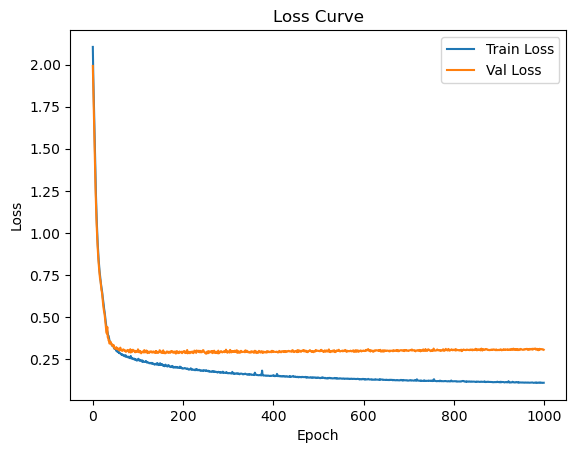

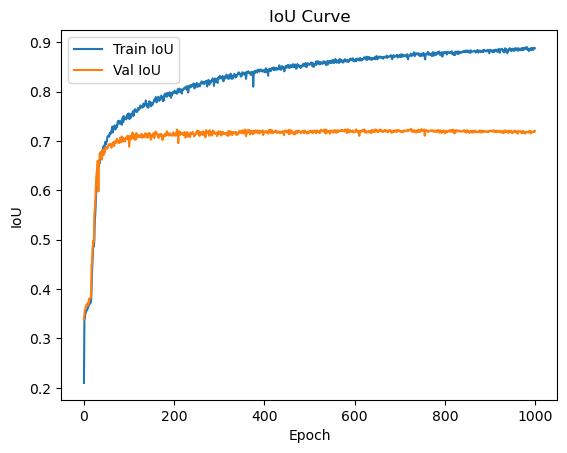

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        num_classes = preds.shape[1]
        preds = torch.softmax(preds, dim=1)
        targets_onehot = F.one_hot(targets, num_classes).permute(0, 4, 1, 2, 3).float()
        intersection = (preds * targets_onehot).sum(dim=(2, 3, 4))
        union = preds.sum(dim=(2, 3, 4)) + targets_onehot.sum(dim=(2, 3, 4))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

def compute_iou(pred, target, num_classes=4):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)
    return torch.tensor(ious).nanmean().item()

class BraTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])  # [128,128,128,3]
        mask = np.load(self.mask_paths[idx])    # [128,128,128,4]

        image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2)  # [3, D, H, W]
        mask = torch.tensor(np.argmax(mask, axis=-1), dtype=torch.long)      # [D, H, W]
        return image, mask

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D_GN_SE(in_channels=3, out_classes=4).to(device)

ce_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

train_dataset = BraTSDataset(
    image_dir='BraTS2021_TrainingData_Split/train/images/',
    mask_dir='BraTS2021_TrainingData_Split/train/masks/'
)
val_dataset = BraTSDataset(
    image_dir='BraTS2021_TrainingData_Split/val/images/',
    mask_dir='BraTS2021_TrainingData_Split/val/masks/'
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)

num_epochs = 1000
train_losses, val_losses, train_ious, val_ious = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    total_loss, total_iou = 0, 0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_iou += compute_iou(outputs.argmax(1), masks)

    train_losses.append(total_loss / len(train_loader))
    train_ious.append(total_iou / len(train_loader))

    model.eval()
    val_loss, val_iou = 0, 0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = ce_loss(outputs, masks) + dice_loss(outputs, masks)
            val_loss += loss.item()
            val_iou += compute_iou(outputs.argmax(1), masks)

    val_losses.append(val_loss / len(val_loader))
    val_ious.append(val_iou / len(val_loader))

    print(f"Epoch {epoch+1}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}, "
          f"Train IoU = {train_ious[-1]:.4f}, Val IoU = {val_ious[-1]:.4f}")

torch.save(model.state_dict(), "GN_SE_1000.pth")

plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")
plt.show()

plt.figure()
plt.plot(train_ious, label='Train IoU')
plt.plot(val_ious, label='Val IoU')
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.title("IoU Curve")
plt.show()



===== Test Evaluation Summary =====
Mean IoU   : 0.7417
Mean Dice  : 0.8199
Mean HD95  : 27.3197
Mean ASSD  : 0.7560


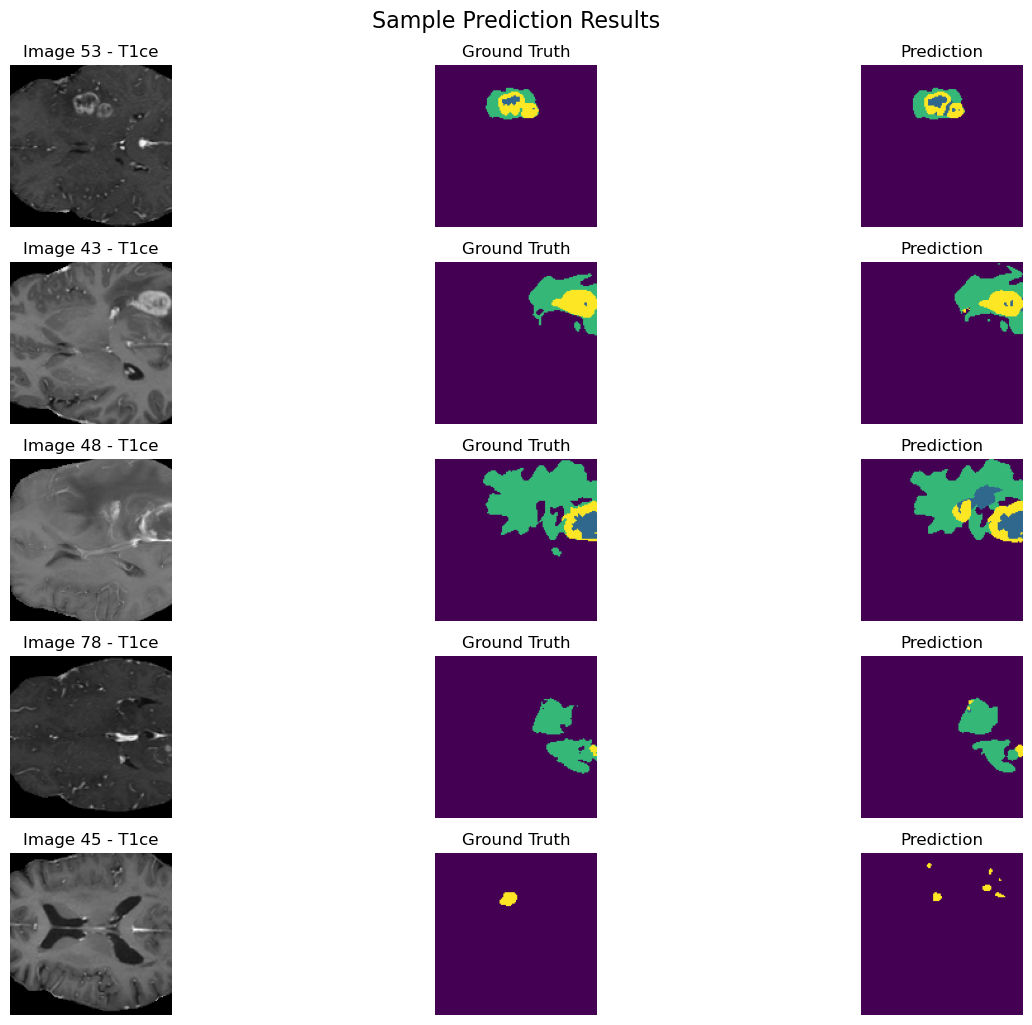

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        mask = np.load(self.mask_paths[idx])
        image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2)  # [C,D,H,W]
        mask = torch.tensor(np.argmax(mask, axis=-1), dtype=torch.long)      # [D,H,W]
        return image, mask

def compute_iou(pred, target, num_classes=4):
    pred, target = pred.view(-1), target.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        ious.append(intersection / union if union != 0 else float('nan'))
    return np.nanmean(ious)

def compute_dice(pred, target, num_classes=4, smooth=1e-5):
    pred, target = pred.view(-1), target.view(-1)
    dices = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item()
        dices.append((2. * intersection + smooth) / (union + smooth) if union != 0 else float('nan'))
    return np.nanmean(dices)

def compute_hd95(pred_np, gt_np):
    pred_itk = sitk.GetImageFromArray(pred_np.astype(np.uint8))
    gt_itk = sitk.GetImageFromArray(gt_np.astype(np.uint8))
    hausdorff = sitk.HausdorffDistanceImageFilter()
    hausdorff.Execute(pred_itk, gt_itk)
    return hausdorff.GetHausdorffDistance(), hausdorff.GetAverageHausdorffDistance()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D_GN_SE(in_channels=3, out_classes=4).to(device)
model.load_state_dict(torch.load("GN_SE_100.pth", map_location=device))
model.eval()

test_dataset = BraTSDataset('BraTS2021_Testing/images/', 'BraTS2021_Testing/masks/')
ious, dices, hd95s, assds = [], [], [], []

for image, mask in test_dataset:
    image, mask = image.to(device), mask.to(device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # [1,C,D,H,W]
        pred = output.argmax(dim=1).squeeze(0)  # [D,H,W]

    ious.append(compute_iou(pred, mask))
    dices.append(compute_dice(pred, mask))
    hd, assd = compute_hd95(pred.cpu().numpy(), mask.cpu().numpy())
    hd95s.append(hd)
    assds.append(assd)

print(f"\n===== Test Evaluation Summary =====")
print(f"Mean IoU   : {np.nanmean(ious):.4f}")
print(f"Mean Dice  : {np.nanmean(dices):.4f}")
print(f"Mean HD95  : {np.nanmean(hd95s):.4f}")
print(f"Mean ASSD  : {np.nanmean(assds):.4f}")

slice_idx = 62
indices_to_plot = [53, 43, 48] + random.sample([i for i in range(len(test_dataset)) if i not in [53,43,48]], 2)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices_to_plot):
    image, mask = test_dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(image[1, :, :, slice_idx], cmap='gray')  # T1ce channel
    plt.title(f"Image {idx} - T1ce")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(mask[:, :, slice_idx].cpu())
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 3)
    plt.imshow(pred[:, :, slice_idx])
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Sample Prediction Results", y=1.02, fontsize=16)
plt.show()

Evaluation For 1000



===== Test Evaluation Summary =====
Mean IoU   : 0.7555
Mean Dice  : 0.8295
Mean HD95  : 24.3372
Mean ASSD  : 0.4714


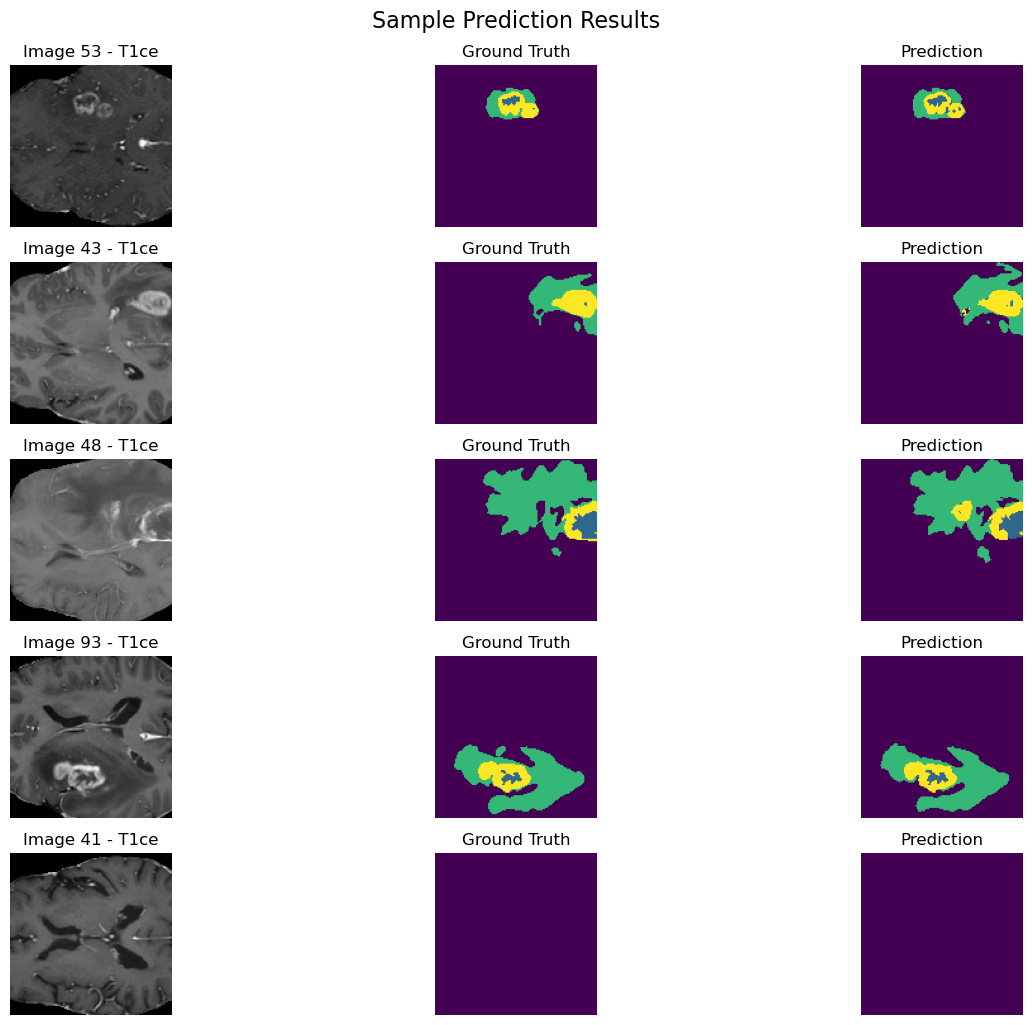

In [ ]:
class BraTSDataset(Dataset):
    def __init__(self, image_dir, mask_dir):
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.mask_paths = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.load(self.image_paths[idx])
        mask = np.load(self.mask_paths[idx])
        image = torch.tensor(image, dtype=torch.float32).permute(3, 0, 1, 2)  # [C,D,H,W]
        mask = torch.tensor(np.argmax(mask, axis=-1), dtype=torch.long)      # [D,H,W]
        return image, mask

def compute_iou(pred, target, num_classes=4):
    pred, target = pred.view(-1), target.view(-1)
    ious = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = (pred_inds | target_inds).sum().item()
        ious.append(intersection / union if union != 0 else float('nan'))
    return np.nanmean(ious)

def compute_dice(pred, target, num_classes=4, smooth=1e-5):
    pred, target = pred.view(-1), target.view(-1)
    dices = []
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item()
        dices.append((2. * intersection + smooth) / (union + smooth) if union != 0 else float('nan'))
    return np.nanmean(dices)

def compute_hd95(pred_np, gt_np):
    pred_itk = sitk.GetImageFromArray(pred_np.astype(np.uint8))
    gt_itk = sitk.GetImageFromArray(gt_np.astype(np.uint8))
    hausdorff = sitk.HausdorffDistanceImageFilter()
    hausdorff.Execute(pred_itk, gt_itk)
    return hausdorff.GetHausdorffDistance(), hausdorff.GetAverageHausdorffDistance()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet3D_GN_SE(in_channels=3, out_classes=4).to(device)
model.load_state_dict(torch.load("GN_SE_1000.pth", map_location=device))
model.eval()

test_dataset = BraTSDataset('BraTS2021_Testing/images/', 'BraTS2021_Testing/masks/')
ious, dices, hd95s, assds = [], [], [], []

for image, mask in test_dataset:
    image, mask = image.to(device), mask.to(device)
    with torch.no_grad():
        output = model(image.unsqueeze(0))  # [1,C,D,H,W]
        pred = output.argmax(dim=1).squeeze(0)  # [D,H,W]

    ious.append(compute_iou(pred, mask))
    dices.append(compute_dice(pred, mask))
    hd, assd = compute_hd95(pred.cpu().numpy(), mask.cpu().numpy())
    hd95s.append(hd)
    assds.append(assd)

print(f"\n===== Test Evaluation Summary =====")
print(f"Mean IoU   : {np.nanmean(ious):.4f}")
print(f"Mean Dice  : {np.nanmean(dices):.4f}")
print(f"Mean HD95  : {np.nanmean(hd95s):.4f}")
print(f"Mean ASSD  : {np.nanmean(assds):.4f}")

slice_idx = 62
indices_to_plot = [53, 43, 48] + random.sample([i for i in range(len(test_dataset)) if i not in [53,43,48]], 2)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(indices_to_plot):
    image, mask = test_dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

    plt.subplot(5, 3, i * 3 + 1)
    plt.imshow(image[1, :, :, slice_idx], cmap='gray')  # T1ce channel
    plt.title(f"Image {idx} - T1ce")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 2)
    plt.imshow(mask[:, :, slice_idx].cpu())
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(5, 3, i * 3 + 3)
    plt.imshow(pred[:, :, slice_idx])
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Sample Prediction Results", y=1.02, fontsize=16)
plt.show()

### Result Analysis

|           | Base   | AG+LR  | BN     | BN+SE  | GN+SE  | V2     |
|-----------|--------|--------|--------|--------|--------|--------|
| Mean IoU  | 0.6284 | 0.6569 | 0.7344 | 0.7470 | 0.7417 | 0.7434 |
| Mean Dice | 0.7228 | 0.7510 | 0.8145 | 0.8251 | 0.8199 | 0.8212 |
| Mean HD95 | 23.759 | 25.242 | 24.985 | 20.761 | 27.320 | 30.431 |
| Mean ASSD | 0.6514 | 0.6235 | 0.5035 | 0.5322 | 0.7560 | 0.3999 |

Results at 100 epochs


|           | BN+SE/100 | BN+SE/200 | BN+SE/300 | BN+SE/400 | GN+SE/100 | GN+SE/1000 |
|:---------:|:---------:|:---------:|:---------:|:---------:|:---------:|:----------:|
|  Mean IoU |   0.7470  |   0.7616  |   0.7439  |   0.7581  |   0.7417  |   0.7555   |
| Mean Dice |   0.8251  |   0.8356  |   0.8212  |   0.8334  |   0.8199  |   0.8295   |
| Mean HD95 |   20.761  |  26.2075  |   27.509  |   24.517  |   27.320  |   24.3372  |
| Mean ASSD |   0.5322  |   0.4310  |   0.4111  |   0.3933  |   0.7560  |   0.4714   |




1. Normally, at such small batch_size (2), Group Normalization should perform better than Batch Normalization. But in this project, BN performs a bit better.
This is probably because each patient has 150/128 slices of image. If you consider them separately, that is already 256 images per batch, which is large enough.

2. Squeeze-Excitation shows a much better balance in training speed and accuracy than Attention Gate. However, this may be caused by relatively small Epoch size.

3. The small misclassified dots in prediction: False positive, this might be mitigated by replacing HD95 with full Hausdorff distance that takes all edge pixels equally. 
However, these images are probably all from dead people, their tumors are extremely large (some even accounts for half of the brain). In a real-life scenario, the tumors should be much smaller, and considering the importance of recall rate. A small amount of False Positive is acceptable, since even the smallest detection should raise the alarm.


4. About data augmentation and overfitting.

    i. Data augmentation is most useful if we have high-quality training data and expect the test set to be poorly organized. (If we have clear pictures of cats and dogs, and want to detect them is a real world scenario where they are running around.). Techniques such as rotating, blurring are most useful in these cases.

       In our case, we expect test set (future MRI scans that need to be predicted) to all look exactly like our training set, such augmentation techniques seem to be unnecessary.

    ii. About Overfitting. We try to avoid overfitting because we want to keep the generalization ability of our model.
    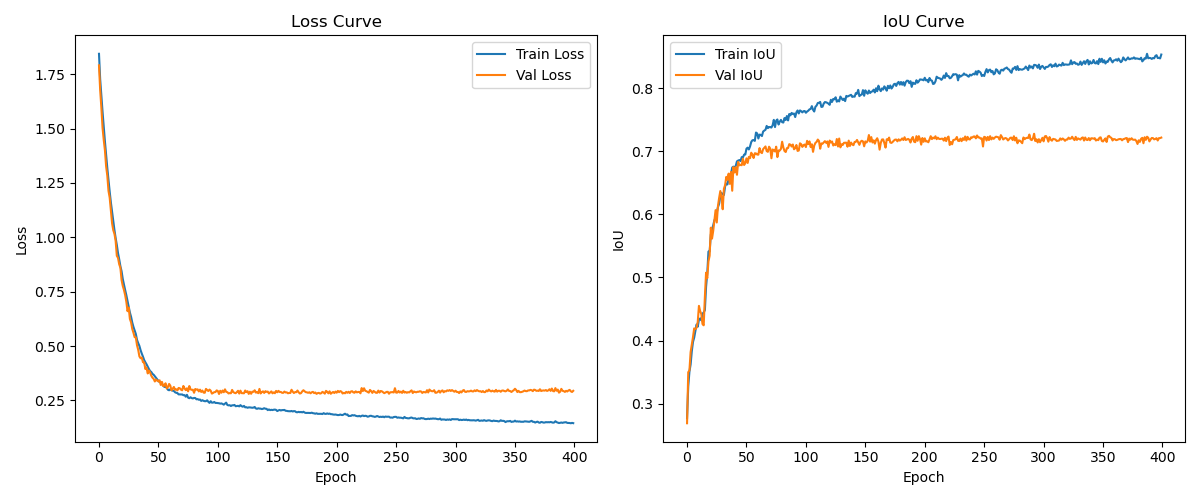
    This image is from BN_SE_400

       In our case, since all future data are expected to look the same, we don't need any extra generalizatoin ability, so we can keep training the model and focus on training results.

##### Future
We may need to further modify the structre of model for higher IoU score, now it seems that the model reaches a plateau after 100 Epochs.

We can focus on the edges for more precise segmentation.